In [164]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from scipy.stats import mode
from typing import Tuple
import os

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, RobustScaler

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, make_scorer, fbeta_score
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, roc_curve, f1_score, auc
from sklearn.calibration import CalibratedClassifierCV
from sklearn import metrics
import matplotlib.pyplot as plt
from collections import defaultdict

from imblearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
import re
import warnings
import scikitplot as skplt
warnings.filterwarnings("ignore")
import joblib

all carried out under different models. 
1. Prediction without experience.
2. Prediction with experience (number).
3. Prediction with experience levels
4. Prediction with both experience levels and country importance
5. Prediction with cost-sensitity models. 

In [118]:
PPP_data = pd.read_csv(r"C:\PPP\Network for joint venture\PPP_Projects_Total-No IFC.csv")
# get the countrycode and coresponding country
country_to_code = PPP_data[['country', 'countrycode']].drop_duplicates()
country_to_code.index = np.arange(country_to_code.shape[0])

In [119]:
def plot_cost_distribution(True_cost, False_cost):
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    for ax in axes:
        ax.legend(frameon=False, prop={'family':'Times new roman', 'size':16}, ncol=4)

        ax.tick_params(axis='both', length=7, labelsize=23, width=1.5, color='black')
        ax.spines["top"].set_linewidth(1.5)
        ax.spines["bottom"].set_linewidth(1.5)
        ax.spines["left"].set_linewidth(1.5)
        ax.spines["right"].set_linewidth(1.5)

        xlabels = ax.get_xticklabels() + ax.get_yticklabels()
        [label.set_fontname('times new roman') for label in xlabels]
        plt.subplots_adjust(left=0.105, right=0.9, top=0.95, bottom=0.12)
        
        ax.grid(axis='y', c='black', linestyle='--')
        ax.grid(axis='x', c='black', linestyle='--')
    axes[0].hist(True_cost, color='blue', bins=30)
    axes[0].set_xlabel("Project investment (million dollars)", fontsize=25, fontname='times new roman', labelpad=10)
    axes[0].set_ylabel("Count", fontsize=25, fontname='times new roman', labelpad=1)
    
    axes[1].hist(False_cost, color='red', bins=30)
    axes[1].set_xlabel("Project investment (million dollars)", fontsize=25, fontname='times new roman', labelpad=10)
    axes[1].set_ylabel("Count", fontsize=25, fontname='times new roman', labelpad=1)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


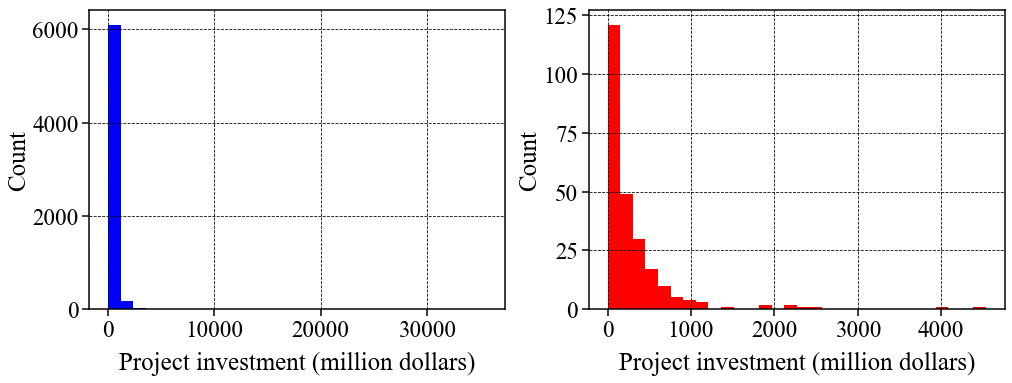

In [120]:
True_cost = PPP_data[(PPP_data.status_n == 'Active') | (PPP_data.status_n == 'Concluded')]['investment']
False_cost = PPP_data[(PPP_data.status_n == 'Distressed') | (PPP_data.status_n == 'Cancelled')]['investment']
plot_cost_distribution(True_cost, False_cost)

In [121]:
datetime_FCY = pd.DataFrame()
#Convert the wrong date format to the right format
datetime_FCY['Year'] = PPP_data.FCY.map(lambda x: x.split('/')[2])
datetime_FCY['Month'] = PPP_data.FCY.map(lambda x: x.split('/')[1])
datetime_FCY['Day'] = PPP_data.FCY.map(lambda x: x.split('/')[0])
df = pd.DataFrame({'year': datetime_FCY['Year'],
                   'month': datetime_FCY['Month'],
                  'day': datetime_FCY['Day']})
PPP_data.FCY = pd.to_datetime(df)

#Obtain different status
PPP_Cancelled = PPP_data[PPP_data['status_n'] == 'Cancelled']
PPP_Active = PPP_data[PPP_data['status_n'] == 'Active']
PPP_Concluded = PPP_data[PPP_data['status_n'] == 'Concluded']
PPP_Distressed = PPP_data[PPP_data['status_n'] == 'Distressed']

#20140701
year_threshold= pd.to_datetime(20140701,format='%Y%m%d')
PPP_Active_Threshold = PPP_Active[PPP_Active['FCY'] <= year_threshold]
#Useful data after threshold
PPP_data = pd.concat([PPP_Active_Threshold, PPP_Cancelled, PPP_Distressed, PPP_Concluded])
PPP_Energy = PPP_data[PPP_data.sector == "Energy"]
PPP_ICT = PPP_data[PPP_data.sector == "ICT"]
PPP_Transport = PPP_data[PPP_data.sector == "Transport"]
PPP_Water = PPP_data[PPP_data.sector == "Water and sewerage"]

print("shape of energy sector: ", PPP_Energy.shape)
print("shape of ICT sector: ", PPP_ICT.shape)
print("shape of transport sector: ", PPP_Transport.shape)
print("shape of water sector: ", PPP_Water.shape)

shape of energy sector:  (2595, 44)
shape of ICT sector:  (119, 44)
shape of transport sector:  (1462, 44)
shape of water sector:  (836, 44)


In [122]:
#1.PPI database
PPP_data = PPP_Energy
#sector experience- conventional method
country_sector_experience = PPP_data.groupby(['countrycode', 'IY', 'ssector']).size().reset_index().sort_values(['countrycode', 'IY'])
country_sector_experience.columns = ['countrycode', 'IY', 'ssector', 'ssector_experience']
unique_sector_country = country_sector_experience.countrycode.unique()
unique_sector = country_sector_experience.ssector.unique()
years = np.arange(1990, 2020)

for country in unique_sector_country:
    for year in years:
        if year not in country_sector_experience.loc[country_sector_experience.countrycode==country, 'IY'].values:
            for sectors in unique_sector:
                country_sector_experience = country_sector_experience.append({'countrycode': country, 
                                                                              'IY': year, 
                                                                              'ssector': sectors, 
                                                                              'ssector_experience': 0}, ignore_index=True)
        else:
            for sectors in unique_sector:
                if sectors not in country_sector_experience.loc[(country_sector_experience.countrycode==country) & (country_sector_experience.IY==year),
                                                                'ssector'].values:
                    country_sector_experience = country_sector_experience.append({'countrycode': country, 
                                                                                  'IY': year, 
                                                                                  'ssector': sectors, 
                                                                                  'ssector_experience': 0}, ignore_index=True)

country_sector_experience = country_sector_experience.sort_values(by=['countrycode', 'IY']).set_index(np.arange(country_sector_experience.shape[0]))
country_sector_experience['cum_ssector_experience'] = country_sector_experience.groupby(['countrycode', 'ssector'])['ssector_experience'].cumsum()
country_sector_experience.drop(columns=['ssector_experience'], inplace=True)

country_sector_experience['shifted_ssector_experience_1'] = country_sector_experience.groupby(['countrycode', 'ssector'])['cum_ssector_experience'].shift(1).fillna(method='bfill')
country_sector_experience.drop(columns=['cum_ssector_experience'], inplace=True)

In [123]:
PPP_data = PPP_data.merge(country_sector_experience,
                          left_on=['countrycode', 'IY', 'ssector'],
                          right_on=['countrycode', 'IY', 'ssector'],
                          how='left')

PPP_data.loc[:, 'PCO'] = PPP_data['PCO'].str.replace('\n', '') 
PPP_data.loc[~PPP_data.PCO.isnull() & (PPP_data.PCO != ''), 
             'sponsor_number'] = PPP_data[~PPP_data.PCO.isnull() & (PPP_data.PCO != '')].PCO.str.split('/').map(lambda x: x[2])
PPP_data.sponsor_number = PPP_data.sponsor_number.replace('', np.nan)
# Whether the foreign country exists in the project or not, categorical variable.
PPP_data.loc[~PPP_data.PCO.isnull() & (PPP_data.PCO != ''), 
             'foreign_country_exist'] = PPP_data[~PPP_data.PCO.isnull() & (PPP_data.PCO != '')].PCO.str.split('/').map(lambda x: x[1])
PPP_data.foreign_country_exist = PPP_data.foreign_country_exist.replace('N', 'No')
PPP_data.loc[(PPP_data.foreign_country_exist!='No') & (~PPP_data.foreign_country_exist.isnull()), 'foreign_country_exist'] = 'Yes'
# List of Foreign country for each project.
PPP_data.loc[~PPP_data.PCO.isnull() & (PPP_data.PCO != ''), 
             'foreign_country'] = PPP_data[~PPP_data.PCO.isnull() & (PPP_data.PCO != '')].PCO.str.split('/').map(lambda x: x[1])
PPP_data.foreign_country = PPP_data.foreign_country.replace('N', 'No')
PPP_data.loc[PPP_data.foreign_country.isnull(), 'foreign_country'] = 'No'

In [124]:
SNA_metric_indegree = pd.read_csv(r"C:\PPP\Thesis\QE and Thesis_Final\Thesis\SNA for different sectors\energyindegree.csv", 
                                  index_col='country')
SNA_metric_outdegree = pd.read_csv(r"C:\PPP\Thesis\QE and Thesis_Final\Thesis\SNA for different sectors\energyoutdegree.csv", 
                                   index_col='country')
SNA_metric_pagerank = pd.read_csv(r"C:\PPP\Thesis\QE and Thesis_Final\Thesis\SNA for different sectors\energypagerank.csv", 
                                  index_col='country')

def Convert_SNA(SNAMetric, newColumns):
    SNAMetric.fillna(0, inplace=True)
    SNAMetric['1989'] = 0
    SNAMetric = SNAMetric.stack().reset_index()
    SNAMetric.columns = newColumns
    SNAMetric.IY = SNAMetric.IY.astype('int64') + 1
    return SNAMetric

SNA_metric_indegree = Convert_SNA(SNA_metric_indegree, ['country', 'IY', 'indegree'])
SNA_metric_outdegree = Convert_SNA(SNA_metric_outdegree, ['country', 'IY', 'outdegree'])
SNA_metric_pagerank = Convert_SNA(SNA_metric_pagerank, ['country', 'IY', 'pagerank'])

PPP_data = PPP_data.merge(SNA_metric_indegree, on=['IY', 'country'], how='left')
PPP_data.indegree = PPP_data.indegree.fillna(0)

PPP_data = PPP_data.merge(SNA_metric_outdegree, on=['IY', 'country'], how='left')
PPP_data.outdegree = PPP_data.outdegree.fillna(0)

PPP_data = PPP_data.merge(SNA_metric_pagerank, on=['IY', 'country'], how='left')
PPP_data.pagerank = PPP_data.pagerank.fillna(0)

In [125]:
PPP_data.foreign_country = PPP_data.foreign_country.map(lambda x: x.split(','))
all_country = []
for i in PPP_data.foreign_country:
    if i != ['No']:
        all_country.extend(i)
result = list(set(all_country))

for column in result:
    PPP_data[column] = 0

for index, row in PPP_data.iterrows():
    if row['foreign_country'] != ['No']:
        for country_column in row['foreign_country']:
            PPP_data.loc[index, country_column] = SNA_metric_pagerank.loc[(SNA_metric_pagerank.IY == row['IY']) & (SNA_metric_pagerank.country == country_column), 'pagerank'].values[0]

In [126]:
#2.GDP per capita
GDP_per_capita = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\GDP per Capita.csv")
#3.Tax as GDP
tax_as_GDP = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Tax as GDP.csv")
#4.GDP deflator(inflation rate)
GDP_deflator = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\GDP deflator.csv")
#5.life expectnacy
life_expectnacy = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Life expectnacy.csv")
#6.real effective change
real_effective_change = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Real effect change.csv")
#7.electric consumption
electric_consumption = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Electric consumption.csv")
#8.domestic credit to private
domestic_credit_to_private = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Domestic credit to private.csv")
#9.Import as GDP
imports_as_GDP = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Imports as GDP.csv")
#10.Export as GDP
exports_as_GDP = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Exports as GDP.csv")
#11.Control of corruption
control_of_corruption = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Control of corruption.csv", encoding='cp1252')
#12.Government of effectiveness
government_effectiveness = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Government effectiveness.csv", encoding='cp1252')
#13.Political stability
political_stability = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Political Stability and Absence of Violence.csv", encoding='cp1252')
#14.regulatory quality
regulatory_quality = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Regulatory quality.csv", encoding='cp1252')
#15.Rule of law
rule_of_law = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Rule of law.csv", encoding='cp1252')
#16.voice and accountability
voice_and_accountability = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Voice and accountability.csv", encoding='cp1252')

dataset = [GDP_per_capita, 
           tax_as_GDP, 
           GDP_deflator, 
           life_expectnacy, 
           real_effective_change,
           electric_consumption,
           domestic_credit_to_private, 
           imports_as_GDP, 
           exports_as_GDP, 
           control_of_corruption,
           government_effectiveness, 
           political_stability, 
           regulatory_quality, 
           rule_of_law, 
           voice_and_accountability]

dataset_name = ['GDP_per_capita', 
                'tax_as_GDP', 
                'GDP_deflator', 
                'life_expectnacy', 
                'real_effective_change',
                'electric_consumption', 
                'domestic_credit_to_private', 
                'imports_as_GDP', 
                'exports_as_GDP', 
                'control_of_corruption',
                'government_effectiveness',
                'political_stability', 
                'regulatory_quality', 
                'rule_of_law', 
                'voice_and_accountability']

def process_data(original_data):
    new_data = original_data.copy()
    new_data.replace('..', np.nan, inplace=True)
    new_data.drop(columns=['Series Name', 'Series Code', 'Country Name'], inplace=True)
    new_data.set_index('Country Code', inplace=True)
    new_data.dropna(how='all', inplace=True)
    new_data.columns = [name.split(' ')[0] for name in list(new_data.columns)]
    new_data = new_data.fillna(axis=1, method='bfill')
    new_data = new_data.fillna(axis=1, method='ffill')
    return new_data

for i in np.arange(len(dataset)):
    dataset[i] = process_data(dataset[i])

def meltdata(raw_data, column_name):
    new_data = pd.melt(raw_data.reset_index(), 
                       id_vars=['Country Code'], 
                       var_name=['Year'],
                       value_vars=raw_data.columns,
                       value_name=column_name)   
    new_data.Year = new_data.Year.astype('int64', copy=False)
    return new_data

for i,name in zip(np.arange(len(dataset)), dataset_name):
    dataset[i] = meltdata(dataset[i], name).copy()
    dataset[i].rename(columns={'Country Code': 'countrycode', 
                               'Year': 'IY'}, 
                      inplace=True)
    dataset[i][name] = dataset[i].groupby('countrycode')[name].shift(1).fillna(method='bfill')

for data in dataset:
    PPP_data= PPP_data.merge(data, 
                             left_on=['countrycode', 'IY'], 
                             right_on=['countrycode', 'IY'], 
                             how='left')

#copy data out.
data = PPP_data.copy()
data.drop(columns=['country',
                   'regionname',                   
                   'region',
                   'adminregionname',
                   'Description',
                   'FCY',
                   'bid_crit',
                   'incomelevelname',
                   'lendingtypename',
                   'TIGS',
                   'PCO',
                   'sector',
                   'shareborder',
                   'GDP',
                   'population',
                   'investment_real',
                   'realphysicalassets',
                   'income'], inplace=True)

data.replace('..', np.nan, inplace=True)

data.replace({'status_n': {'Cancelled': 'fail', 
                           'Distressed': 'fail', 
                           'Active': 'success',
                           'Concluded': 'success'}}, inplace=True)

float_value = ['GDP_per_capita', 
               'tax_as_GDP', 
               'GDP_deflator', 
               'life_expectnacy', 
               'real_effective_change',
               'electric_consumption', 
               'domestic_credit_to_private', 
               'imports_as_GDP', 
               'exports_as_GDP', 
               'control_of_corruption',
               'government_effectiveness', 
               'political_stability', 
               'regulatory_quality', 
               'rule_of_law', 
               'voice_and_accountability',
               'shifted_ssector_experience_1',
               'period',
               'CPI2019',
               'bordercountries', 
               'private', 
               'physical', 
               'investment', 
               'pcapacity',
               'sponsor_number',
               'IY',
               'indegree',
               'outdegree',
               'pagerank']
nominal_value = ['IDA', 
                 'Region',
                 'type', 
                 'stype', 
                 'ssector',
                 'Segment', 
                 'UP', 
                 'PublicDisclosure', 
                 'PRS', 
                 'Renewables', 
                 'MLS', 
                 'GGC',
                 'BS',
                 'lendingtype'
                 'adminregion',
                 'foreign_country_exist',
                 'foreign_country']
ordinal_value = ['incomelevel']

for float_column in float_value:
    data[float_column] = data[float_column].astype(float)

data.drop(columns=['foreign_country'], inplace=True)
# BS (Bilateral Support) replace with NO and Yes, 
data.loc[(data.BS!='No') & (~data.BS.isnull()), 'BS'] = 'Yes'
#private convert to categorical data.
#physical, investment, pcapacity will be converted to np.log
to_log = ['physical', 'pcapacity']
for column in to_log:
    data[column] = np.log(data[column] + 0.01)

#split the data
X = data[data.columns[data.columns!='status_n']]
y = data['status_n']
#income value is ordinal value
mapper = {'LIC': 1, 
          'HIC': 4, 
          'LMC': 2, 
          'UMC': 3}
X.loc[:, 'incomelevel'] = X.incomelevel.map(mapper)

predicted_status = {'success': 0, 
                    'fail': 1}
y = y.map(predicted_status)
X = X.drop(columns=['IY'])

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y, shuffle=True)

original_train_index = X_train.index.tolist()
original_test_index = X_test.index.tolist()

X_train.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)


#with experience in number
X_train_number = X_train.copy()
X_train_number = X_train_number.drop(columns=['indegree', 'outdegree', 'pagerank'] + result)

X_test_number = X_test.copy()
X_test_number = X_test_number.drop(columns=['indegree', 'outdegree', 'pagerank'] + result)
#with no experience
X_train_no = X_train.drop(columns=['shifted_ssector_experience_1', 'indegree', 'outdegree', 'pagerank'] + result)
X_test_no = X_test.drop(columns=['shifted_ssector_experience_1', 'indegree', 'outdegree', 'pagerank'] + result)
#with experience in levels
X_train_level_SNA = X_train.copy()
X_test_level_SNA = X_test.copy()

X_train_level_SNA.loc[X_train_level_SNA.shifted_ssector_experience_1 < 30, 
                             'shifted_ssector_experience_1'] = 1
X_train_level_SNA.loc[(X_train_level_SNA.shifted_ssector_experience_1 >= 30) & 
                             (X_train_level_SNA.shifted_ssector_experience_1 < 57), 
                             'shifted_ssector_experience_1'] = 2
X_train_level_SNA.loc[(X_train_level_SNA.shifted_ssector_experience_1 >= 57) & 
                             (X_train_level_SNA.shifted_ssector_experience_1 < 125),
                             'shifted_ssector_experience_1'] = 3
X_train_level_SNA.loc[X_train_level_SNA.shifted_ssector_experience_1 > 125, 
                             'shifted_ssector_experience_1'] = 4

X_test_level_SNA.loc[X_test_level_SNA.shifted_ssector_experience_1 < 30, 
                            'shifted_ssector_experience_1'] = 1
X_test_level_SNA.loc[(X_test_level_SNA.shifted_ssector_experience_1 >= 30) & 
                             (X_test_level_SNA.shifted_ssector_experience_1 < 57), 
                            'shifted_ssector_experience_1'] = 2
X_test_level_SNA.loc[(X_test_level_SNA.shifted_ssector_experience_1 >= 57) & 
                             (X_test_level_SNA.shifted_ssector_experience_1 < 125), 
                            'shifted_ssector_experience_1'] = 3
X_test_level_SNA.loc[X_test_level_SNA.shifted_ssector_experience_1 > 125, 
                            'shifted_ssector_experience_1'] = 4

X_train_level = X_train_level_SNA.drop(columns=['indegree', 'outdegree', 'pagerank'] + result)
X_test_level = X_test_level_SNA.drop(columns=['indegree', 'outdegree', 'pagerank'] + result)


print("shape of no train dataset: ", X_train_no.shape)
print("shape of no test dataset: ", X_test_no.shape)
print("shape of number train dataset: ", X_train_number.shape)
print("shape of number test dataset: ", X_test_number.shape)
print("shape of level train dataset: ", X_train_level_SNA.shape)
print("shape of level test dataset: ", X_test_level_SNA.shape)
print("imbalance rate of train dataset: ", y_train.sum()/y_train.shape)
print("imbalance rate of test dataset: ", y_test.sum()/y_test.shape)
print("failure projects of train dataset: ", y_train.sum())
print("failure projects of test dataset: ", y_test.sum())

shape of no train dataset:  (2076, 41)
shape of no test dataset:  (519, 41)
shape of number train dataset:  (2076, 42)
shape of number test dataset:  (519, 42)
shape of level train dataset:  (2076, 92)
shape of level test dataset:  (519, 92)
imbalance rate of train dataset:  [0.03179191]
imbalance rate of test dataset:  [0.03082852]
failure projects of train dataset:  66
failure projects of test dataset:  16


In [128]:
#imputing numerical value
class FillNumericalNa(BaseEstimator, TransformerMixin):
    def __init__(self, column, group_list):
        self.column = column
        self.group_list = group_list
        
    def fit(self, X, y=None):
        self.mean = X.groupby(self.group_list)[self.column].agg(pd.Series.mean).to_frame().reset_index()
        self.column_mean = X[self.column].mean()
        return self
    
    def transform(self, X, y=None):
        X_ = X.copy()
        X_result = X_.reset_index().merge(self.mean, on=self.group_list, how='left').set_index('index')
        for i in X_[np.isnan(X_[self.column])].index:
            X_.loc[i, self.column] = X_result.loc[i, self.column + '_y']
        X_[self.column].fillna(self.column_mean, inplace=True)
        return X_

# imputing categorical value
class FillCategoricalNa(BaseEstimator, TransformerMixin):
    def __init__(self, column, group_list):
        self.column = column
        self.group_list = group_list
        
    def fit(self, X, y=None):
        self.column_mode = X[self.column].mode()[0]
        self.mode = X.groupby(self.group_list)[self.column].agg(pd.Series.to_list).to_frame().reset_index()
        for index, row in self.mode.iterrows():
            if row[self.column] == [np.nan]:
                self.mode.loc[index, self.column] = self.column_mode
                #row[self.column] = self.column_mode
    
        self.mode[self.column] = self.mode[self.column].map(lambda x: mode(x)[0][0])
                
        self.column_mode = X[self.column].mode()[0]
        return self
    
    def transform(self, X, y=None):
        X_ = X.copy()
        X_result = X_.reset_index().merge(self.mode, on=self.group_list, how='left').set_index('index')
        for i in X_[X_[self.column].isnull()].index:
            X_.loc[i, self.column] = X_result.loc[i, self.column + '_y'] 
        X_[self.column].fillna(self.column_mode, inplace=True)
        return X_

#drop columns
class DropColumn(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_ = X.copy()
        X_.drop(columns=self.column, inplace=True)
        return X_
#get_dummies
from pandas.api.types import CategoricalDtype
class DummyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, min_frequency=1, dummy_na=True):
        self.min_frequency = min_frequency
        self.dummy_na = dummy_na
        self.categories = dict()

    def fit(self, X, y=None):
        for col in X.select_dtypes(include=['object']).columns:
            counts = pd.value_counts(X[col])
            self.categories[col] = list(set(counts[counts >= self.min_frequency].index.tolist()))
        return self

    def transform(self, X, *_):
        for col in X.select_dtypes(include=['object']).columns:
            X = X.astype({col: CategoricalDtype(self.categories[col], ordered=True)})
        ret = pd.get_dummies(X, drop_first=True, dummy_na=self.dummy_na)
        return ret
def plot_roc(y_true, y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)   
    ax.plot(fpr, tpr, 'k', label = 'AUC = %0.2f' % roc_auc)
    ax.set_xlabel("False Positive Rate", fontsize=25, fontname='times new roman', labelpad=10)
    ax.set_ylabel("True Positive Rate", fontsize=25, fontname='times new roman', labelpad=1)
    ax.legend(loc='lower right', frameon=False, prop={'family':'Times new roman', 'size':20})
    ax.plot([0, 1], [0, 1],'r--')
    ax.tick_params(axis='both', length=7, labelsize=23, width=1.5, color='black')
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]
    plt.axis('square')
    plt.grid(True)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.subplots_adjust(left=0.14, right=0.96, top=0.96, bottom=0.14)
    #plt.savefig(r"C:\PPP\Thesis\Paper3\ROC.png", dpi=1000)

def plot_recall_precision(y_true, y_pred):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)   
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_pred)
    ax.plot(recall, precision, 'k')
    no_skill = y_true.sum()/len(y_true)
    ax.plot([0, 1], [no_skill, no_skill], linestyle='--')
    ax.set_xlabel("Recall", fontsize=25, fontname='times new roman', labelpad=10)
    ax.set_ylabel("Precision", fontsize=25, fontname='times new roman', labelpad=4)
    ax.legend(frameon=False, prop={'family':'Times new roman', 'size':23})
    ax.tick_params(axis='both', length=7, labelsize=23, width=1.5, color='black')
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]
    plt.axis('square')
    plt.grid(True)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.subplots_adjust(left=0.14, right=0.96, top=0.96, bottom=0.14)
    #plt.savefig(r"C:\PPP\Thesis\Paper3\precision-recall.png", dpi=1000)

#plot function
def plot_cm(labels, predictions, p):
    cm = confusion_matrix(labels, predictions > p)
    new_cm = np.array([[0, 0], [0, 0]])
    new_cm[0, 0] = cm[1, 1]
    new_cm[0, 1] = cm[0, 1]
    new_cm[1, 0] = cm[1, 0]
    new_cm[1, 1] = cm[0, 0]
    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)  

    cmap = sns.cubehelix_palette(light=1, as_cmap=True)
    sns.heatmap(new_cm, annot=True, fmt='.0f', cmap=cmap, annot_kws={"size":26, 'fontname': 'times new roman'}, cbar=False)
    
    plt.yticks([0.5,1.5], [ 'fail', 'success'],va='center')
    plt.xticks([0.5,1.5], [ 'fail', 'success'],va='center')
    
    ax.set_xlabel("True label", fontsize=25, fontname='times new roman')
    ax.set_ylabel("Predicted result", fontsize=25, fontname='times new roman')
    
    ax.tick_params(axis='x', pad=10)
    ax.tick_params(axis='y', pad=10)
    ax.tick_params(axis='both', length=0, labelsize=23, color='black')
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]
    plt.subplots_adjust(left=0.14, right=0.96, top=0.96, bottom=0.14)
    #plt.savefig(r"C:\PPP\Thesis\Paper3\confusion matrix.png", dpi=1000)
    
def plot_threshold_graph(y_true, y_pred):
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_pred)
    precision = precision[:-1]
    recall = recall[:-1]
    f1_score = 2*precision*recall/(recall + precision)
    plt.figure(figsize=(8,5))
    plt.plot(thresholds, precision, 'k')
    plt.plot(thresholds, recall,'r')
    plt.plot(thresholds, f1_score, 'y')

# area under pr curve
def auc_PR(y_test, result):
    precision, recall, _ = precision_recall_curve(y_test, result[:, 1])
    area = auc(recall, precision)
    return area
#area under roc
def auc_ROC(y_test, result):
    area = roc_auc_score(y_test, result[:, 1])
    return area

In [129]:
Final_Train_Data = []
Final_Train_Data.append(X_train_no.copy())
Final_Train_Data.append(X_train_number.copy())
Final_Train_Data.append(X_train_level.copy())
Final_Train_Data.append(X_train_level_SNA.copy())

Final_Test_Data = []
Final_Test_Data.append(X_test_no.copy())
Final_Test_Data.append(X_test_number.copy())
Final_Test_Data.append(X_test_level.copy())
Final_Test_Data.append(X_test_level_SNA.copy())

#begin to predict. 
cv = StratifiedKFold(n_splits=8, random_state=1, shuffle=True)

#Smote predictor
def Pipe_Predictor(Training_Data, model, smote):
    numerical_index = Training_Data.select_dtypes(include=['int64', 'float64']).columns
    ct_no_experience = [('num', RobustScaler(), numerical_index)]
    col_transform = ColumnTransformer(remainder='passthrough', transformers=ct_no_experience)
    #smote or undersampling
    if smote:
        sampling = SMOTE(sampling_strategy='minority',random_state=0)
    else:
        sampling = RandomUnderSampler(sampling_strategy='majority', random_state=0)
    #PCA, 40 best
    pca = PCA(n_components=30, random_state=13)
    # make pipe
    pipe = Pipeline([('imputing1', FillNumericalNa('period', ['stype', 'Region', 'countrycode'])),
                    ('imputing2', FillNumericalNa('pcapacity', ['stype', 'Region', 'countrycode'])),
                    ('imputing3', FillNumericalNa('private', ['stype', 'ssector', 'countrycode'])),
                    ('imputing4', FillNumericalNa('physical', ['stype', 'ssector', 'countrycode'])),
                    ('imputing5', FillNumericalNa('investment', ['stype', 'Region', 'countrycode'])),
                    ('imputing6', FillNumericalNa('tax_as_GDP', ['Region'])),
                    ('imputing7', FillNumericalNa('real_effective_change', ['Region'])),
                    ('imputing8', FillNumericalNa('regulatory_quality', ['Region'])),
                    ('imputing9', FillNumericalNa('political_stability', ['Region'])),
                    ('imputing10', FillNumericalNa('government_effectiveness', ['Region'])),
                    ('imputing11', FillNumericalNa('GDP_deflator', ['Region'])),
                    ('imputing12', FillNumericalNa('life_expectnacy', ['Region'])),
                    ('imputing13', FillNumericalNa('GDP_per_capita', ['Region'])),
                    ('imputing14', FillNumericalNa('control_of_corruption', ['Region'])),
                    ('imputing15', FillNumericalNa('voice_and_accountability', ['Region'])), 
                    ('imputing16', FillNumericalNa('domestic_credit_to_private', ['Region'])),
                    ('imputing17', FillNumericalNa('rule_of_law', ['Region'])),
                    ('imputing18', FillNumericalNa('imports_as_GDP', ['Region'])),
                    ('imputing19', FillNumericalNa('exports_as_GDP', ['Region'])),
                    ('imputing20', FillNumericalNa('electric_consumption', ['Region'])),
                    ('imputing21', FillNumericalNa('sponsor_number', ['countrycode', 'ssector'])),
                    ('imputing22', FillCategoricalNa('GGC', ['countrycode', 'ssector'])),
                    ('imputing23', FillCategoricalNa('lendingtype', ['countrycode', 'ssector'])),
                    ('imputing24', FillCategoricalNa('PRS', ['countrycode', 'ssector'])),
                    ('imputing25', FillCategoricalNa('BS', ['countrycode', 'ssector'])),
                    ('imputing26', FillCategoricalNa('adminregion', ['Region'])),
                    ('imputing27', FillCategoricalNa('incomelevel', ['Region'])),
                    ('imputing28', FillCategoricalNa('foreign_country_exist', ['countrycode', 'ssector'])),
                    ('dropcolumn1', DropColumn(['countrycode'])),  
                    ('encoding', DummyEncoder()),
                    ('scaler', col_transform),
                    ('smote', sampling),
                    ('pca', pca),
                    ('clf', model)
                    ])
    return pipe

def make_grid(train_set, test_set, model, parameters, y_train, smote):
    grids = []
    results = []
    for train, test in zip(train_set, test_set):
        pipe = Pipe_Predictor(train, model, smote)
        grid_search = RandomizedSearchCV(pipe, param_distributions=parameters, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=-1)
        grid = grid_search.fit(train, y_train)
        grids.append(grid)
        #begin to fit
        final_predictor = grid.best_estimator_
        final_predictor.fit(train, y_train)
        result = final_predictor.predict_proba(test)
        results.append(result)        
    return grids, results

#Imbalanced predictor

def Imbalanced_Pipe():
    # make pipe
    pipe = Pipeline([('imputing1', FillNumericalNa('period', ['stype', 'Region', 'countrycode'])),
                    ('imputing2', FillNumericalNa('pcapacity', ['stype', 'Region', 'countrycode'])),
                    ('imputing3', FillNumericalNa('private', ['stype', 'ssector', 'countrycode'])),
                    ('imputing4', FillNumericalNa('physical', ['stype', 'ssector', 'countrycode'])),
                    ('imputing5', FillNumericalNa('investment', ['stype', 'Region', 'countrycode'])),
                    ('imputing6', FillNumericalNa('tax_as_GDP', ['Region'])),
                    ('imputing7', FillNumericalNa('real_effective_change', ['Region'])),
                    ('imputing8', FillNumericalNa('regulatory_quality', ['Region'])),
                    ('imputing9', FillNumericalNa('political_stability', ['Region'])),
                    ('imputing10', FillNumericalNa('government_effectiveness', ['Region'])),
                    ('imputing11', FillNumericalNa('GDP_deflator', ['Region'])),
                    ('imputing12', FillNumericalNa('life_expectnacy', ['Region'])),
                    ('imputing13', FillNumericalNa('GDP_per_capita', ['Region'])),
                    ('imputing14', FillNumericalNa('control_of_corruption', ['Region'])),
                    ('imputing15', FillNumericalNa('voice_and_accountability', ['Region'])), 
                    ('imputing16', FillNumericalNa('domestic_credit_to_private', ['Region'])),
                    ('imputing17', FillNumericalNa('rule_of_law', ['Region'])),
                    ('imputing18', FillNumericalNa('imports_as_GDP', ['Region'])),
                    ('imputing19', FillNumericalNa('exports_as_GDP', ['Region'])),
                    ('imputing20', FillNumericalNa('electric_consumption', ['Region'])),
                    ('imputing21', FillNumericalNa('sponsor_number', ['countrycode', 'ssector'])),
                    ('imputing22', FillCategoricalNa('GGC', ['countrycode', 'ssector'])),
                    ('imputing23', FillCategoricalNa('lendingtype', ['countrycode', 'ssector'])),
                    ('imputing24', FillCategoricalNa('PRS', ['countrycode', 'ssector'])),
                    ('imputing25', FillCategoricalNa('BS', ['countrycode', 'ssector'])),
                    ('imputing26', FillCategoricalNa('adminregion', ['Region'])),
                    ('imputing27', FillCategoricalNa('incomelevel', ['Region'])),
                    ('imputing28', FillCategoricalNa('foreign_country_exist', ['countrycode', 'ssector'])),
                    ('dropcolumn1', DropColumn(['countrycode'])),  
                    ('encoding', DummyEncoder())
                    ])
    return pipe

In [130]:
#RandomForest
clf_RF = RandomForestClassifier(random_state=1)
RF_parameters = {
    'clf__n_estimators': [int(x) for x in np.linspace(200, 2000, 10)],
    'clf__max_features': ['auto', 'sqrt'],
    'clf__max_depth': [int(x) for x in np.linspace(10, 100, 10)],
    'clf__criterion': ['gini', 'entropy'],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__bootstrap': [True, False]
}
#LogisticRegression
clf_LR = LogisticRegression(random_state=1)
LR_parameters = {
    'clf__penalty': ['l1', 'l2'],
    'clf__C': np.logspace(-3, 4, 10),
    'clf__solver': ['lbfgs', 'liblinear']
}
#KNN
clf_KNN = KNeighborsClassifier()
KNN_parameters = {
    'clf__n_neighbors': list(range(1, 31))
}
#LGB
clf_LGB = lgb.LGBMClassifier(random_state=1)
LGB_parameters = {
    'clf__learning_rate': list(np.linspace(0, 0.1, 20)),
    'clf__n_estimators': [int(x) for x in np.linspace(100, 1000, 10)],
    'clf__num_leaves': [int(x) for x in np.linspace(4, 20, 6)],
    'clf__colsample_bytree': [0.5, 0.6, 0.8, 1.0],
    'clf__subsample': [0.6, 0.7, 0.8],
    'clf__reg_alpha': [0, 1, 1.2],
    'clf__reg_lambda': [0, 1, 1.2]
}
#XGB
clf_XGB = XGBClassifier(random_state=1)
XGB_parameters = {
    'clf__eta': list(np.linspace(0, 1, 20)),
    'clf__n_estimators': [int(x) for x in np.linspace(100, 1000, 10)],
    'clf__max_depth': [int(x) for x in np.linspace(1, 20, 6)],
    'clf__subsample': [0.5, 0.6, 0.7, 0.8],
    'clf__colsample_bytree': [0.5, 0.6, 0.8, 1.0],
    'clf__alpha': [0, 1, 1.2],
    'clf__lambda': [0, 1, 1.2]
}

# Smote technique

In [131]:
print('-------------------------RF smote models-------------------------')
RF_smote_grids, RF_smote_results = make_grid(Final_Train_Data, Final_Test_Data, clf_RF, RF_parameters, y_train, True)

-------------------------RF smote models-------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  6.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 11.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 10.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  7.6min finished


In [165]:
print('-------------------------LR smote models-------------------------')
LR_smote_grids, LR_smote_results = make_grid(Final_Train_Data, Final_Test_Data, clf_LR, LR_parameters, y_train, True)
print('-------------------------KNN smote models-------------------------')
KNN_smote_grids, KNN_smote_results = make_grid(Final_Train_Data, Final_Test_Data, clf_KNN, KNN_parameters, y_train, True)
print('-------------------------LGB smote models-------------------------')
LGB_smote_grids, LGB_smote_results = make_grid(Final_Train_Data, Final_Test_Data, clf_LGB, LGB_parameters, y_train, True)
print('-------------------------XGB smote models-------------------------')
XGB_smote_grids, XGB_smote_results = make_grid(Final_Train_Data, Final_Test_Data, clf_XGB, XGB_parameters, y_train, True)

-------------------------LR smote models-------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.0min finished


-------------------------KNN smote models-------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.9min finished


-------------------------LGB smote models-------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.6min finished


-------------------------XGB smote models-------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  3.0min finished


In [166]:
for i in range(4):
    print(RF_smote_grids[i].best_estimator_['clf'])

RandomForestClassifier(max_depth=50, min_samples_split=5, n_estimators=1400,
                       random_state=1)
RandomForestClassifier(max_depth=60, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=1400, random_state=1)
RandomForestClassifier(criterion='entropy', max_depth=80, max_features='sqrt',
                       min_samples_leaf=4, min_samples_split=5,
                       n_estimators=1400, random_state=1)
RandomForestClassifier(max_depth=100, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=1800, random_state=1)


In [188]:
for i in range(4):
    print(RF_under_grids[i].best_estimator_['clf'])

RandomForestClassifier(criterion='entropy', max_depth=70, min_samples_split=5,
                       n_estimators=600, random_state=1)
RandomForestClassifier(max_depth=40, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=1600, random_state=1)
RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=10, n_estimators=1400, random_state=1)
RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=1000, random_state=1)


In [168]:
for i in range(4):
    print(LR_smote_grids[i].best_estimator_['clf'])

LogisticRegression(C=0.21544346900318845, penalty='l1', random_state=1,
                   solver='liblinear')
LogisticRegression(C=0.03593813663804628, random_state=1, solver='liblinear')
LogisticRegression(C=0.005994842503189409, random_state=1, solver='liblinear')
LogisticRegression(C=0.21544346900318845, random_state=1)


In [189]:
for i in range(4):
    print(LR_under_grids[i].best_estimator_['clf'])

LogisticRegression(C=1.291549665014884, penalty='l1', random_state=1,
                   solver='liblinear')
LogisticRegression(C=1.291549665014884, random_state=1)
LogisticRegression(C=0.03593813663804628, random_state=1)
LogisticRegression(C=1.291549665014884, random_state=1)


In [169]:
for i in range(4):
    print(KNN_smote_grids[i].best_estimator_['clf'])

KNeighborsClassifier(n_neighbors=21)
KNeighborsClassifier(n_neighbors=15)
KNeighborsClassifier(n_neighbors=24)
KNeighborsClassifier(n_neighbors=24)


In [190]:
for i in range(4):
    print(KNN_under_grids[i].best_estimator_['clf'])

KNeighborsClassifier(n_neighbors=9)
KNeighborsClassifier(n_neighbors=10)
KNeighborsClassifier(n_neighbors=8)
KNeighborsClassifier(n_neighbors=13)


In [170]:
for i in range(4):
    print(LGB_smote_grids[i].best_estimator_['clf'])

LGBMClassifier(colsample_bytree=0.5, learning_rate=0.07894736842105263,
               n_estimators=900, num_leaves=13, random_state=1, reg_alpha=1.2,
               reg_lambda=1.2, subsample=0.6)
LGBMClassifier(colsample_bytree=0.8, learning_rate=0.015789473684210527,
               n_estimators=400, num_leaves=13, random_state=1, reg_alpha=1.2,
               reg_lambda=1.2, subsample=0.8)
LGBMClassifier(n_estimators=400, num_leaves=16, random_state=1, reg_alpha=1.2,
               reg_lambda=0, subsample=0.6)
LGBMClassifier(learning_rate=0.05789473684210526, n_estimators=1000,
               num_leaves=20, random_state=1, reg_alpha=1, reg_lambda=0,
               subsample=0.8)


In [191]:
for i in range(4):
    print(LGB_under_grids[i].best_estimator_['clf'])

LGBMClassifier(colsample_bytree=0.6, num_leaves=20, random_state=1, reg_alpha=0,
               reg_lambda=1, subsample=0.6)
LGBMClassifier(learning_rate=0.015789473684210527, n_estimators=200,
               num_leaves=4, random_state=1, reg_alpha=0, reg_lambda=0,
               subsample=0.8)
LGBMClassifier(learning_rate=0.07368421052631578, n_estimators=300,
               num_leaves=13, random_state=1, reg_alpha=1, reg_lambda=1,
               subsample=0.7)
LGBMClassifier(learning_rate=0.04736842105263158, n_estimators=200,
               num_leaves=4, random_state=1, reg_alpha=0, reg_lambda=1.2,
               subsample=0.6)


In [171]:
for i in range(4):
    print(XGB_smote_grids[i].best_estimator_['clf'])

XGBClassifier(alpha=1.2, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eta=0.21052631578947367,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', lambda=0, learning_rate=0.210526317,
              max_delta_step=0, max_depth=20, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=0,
              num_parallel_tree=1, random_state=1, reg_alpha=1.20000005,
              reg_lambda=0, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)
XGBClassifier(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, eta=0.05263157894736842,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', lambda=1.2,
              learning_rate=0.0526315793, max_delta_step=0, max_depth=16,

In [192]:
for i in range(4):
    print(XGB_sunder_grids[i].best_estimator_['clf'])

XGBClassifier(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eta=0.42105263157894735,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', lambda=1.2, learning_rate=0.421052635,
              max_delta_step=0, max_depth=16, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=1, reg_alpha=1,
              reg_lambda=1.20000005, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)
XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eta=0.05263157894736842,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', lambda=1, learning_rate=0.0526315793,
              max_delta_step=0, max_depth=1, mi

In [172]:
smote_stacking_results = []
#predicting using stacking classifier
for i in range(0, 4):
    stacking_estimators = [
        ('rf', RF_smote_grids[i].best_estimator_),
        ('lr', LR_smote_grids[i].best_estimator_),
        ('knn', KNN_smote_grids[i].best_estimator_),
        ('lgb', LGB_smote_grids[i].best_estimator_),
        ('xgb', XGB_smote_grids[i].best_estimator_)
    ]
    #make a stackingclassifier
    clf = StackingClassifier(estimators = stacking_estimators, final_estimator = LogisticRegression(random_state=1))
    #fit using the stackingclassifier
    clf.fit(Final_Train_Data[i], y_train)
    result = clf.predict_proba(Final_Test_Data[i])
    smote_stacking_results.append(result)

In [173]:
def calculate_split_mean(model_grids):
    model_split = []
    for i in range(0, 4):
        #calculate the mean of different cvs(10 default) for each split
        split1 = model_grids[i].cv_results_['split0_test_score']
        split1 = split1[~np.isnan(split1)].mean()
        split2 = model_grids[i].cv_results_['split1_test_score']
        split2 = split2[~np.isnan(split2)].mean()
        split3 = model_grids[i].cv_results_['split2_test_score']
        split3 = split3[~np.isnan(split3)].mean()
        split4 = model_grids[i].cv_results_['split3_test_score']
        split4 = split4[~np.isnan(split4)].mean()
        split5 = model_grids[i].cv_results_['split4_test_score']
        split5 = split5[~np.isnan(split5)].mean()
        split6 = model_grids[i].cv_results_['split5_test_score']
        split6 = split6[~np.isnan(split6)].mean()
        split7 = model_grids[i].cv_results_['split6_test_score']
        split7 = split7[~np.isnan(split7)].mean()
        split = [split1, split2, split3, split4, split5, split6, split7]
        print(np.mean(split), np.std(split))
        model_split.append(split)
    return model_split
#calculate the split mean for every models under smote 
RF_smote_split = calculate_split_mean(RF_smote_grids)
LR_smote_split = calculate_split_mean(LR_smote_grids)
KNN_smote_split = calculate_split_mean(KNN_smote_grids)
LGB_smote_split = calculate_split_mean(LGB_smote_grids)
XGB_smote_split = calculate_split_mean(XGB_smote_grids)

0.7859636849427687 0.09026573110474444
0.7925257162958144 0.08278150808275891
0.7739278289336983 0.08406707207655914
0.7907534967838397 0.06551884127073807
0.8054093151204705 0.06325495154659483
0.8115444764511761 0.06194302715104624
0.809346514170077 0.06311247169262915
0.8037144828525226 0.06838679304586681
0.7931601259361647 0.0503486606311149
0.7814594513104046 0.055577889008437804
0.7876097932532907 0.05298039445933707
0.7801367799775953 0.060585442456224464
0.7761230623142351 0.06695926544550754
0.7680276908240057 0.06489769840904651
0.7873436526004823 0.07846580044769577
0.7665523845660441 0.048689386015339696
0.7736730233261964 0.06751763643405569
0.7561390492451961 0.05860183810974597
0.7617870637630882 0.061109641681869005
0.7523803877460679 0.06971027151186994


In [174]:
def plot_result(results):
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)
    mean_score = [np.mean(results[0]), np.mean(results[1]), np.mean(results[2]), np.mean(results[3])]
    error = [np.std(results[0]), np.std(results[1]), np.std(results[2]), np.std(results[3])]
    
    ax.bar(np.arange(4), mean_score,
       yerr=error,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=6)
    ax.set_xlabel('Different Datasets', fontsize=25, fontname='times new roman', labelpad=10)
    ax.set_ylabel('Test Scores by Cross-Validation', fontsize=25, fontname='times new roman', labelpad=1)
    ax.tick_params(axis='both', length=7, labelsize=23, width=1.5, color='black')
    ax.spines["top"].set_linewidth(1.5)
    ax.spines["bottom"].set_linewidth(1.5)
    ax.spines["left"].set_linewidth(1.5)
    ax.spines["right"].set_linewidth(1.5)
    
    ax.set_xticks(np.arange(4))
    ax.set_xticklabels(['Data1', 'Data2', 'Data3', 'Data4'])

    xlabels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('times new roman') for label in xlabels]
    plt.subplots_adjust(left=0.105, right=0.9, top=0.95, bottom=0.12)

    #draw horizontal line
    ax.axhline(y=np.mean(mean_score), linestyle='--', c='r')
    ax.grid(axis='y', c='black', linestyle='--')

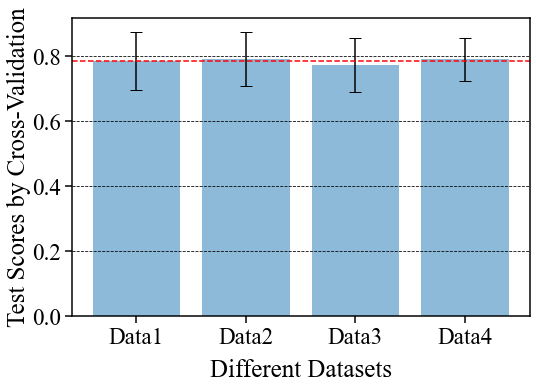

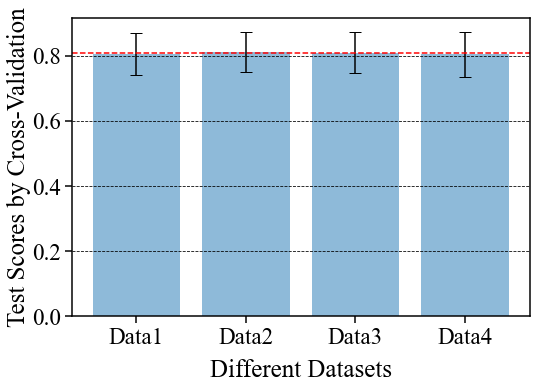

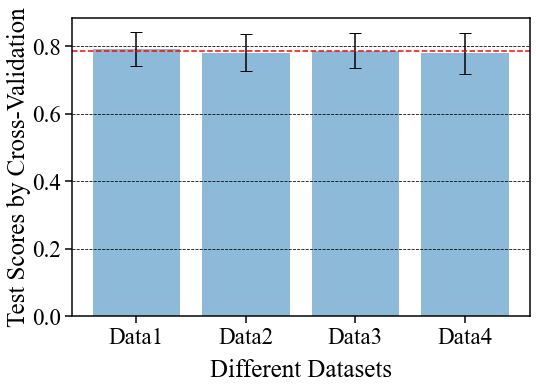

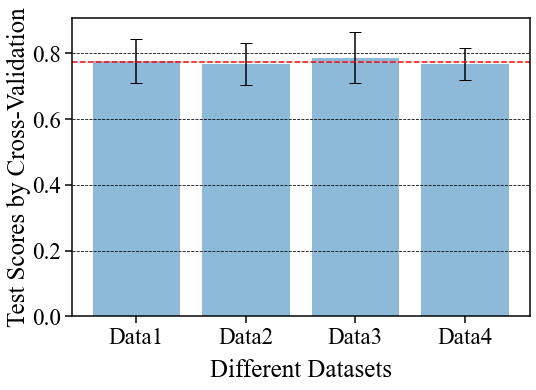

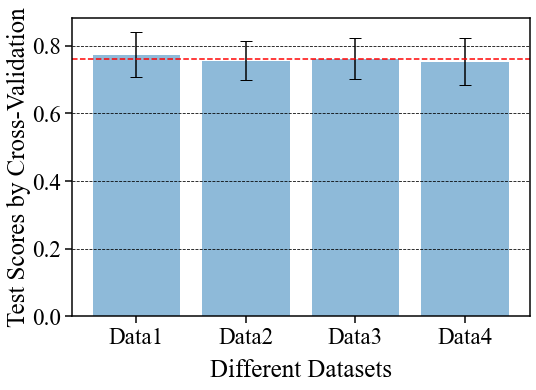

In [175]:
plot_result(RF_smote_split)
plot_result(LR_smote_split)
plot_result(KNN_smote_split)
plot_result(LGB_smote_split)
plot_result(XGB_smote_split)

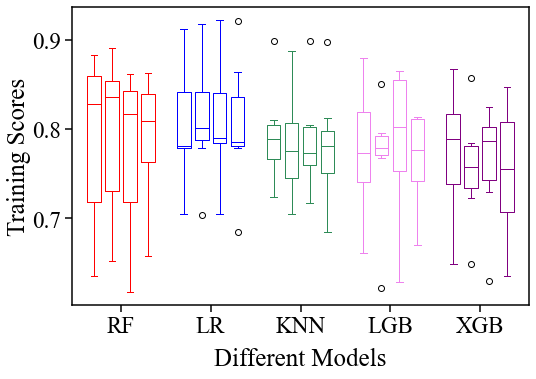

In [176]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
bp = ax.boxplot(RF_smote_split, positions=[1, 1.4, 1.8, 2.2], widths=0.3)
for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
    plt.setp(bp[item], color='red')
bp = ax.boxplot(LR_smote_split, positions=[3, 3.4, 3.8, 4.2], widths=0.3)
for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
    plt.setp(bp[item], color='blue')
bp = ax.boxplot(KNN_smote_split, positions=[5, 5.4, 5.8, 6.2], widths=0.3)
for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
    plt.setp(bp[item], color='seagreen')
bp = ax.boxplot(LGB_smote_split, positions=[7, 7.4, 7.8, 8.2], widths=0.3)
for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
    plt.setp(bp[item], color='violet')
bp = ax.boxplot(XGB_smote_split, positions=[9, 9.4, 9.8, 10.2], widths=0.3)
for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
    plt.setp(bp[item], color='purple')
    
ax.set_xticklabels(['RF', 'LR', 'KNN', 'LGB', 'XGB'])
ax.set_xticks([1.6, 3.6, 5.6, 7.6, 9.6])

ax.set_xlabel('Different Models', fontsize=25, fontname='times new roman', labelpad=10)
ax.set_ylabel('Training Scores', fontsize=25, fontname='times new roman', labelpad=1)
ax.tick_params(axis='both', length=7, labelsize=23, width=1.5, color='black')
ax.spines["top"].set_linewidth(1.5)
ax.spines["bottom"].set_linewidth(1.5)
ax.spines["left"].set_linewidth(1.5)
ax.spines["right"].set_linewidth(1.5)

xlabels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('times new roman') for label in xlabels]
plt.subplots_adjust(left=0.105, right=0.9, top=0.95, bottom=0.12)

In [177]:
def collect_roc_results(ytest, model_results):
    results = []
    for i in range(4):
        roc = auc_ROC(ytest, model_results[i])
        results.append(roc)
    return results

def collect_pr_results(ytest, model_results):
    results = []
    for i in range(4):
        pr = auc_PR(ytest, model_results[i])
        results.append(pr)
    return results

SMOTE_ROC = {}
SMOTE_PR = {}
#roc area
SMOTE_ROC['RF'] = collect_roc_results(y_test, RF_smote_results)
SMOTE_ROC['LR'] = collect_roc_results(y_test, LR_smote_results)
SMOTE_ROC['KNN'] = collect_roc_results(y_test, KNN_smote_results)
SMOTE_ROC['LGB'] = collect_roc_results(y_test, LGB_smote_results)
SMOTE_ROC['XGB'] = collect_roc_results(y_test, XGB_smote_results)
SMOTE_ROC['Stack'] = collect_roc_results(y_test, smote_stacking_results)
#pr area
SMOTE_PR['RF'] = collect_pr_results(y_test, RF_smote_results)
SMOTE_PR['LR'] = collect_pr_results(y_test, LR_smote_results)
SMOTE_PR['KNN'] = collect_pr_results(y_test, KNN_smote_results)
SMOTE_PR['LGB'] = collect_pr_results(y_test, LGB_smote_results)
SMOTE_PR['XGB'] = collect_pr_results(y_test, XGB_smote_results)
SMOTE_PR['Stack'] = collect_pr_results(y_test, smote_stacking_results)

In [178]:
def plot_roc_pr_score(roc_result, pr_result):
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    labels = np.array([1, 5, 9, 13, 17, 21])
    for ax in axes:
        ax.tick_params(axis='both', length=7, labelsize=23, width=1.5, color='black')
        ax.spines["top"].set_linewidth(1.5)
        ax.spines["bottom"].set_linewidth(1.5)
        ax.spines["left"].set_linewidth(1.5)
        ax.spines["right"].set_linewidth(1.5)

        xlabels = ax.get_xticklabels() + ax.get_yticklabels()
        [label.set_fontname('times new roman') for label in xlabels]
        plt.subplots_adjust(left=0.105, right=0.9, top=0.95, bottom=0.12)
        ax.set_xticks(labels)
        ax.set_xticklabels(['RF', 'LR', 'KNN', 'LGB', 'XGB', 'Stack'])
        
        ax.grid(axis='y', c='black', linestyle='--')
        
    axes[0].bar(labels - 0.75, roc_result[:, 0], width=0.5, edgecolor='black', hatch='/', label='Data 1')
    axes[0].bar(labels - 0.25, roc_result[:, 1], width=0.5, edgecolor='black', hatch='\\/', label='Data 2')
    axes[0].bar(labels + 0.25, roc_result[:, 2], width=0.5, edgecolor='black', hatch='///', label='Data 3')
    axes[0].bar(labels + 0.75, roc_result[:, 3], width=0.5, edgecolor='black', hatch='\\', label='Data 4')
    axes[0].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    axes[0].set_yticklabels([0, 20, 40, 60, 80, 100])
    axes[0].set_xlabel('Different Models with SMOTE', fontsize=25, fontname='times new roman', labelpad=10)
    axes[0].set_ylabel('AUC for ROC Curve (%)', fontsize=25, fontname='times new roman', labelpad=1)
    axes[0].legend(loc='upper center', frameon=False, prop={'family':'Times new roman', 'size':16}, ncol=2)
    
    axes[1].bar(labels - 0.75, pr_result[:, 0], width=0.5, edgecolor='black', hatch='/', label='Data 1')
    axes[1].bar(labels - 0.25, pr_result[:, 1], width=0.5, edgecolor='black', hatch='\\/', label='Data 2')
    axes[1].bar(labels + 0.25, pr_result[:, 2], width=0.5, edgecolor='black', hatch='///', label='Data 3')
    axes[1].bar(labels + 0.75, pr_result[:, 3], width=0.5, edgecolor='black', hatch='\\', label='Data 4')
    axes[1].set_yticks([0.0, 0.15, 0.30, 0.45])
    axes[1].set_yticklabels([0, 15, 30, 45])
    axes[1].set_xlabel('Different Models with SMOTE', fontsize=25, fontname='times new roman', labelpad=10)
    axes[1].set_ylabel('AUC for PR Curve (%)', fontsize=25, fontname='times new roman', labelpad=1)
    axes[1].legend(loc='upper center', frameon=False, prop={'family':'Times new roman', 'size':16}, ncol=2)

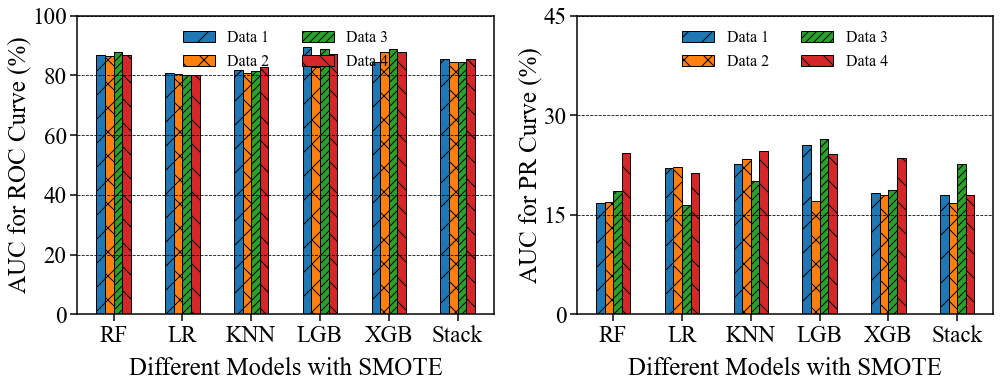

In [179]:
smote_roc_result = np.array([SMOTE_ROC['RF'], 
                             SMOTE_ROC['LR'],
                             SMOTE_ROC['KNN'],
                             SMOTE_ROC['LGB'],
                             SMOTE_ROC['XGB'],
                             SMOTE_ROC['Stack']])

smote_pr_result = np.array([SMOTE_PR['RF'], 
                            SMOTE_PR['LR'],
                            SMOTE_PR['KNN'],
                            SMOTE_PR['LGB'],
                            SMOTE_PR['XGB'],
                            SMOTE_PR['Stack']])
plot_roc_pr_score(smote_roc_result, smote_pr_result)

In [67]:
smote_roc_result

array([[0.86965706, 0.8665507 , 0.86505964, 0.87152087],
       [0.82492545, 0.81585487, 0.77497515, 0.80666004],
       [0.80535537, 0.78429423, 0.80740557, 0.81218936],
       [0.86630219, 0.75627485, 0.87301193, 0.8556163 ],
       [0.87164513, 0.88071571, 0.88469185, 0.83026839],
       [0.85586481, 0.85275845, 0.85250994, 0.84691849]])

In [68]:
smote_pr_result

array([[0.16813008, 0.228958  , 0.16833976, 0.227417  ],
       [0.15811563, 0.13928929, 0.1103878 , 0.12114708],
       [0.21427983, 0.23110322, 0.13205213, 0.16431197],
       [0.15820614, 0.11093043, 0.15521739, 0.22335293],
       [0.2792864 , 0.27332063, 0.20112035, 0.20404642],
       [0.16399158, 0.21904944, 0.23570016, 0.2056434 ]])

# undersampling technique

In [180]:
print('-------------------------RF under models-------------------------')
RF_under_grids, RF_under_results = make_grid(Final_Train_Data, Final_Test_Data, clf_RF, RF_parameters, y_train, False)
print('-------------------------LR under models-------------------------')
LR_under_grids, LR_under_results = make_grid(Final_Train_Data, Final_Test_Data, clf_LR, LR_parameters, y_train, False)
print('-------------------------KNN under models-------------------------')
KNN_under_grids, KNN_under_results = make_grid(Final_Train_Data, Final_Test_Data, clf_KNN, KNN_parameters, y_train, False)
print('-------------------------LGB under models-------------------------')
LGB_under_grids, LGB_under_results = make_grid(Final_Train_Data, Final_Test_Data, clf_LGB, LGB_parameters, y_train, False)
print('-------------------------XGB under models-------------------------')
XGB_sunder_grids, XGB_under_results = make_grid(Final_Train_Data, Final_Test_Data, clf_XGB, XGB_parameters, y_train, False)

-------------------------RF under models-------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.5min finished


-------------------------LR under models-------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   49.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   52.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   54.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   58.8s finished


-------------------------KNN under models-------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   53.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   55.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   57.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.1min finished


-------------------------LGB under models-------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   53.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   51.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   52.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   58.8s finished


-------------------------XGB under models-------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   53.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   52.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   52.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.0min finished


In [181]:
under_stacking_results = []
#predicting using stacking classifier
for i in range(0, 4):
    stacking_estimators = [
        ('rf', RF_under_grids[i].best_estimator_),
        ('lr', LR_under_grids[i].best_estimator_),
        ('knn', KNN_under_grids[i].best_estimator_),
        ('lgb', LGB_under_grids[i].best_estimator_),
        ('xgb', XGB_sunder_grids[i].best_estimator_)
    ]
    #make a stackingclassifier
    clf = StackingClassifier(estimators = stacking_estimators, final_estimator = LogisticRegression(random_state=1))
    #fit using the stackingclassifier
    clf.fit(Final_Train_Data[i], y_train)
    result = clf.predict_proba(Final_Test_Data[i])
    under_stacking_results.append(result)

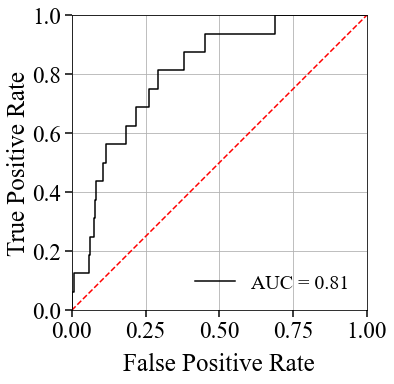

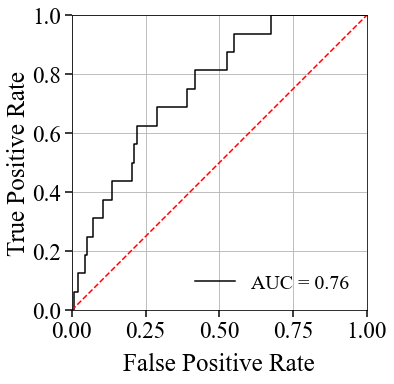

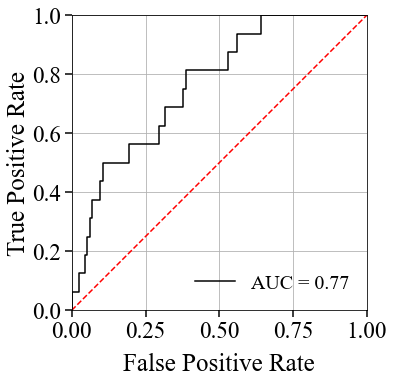

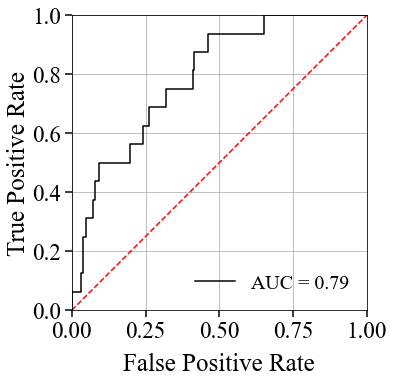

In [76]:
plot_roc(y_test, under_stacking_results[0][:, 1])
plot_roc(y_test, under_stacking_results[1][:, 1])
plot_roc(y_test, under_stacking_results[2][:, 1])
plot_roc(y_test, under_stacking_results[3][:, 1])

In [ ]:
plot_cm(y_test, under_stacking_results[0][:, 1], 0.05)
plot_cm(y_test, under_stacking_results[1][:, 1], 0.124)
plot_cm(y_test, under_stacking_results[2][:, 1], 0.118)
plot_cm(y_test, under_stacking_results[3][:, 1], 0.1212)

In [182]:
#calculate the split mean for every models under undersampling 
RF_under_split = calculate_split_mean(RF_under_grids)
LR_under_split = calculate_split_mean(LR_under_grids)
KNN_under_split = calculate_split_mean(KNN_under_grids)
LGB_under_split = calculate_split_mean(LGB_under_grids)
XGB_under_split = calculate_split_mean(XGB_sunder_grids)

0.799880749112394 0.06884157754107095
0.8002134319863404 0.06939447838341843
0.801153916081705 0.05590537899363712
0.8030935780686776 0.05025632484058084
0.7556802269380528 0.07135020334248547
0.7874159339319109 0.06921863453927427
0.7609545754999653 0.06704321762799394
0.7625970446042201 0.06904478720399879
0.7628585854992728 0.04693969386930714
0.7535620415164738 0.05150714468817743
0.7586207466054151 0.04769429528511432
0.7345225532111915 0.04600282297086614
0.7675241070863937 0.06363202555658089
0.7490520486082879 0.08184697039193027
0.762648197836018 0.06313994767586405
0.7687729179025896 0.061753533162340744
0.7315205730366516 0.05403175974463837
0.7365308042207586 0.06296186192380235
0.7338552677046916 0.06089594210308047
0.7565071064946561 0.046701299322665146


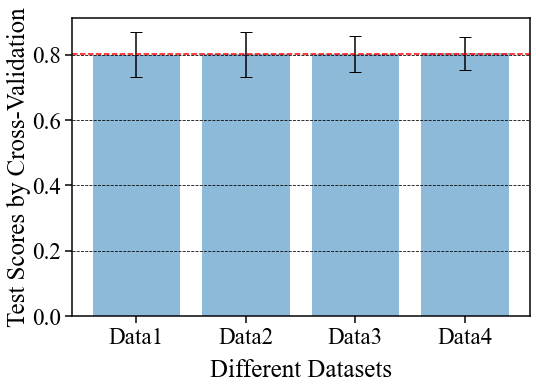

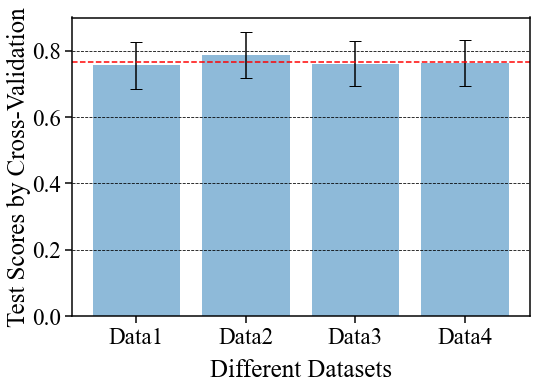

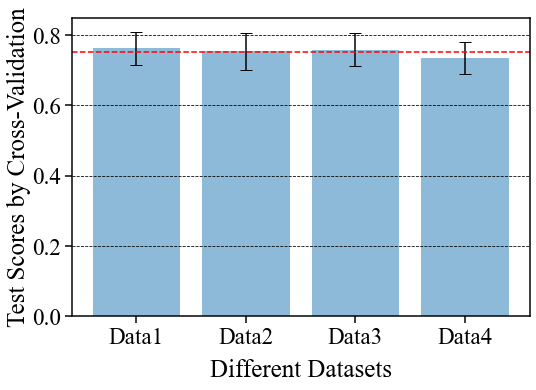

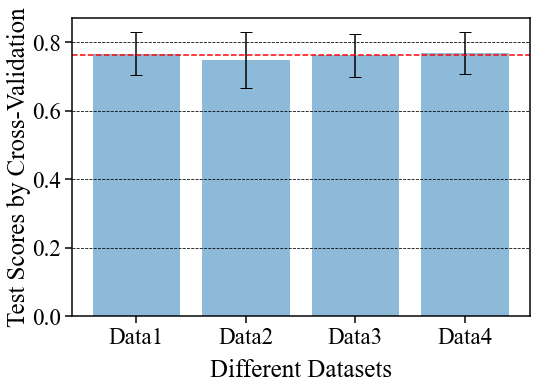

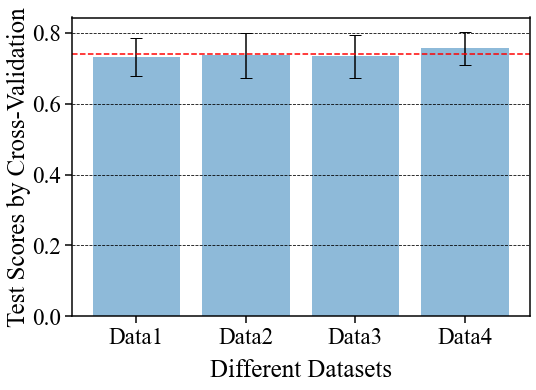

In [183]:
plot_result(RF_under_split)
plot_result(LR_under_split)
plot_result(KNN_under_split)
plot_result(LGB_under_split)
plot_result(XGB_under_split)

In [184]:
Under_ROC = {}
Under_PR = {}
#roc area
Under_ROC['RF'] = collect_roc_results(y_test, RF_under_results)
Under_ROC['LR'] = collect_roc_results(y_test, LR_under_results)
Under_ROC['KNN'] = collect_roc_results(y_test, KNN_under_results)
Under_ROC['LGB'] = collect_roc_results(y_test, LGB_under_results)
Under_ROC['XGB'] = collect_roc_results(y_test, XGB_under_results)
Under_ROC['Stack'] = collect_roc_results(y_test, under_stacking_results)
#pr area
Under_PR['RF'] = collect_pr_results(y_test, RF_under_results)
Under_PR['LR'] = collect_pr_results(y_test, LR_under_results)
Under_PR['KNN'] = collect_pr_results(y_test, KNN_under_results)
Under_PR['LGB'] = collect_pr_results(y_test, LGB_under_results)
Under_PR['XGB'] = collect_pr_results(y_test, XGB_under_results)
Under_PR['Stack'] = collect_pr_results(y_test, under_stacking_results)

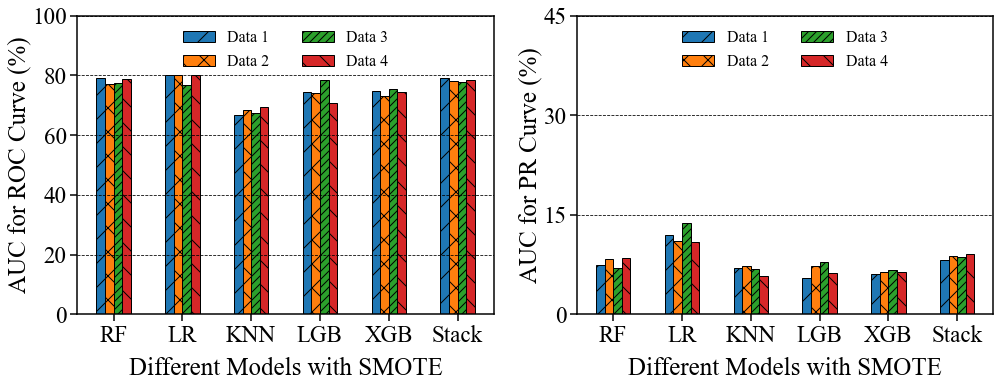

In [185]:
under_roc_result = np.array([Under_ROC['RF'], 
                             Under_ROC['LR'],
                             Under_ROC['KNN'],
                             Under_ROC['LGB'],
                             Under_ROC['XGB'],
                             Under_ROC['Stack']])

under_pr_result = np.array([Under_PR['RF'], 
                            Under_PR['LR'],
                            Under_PR['KNN'],
                            Under_PR['LGB'],
                            Under_PR['XGB'],
                            Under_PR['Stack']])
plot_roc_pr_score(under_roc_result, under_pr_result)

In [186]:
under_roc_result

array([[0.79187376, 0.77137177, 0.77311133, 0.7860338 ],
       [0.80206262, 0.79957753, 0.76838966, 0.7999503 ],
       [0.66755716, 0.68358598, 0.67333499, 0.69371272],
       [0.74552684, 0.73993539, 0.784667  , 0.70632455],
       [0.74850895, 0.73086481, 0.75323062, 0.7445328 ],
       [0.7903827 , 0.7805666 , 0.77696322, 0.78454274]])

In [187]:
under_pr_result

array([[0.07454376, 0.08353216, 0.06911987, 0.08416635],
       [0.11889874, 0.11018548, 0.13689759, 0.10927452],
       [0.06920694, 0.07232762, 0.0683035 , 0.05780605],
       [0.05521169, 0.07334807, 0.07919701, 0.0614501 ],
       [0.06015509, 0.06361358, 0.06631034, 0.0642662 ],
       [0.08228462, 0.0876071 , 0.08653814, 0.09057817]])

# Cost-sensitive model

In [1389]:
# define new cost function
def _positive_sigmoid(x):
    return 1 / (1 + np.exp(-x))

def _negative_sigmoid(x):
    exp = np.exp(x)
    return exp / (exp + 1)

def sigmoid(x):
    positive = x >= 0
    negative = ~positive
    result = np.empty_like(x)
    result[positive] = _positive_sigmoid(x[positive])
    result[negative] = _negative_sigmoid(x[negative])
    return result

def _positive_softplus(x):
    return x + np.log1p(np.exp(-x))

def _negative_softplus(x):
    return np.log1p(np.exp(x))

def softplus(x):
    positive = x >= 0
    negative = ~positive
    result = np.empty_like(x)
    result[positive] = _positive_softplus(x[positive])
    result[negative] = _negative_softplus(x[negative])
    return result

def bce_loss(z, data):
    investment = np.round(data.get_weight()/100000, 2)
    period = (data.get_weight()/1000 - (data.get_weight()/1000).astype(int)) * 1000
    
    C1 =  0.314 * investment
    C2 = 0
    C3 = 0
    C4 = (1-1/np.power(1.07, period)) * 0.99 / 7 * investment

    t = data.get_label()
    y = sigmoid(z)
    grad = y * ((C1 + C2 - C3 - C4) * t + C3 + C4) + (C3 - C1) * t - C3
    hess = y * ((C1 + C2 - C3 - C4) * t + C3 + C4) * (1 - y)
    return grad, hess

# corresponding to CFN, CTP, CTN, and CFP
def bce_eval(z, data):
    investment = np.round(data.get_weight()/100000, 2)
    period = (data.get_weight()/1000 - (data.get_weight()/1000).astype(int)) * 1000
    
    C1 =  0.314 * investment
    C2 = 0
    C3 = 0
    C4 = (1-1/np.power(1.07, period)) * 0.99 / 7 * investment
    
    t = data.get_label()
    loss = softplus(-z) * ((C1 - C3) * t + C3) + softplus(z) * ((C2 - C4) * t + C4)
    return 'bce', loss.mean(), False

In [1390]:
# y_pred is in probability
def calculate_cost(y_test, y_pred, weight, threshold):
    true_value = y_test.copy()
    tt = pd.DataFrame(data = {'real': true_value, 'predict': (y_pred > threshold)})
    FP = tt[(tt['real'] == 0) & (tt['predict'] == True)].index.values
    FN = tt[(tt['real'] == 1) & (tt['predict'] == False)].index.values
    TP = tt[(tt['real'] == 1) & (tt['predict'] == True)].index.values
    TN = tt[(tt['real'] == 0) & (tt['predict'] == False)].index.values
    
    cost_FP = [weight.loc[a] for a in FP]
    cost_FN = [weight.loc[a] for a in FN]
    
    return cost_FP, cost_FN   

In [1391]:
def Asymmetric_Predictor(train, test, y_train, n, balance=False):
    numerical_index = train.select_dtypes(include=['int64', 'float64']).columns
    ct_no_experience = [('num', RobustScaler(), numerical_index)]
    col_transform = ColumnTransformer(remainder='passthrough', transformers=ct_no_experience)
    #PCA, 40 best for transport
    pca = PCA(n_components=n, random_state=13)
        
    #smote
    sampling = SMOTE(sampling_strategy='minority',random_state=0)
        
    pipe = Imbalanced_Pipe()
    
    new_train = pipe.fit_transform(train)
    new_test = pipe.transform(test)
    
    train_investment = round(new_train['investment'], 2)
    train_period = new_train['period'].apply(lambda x: int(x))
    train_weight = train_investment * 100000 + train_period
    
    test_investment = round(new_test['investment'], 2)
    test_period = new_test['period'].apply(lambda x: int(x))
    test_weight = test_investment * 100000 + test_period
    
    new_train = col_transform.fit_transform(new_train)
    new_test = col_transform.transform(new_test)
    
    if balance:
        new_train, y_train = sampling.fit_resample(new_train, y_train)
    
    new_train = pca.fit_transform(new_train)
    new_test = pca.transform(new_test)
    return new_train, new_test, train_weight, test_weight, y_train

In [1392]:
Asy_train = []
Asy_test = []
Asy_train_weight = []
Asy_test_weight = []
Asy_y_train = []
for train, test in zip(Final_Train_Data, Final_Test_Data):
    asy_train, asy_test, asy_train_weight, asy_test_weight, asy_y_train = Asymmetric_Predictor(train, test, y_train, 30)
    Asy_train.append(asy_train)
    Asy_test.append(asy_test)
    Asy_train_weight.append(asy_train_weight)
    Asy_test_weight.append(asy_test_weight)
    Asy_y_train.append(asy_y_train)

# LGB cost-sensitive

In [1393]:
#get the cost-sensitive result of lgb
Lgb_cost_results = []
for i in range(4):
    train = Asy_train[i]
    test = Asy_test[i]
    weight = Asy_train_weight[i]
    lgb_train = lgb.Dataset(data = train, label = y_train, weight = weight)
    lgb_params = {
        'random_seed': 2
    }
    
    model = lgb.train(lgb_params,
                      lgb_train,
                      fobj=bce_loss,
                      feval=bce_eval)
    y_pred = sigmoid(model.predict(test))
    Lgb_cost_results.append(y_pred)

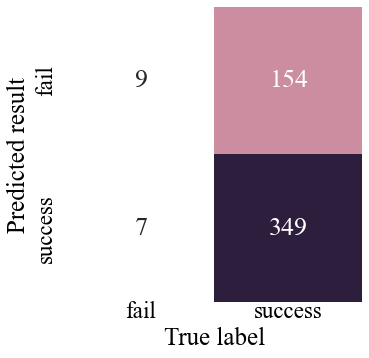

In [1405]:
plot_cm(y_test, Xgb_cost_results[1], 0.06)

# XGB cost-sensitive

In [1400]:
#xgb cost-sensitive
Xgb_cost_results = []
for i in range(4):
    train = Asy_train[i]
    test = Asy_test[i]
    weight = Asy_train_weight[i]
    xgb_train = xgb.DMatrix(data = train, label = y_train, weight = weight)
    xgb_test = xgb.DMatrix(data = test)
    
    xgb_params = {'tree_method': 'hist', 
                  'seed': 1,
                  'disable_default_eval_metric': 1
                 }
    
    model = xgb.train(params = xgb_params,
                  dtrain = xgb_train,
                  obj=bce_loss,
                  feval=bce_eval)
    
    y_pred = sigmoid(model.predict(xgb_test))
    Xgb_cost_results.append(y_pred)

In [338]:
#Deep learning with Keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
import keras.backend as K

Using TensorFlow backend.


# Regular ANN

In [1358]:
#get the balanced data first for ann
Balanced_ann_train = []
Balanced_ann_test = []
Balanced_ann_train_weight = []
Balanced_ann_test_weight = []
Balanced_y_train = []
for train, test in zip(Final_Train_Data, Final_Test_Data):
    balanced_ann_train, balanced_ann_test, balanced_ann_train_weight, balanced_ann_test_weight, balanced_y_train = Asymmetric_Predictor(train, test, y_train, 30, True)
    Balanced_ann_train.append(balanced_ann_train)
    Balanced_ann_test.append(balanced_ann_test)
    Balanced_ann_train_weight.append(balanced_ann_train_weight)
    Balanced_ann_test_weight.append(balanced_ann_test_weight)
    Balanced_y_train.append(balanced_y_train)

In [1359]:
SEED = 123
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
# regular ann model, use the balanced database-Data 1
Regular_ann_results = []

regular_ann_model1 = Sequential()
regular_ann_model1.add(Dense(50, input_dim=30, activation='relu'))
regular_ann_model1.add(Dense(1, activation='sigmoid'))
#begin to compile model
regular_ann_model1.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#begin to fit the model
history1 = regular_ann_model1.fit(Balanced_ann_train[0], Balanced_y_train[0], epochs=100, batch_size=10)
#begin to predict
result1 = regular_ann_model1.predict_proba(Balanced_ann_test[0])
Regular_ann_results.append(result1)

# regular ann model, use the balanced database-Data 2
regular_ann_model2 = Sequential()
regular_ann_model2.add(Dense(50, input_dim=30, activation='relu'))
regular_ann_model2.add(Dense(1, activation='sigmoid'))
#begin to compile model
regular_ann_model2.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#begin to fit the model
history2 = regular_ann_model2.fit(Balanced_ann_train[1], Balanced_y_train[1], epochs=100, batch_size=10)
#begin to predict
result2 = regular_ann_model2.predict_proba(Balanced_ann_test[1])
Regular_ann_results.append(result2)

# regular ann model, use the balanced database-Data 3
regular_ann_model3 = Sequential()
regular_ann_model3.add(Dense(50, input_dim=30, activation='relu'))
regular_ann_model3.add(Dense(1, activation='sigmoid'))
#begin to compile model
regular_ann_model3.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#begin to fit the model
history3 = regular_ann_model3.fit(Balanced_ann_train[2], Balanced_y_train[2], epochs=100, batch_size=10)
#begin to predict
result3 = regular_ann_model3.predict_proba(Balanced_ann_test[2])
Regular_ann_results.append(result3)

# regular ann model, use the balanced database-Data 4
regular_ann_model4 = Sequential()
regular_ann_model4.add(Dense(50, input_dim=30, activation='relu'))
regular_ann_model2.add(Dense(20, activation='relu'))
regular_ann_model4.add(Dense(1, activation='sigmoid'))
#begin to compile model
regular_ann_model4.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#begin to fit the model
history4 = regular_ann_model4.fit(Balanced_ann_train[3], Balanced_y_train[3], epochs=100, batch_size=10)
#begin to predict
result4 = regular_ann_model4.predict_proba(Balanced_ann_test[3])
Regular_ann_results.append(result4)

Epoch 1/100
4020/4020 [==============================] - 0s 104us/step - loss: 0.5409 - accuracy: 0.7585
Epoch 2/100
4020/4020 [==============================] - 0s 84us/step - loss: 0.3574 - accuracy: 0.8570
Epoch 3/100
4020/4020 [==============================] - 0s 85us/step - loss: 0.3202 - accuracy: 0.8701
Epoch 4/100
4020/4020 [==============================] - 0s 112us/step - loss: 0.2946 - accuracy: 0.8826
Epoch 5/100
4020/4020 [==============================] - 0s 95us/step - loss: 0.2756 - accuracy: 0.8898
Epoch 6/100
4020/4020 [==============================] - 0s 87us/step - loss: 0.2589 - accuracy: 0.9002
Epoch 7/100
4020/4020 [==============================] - 0s 84us/step - loss: 0.2428 - accuracy: 0.9144
Epoch 8/100
4020/4020 [==============================] - 0s 91us/step - loss: 0.2256 - accuracy: 0.9236
Epoch 9/100
4020/4020 [==============================] - 0s 88us/step - loss: 0.2117 - accuracy: 0.9229
Epoch 10/100
4020/4020 [==============================] - 0s 9

4020/4020 [==============================] - 0s 100us/step - loss: 0.0264 - accuracy: 0.9923
Epoch 79/100
4020/4020 [==============================] - 0s 97us/step - loss: 0.0205 - accuracy: 0.9943
Epoch 80/100
4020/4020 [==============================] - 0s 95us/step - loss: 0.0206 - accuracy: 0.9945
Epoch 81/100
4020/4020 [==============================] - 0s 84us/step - loss: 0.0205 - accuracy: 0.9928
Epoch 82/100
4020/4020 [==============================] - 0s 86us/step - loss: 0.0206 - accuracy: 0.9930
Epoch 83/100
4020/4020 [==============================] - 0s 94us/step - loss: 0.0229 - accuracy: 0.9918
Epoch 84/100
4020/4020 [==============================] - 0s 104us/step - loss: 0.0204 - accuracy: 0.9925
Epoch 85/100
4020/4020 [==============================] - 0s 108us/step - loss: 0.0240 - accuracy: 0.9928
Epoch 86/100
4020/4020 [==============================] - 0s 88us/step - loss: 0.0168 - accuracy: 0.9955
Epoch 87/100
4020/4020 [==============================] - 0s 98us

4020/4020 [==============================] - 0s 92us/step - loss: 0.0264 - accuracy: 0.9923
Epoch 57/100
4020/4020 [==============================] - 0s 95us/step - loss: 0.0263 - accuracy: 0.9925
Epoch 58/100
4020/4020 [==============================] - 0s 100us/step - loss: 0.0301 - accuracy: 0.9920
Epoch 59/100
4020/4020 [==============================] - 0s 83us/step - loss: 0.0249 - accuracy: 0.9930
Epoch 60/100
4020/4020 [==============================] - 0s 87us/step - loss: 0.0263 - accuracy: 0.9935
Epoch 61/100
4020/4020 [==============================] - 0s 85us/step - loss: 0.0253 - accuracy: 0.9918
Epoch 62/100
4020/4020 [==============================] - 0s 86us/step - loss: 0.0244 - accuracy: 0.9923
Epoch 63/100
4020/4020 [==============================] - 0s 91us/step - loss: 0.0259 - accuracy: 0.9913
Epoch 64/100
4020/4020 [==============================] - 0s 90us/step - loss: 0.0248 - accuracy: 0.9930
Epoch 65/100
4020/4020 [==============================] - 0s 94us/s

4020/4020 [==============================] - 0s 89us/step - loss: 0.0640 - accuracy: 0.9813
Epoch 35/100
4020/4020 [==============================] - 0s 93us/step - loss: 0.0639 - accuracy: 0.9821
Epoch 36/100
4020/4020 [==============================] - 0s 87us/step - loss: 0.0624 - accuracy: 0.9806
Epoch 37/100
4020/4020 [==============================] - 0s 92us/step - loss: 0.0565 - accuracy: 0.9853
Epoch 38/100
4020/4020 [==============================] - 0s 91us/step - loss: 0.0591 - accuracy: 0.9828
Epoch 39/100
4020/4020 [==============================] - 0s 112us/step - loss: 0.0579 - accuracy: 0.9841
Epoch 40/100
4020/4020 [==============================] - 0s 109us/step - loss: 0.0535 - accuracy: 0.9853
Epoch 41/100
4020/4020 [==============================] - 0s 101us/step - loss: 0.0529 - accuracy: 0.9861
Epoch 42/100
4020/4020 [==============================] - 0s 98us/step - loss: 0.0483 - accuracy: 0.9873
Epoch 43/100
4020/4020 [==============================] - 0s 93us

Epoch 12/100
4020/4020 [==============================] - 0s 100us/step - loss: 0.1468 - accuracy: 0.9560
Epoch 13/100
4020/4020 [==============================] - 0s 91us/step - loss: 0.1336 - accuracy: 0.9592
Epoch 14/100
4020/4020 [==============================] - 0s 88us/step - loss: 0.1251 - accuracy: 0.9644
Epoch 15/100
4020/4020 [==============================] - 0s 92us/step - loss: 0.1146 - accuracy: 0.9669
Epoch 16/100
4020/4020 [==============================] - 0s 86us/step - loss: 0.1053 - accuracy: 0.9704
Epoch 17/100
4020/4020 [==============================] - 0s 91us/step - loss: 0.0995 - accuracy: 0.9729
Epoch 18/100
4020/4020 [==============================] - 0s 94us/step - loss: 0.0933 - accuracy: 0.9741
Epoch 19/100
4020/4020 [==============================] - 0s 85us/step - loss: 0.0848 - accuracy: 0.9776
Epoch 20/100
4020/4020 [==============================] - 0s 87us/step - loss: 0.0782 - accuracy: 0.9784
Epoch 21/100
4020/4020 [==============================

4020/4020 [==============================] - 0s 108us/step - loss: 0.0132 - accuracy: 0.9953
Epoch 90/100
4020/4020 [==============================] - 1s 138us/step - loss: 0.0146 - accuracy: 0.9953
Epoch 91/100
4020/4020 [==============================] - 0s 112us/step - loss: 0.0181 - accuracy: 0.9933
Epoch 92/100
4020/4020 [==============================] - 0s 91us/step - loss: 0.0144 - accuracy: 0.9958
Epoch 93/100
4020/4020 [==============================] - 0s 111us/step - loss: 0.0150 - accuracy: 0.9950
Epoch 94/100
4020/4020 [==============================] - 0s 106us/step - loss: 0.0140 - accuracy: 0.9955
Epoch 95/100
4020/4020 [==============================] - 0s 87us/step - loss: 0.0137 - accuracy: 0.9950
Epoch 96/100
4020/4020 [==============================] - 0s 92us/step - loss: 0.0141 - accuracy: 0.9948
Epoch 97/100
4020/4020 [==============================] - 0s 91us/step - loss: 0.0133 - accuracy: 0.9963
Epoch 98/100
4020/4020 [==============================] - 0s 10

# ANN cost-sensitivity 

In [1388]:
#define the new cost function for ann
def custom_loss(c_TP, c_FP, c_FN, c_TN):
    def loss_function(y_true, y_pred, c_TP=c_TP, c_FP=c_FP, c_FN=c_FN, c_TN=c_TN):
        h = K.ones_like(y_pred)
        c_TP = c_TP * h
        c_TN = c_TN * h
        cost = y_true * (K.log(y_pred) * c_FN + K.log(1.0 - y_pred) * c_TP) + (1.0 - y_true) * (K.log(1.0 - y_pred) * c_FP + K.log(y_pred) * c_TN)
        return -K.mean(cost, axis=-1)
    return loss_function
#define the example-based cost, if TP, then wasting 10% development fee

investment = round(Balanced_ann_train_weight[1]/100000, 2)
period = (Balanced_ann_train_weight[1]/1000 - (Balanced_ann_train_weight[1]/1000).apply(lambda x: int(x))) * 1000
    
cost_TP = 0
cost_FP = (1-1/np.power(1.07, period)) * 0.99 / 7 * investment
cost_FN = 0.314 * investment
cost_TN = 0
#get the balanced data first for ann
Cost_ann_train = []
Cost_ann_test = []
Cost_ann_train_weight = []
Cost_ann_test_weight = []
Cost_y_train = []
for train, test in zip(Final_Train_Data, Final_Test_Data):
    cost_ann_train, cost_ann_test, cost_ann_train_weight, cost_ann_test_weight, cost_y_train = Asymmetric_Predictor(train, test, y_train, 30, False)
    Cost_ann_train.append(cost_ann_train)
    Cost_ann_test.append(cost_ann_test)
    Cost_ann_train_weight.append(cost_ann_train_weight)
    Cost_ann_test_weight.append(cost_ann_test_weight)
    Cost_y_train.append(cost_y_train)

In [1361]:
# cost ann model, use the balanced database-Data 1
Cost_ann_results = []
cost_ann_model1 = Sequential()
cost_ann_model1.add(Dense(50, input_dim=30, activation='tanh'))
cost_ann_model1.add(Dense(20, activation='tanh'))
cost_ann_model1.add(Dense(1, activation='sigmoid'))
#begin to compile the model
cost_ann_model1.compile(loss = custom_loss(cost_TP, cost_FP, cost_FN, cost_TN), optimizer='sgd', metrics=['accuracy'])
cost_ann_model1.fit(Cost_ann_train[0], Cost_y_train[0], epochs=100, batch_size=15)
#begin to predict
result1 = cost_ann_model1.predict_proba(Cost_ann_test[0])
Cost_ann_results.append(result1)

# cost ann model, use the balanced database-Data 2
cost_ann_model2 = Sequential()
cost_ann_model2.add(Dense(50, input_dim=30, activation='tanh'))
cost_ann_model2.add(Dense(20, activation='tanh'))
cost_ann_model2.add(Dense(1, activation='sigmoid'))
#begin to compile the model
cost_ann_model2.compile(loss = custom_loss(cost_TP, cost_FP, cost_FN, cost_TN), optimizer='sgd', metrics=['accuracy'])
cost_ann_model2.fit(Cost_ann_train[1], Cost_y_train[1], epochs=100, batch_size=15)
#begin to predict
result2 = cost_ann_model2.predict_proba(Cost_ann_test[1])
Cost_ann_results.append(result2)

# cost ann model, use the balanced database-Data 3
cost_ann_model3 = Sequential()
cost_ann_model3.add(Dense(50, input_dim=30, activation='tanh'))
cost_ann_model3.add(Dense(20, activation='tanh'))
cost_ann_model3.add(Dense(1, activation='sigmoid'))
#begin to compile the model
cost_ann_model3.compile(loss = custom_loss(cost_TP, cost_FP, cost_FN, cost_TN), optimizer='sgd', metrics=['accuracy'])
cost_ann_model3.fit(Cost_ann_train[2], Cost_y_train[2], epochs=100, batch_size=15)
#begin to predict
result3 = cost_ann_model3.predict_proba(Cost_ann_test[2])
Cost_ann_results.append(result3)

# cost ann model, use the balanced database-Data 4
cost_ann_model4 = Sequential()
cost_ann_model4.add(Dense(50, input_dim=30, activation='tanh'))
cost_ann_model4.add(Dense(20, activation='tanh'))
cost_ann_model4.add(Dense(1, activation='sigmoid'))
#begin to compile the model
cost_ann_model4.compile(loss = custom_loss(cost_TP, cost_FP, cost_FN, cost_TN), optimizer='sgd', metrics=['accuracy'])
cost_ann_model4.fit(Cost_ann_train[3], Cost_y_train[3], epochs=100, batch_size=15)
#begin to predict
result4 = cost_ann_model4.predict_proba(Cost_ann_test[3])
Cost_ann_results.append(result4)

Epoch 1/100
2076/2076 [==============================] - 0s 163us/step - loss: 11.1394 - accuracy: 0.9489
Epoch 2/100
2076/2076 [==============================] - 0s 106us/step - loss: 9.2148 - accuracy: 0.9677
Epoch 3/100
2076/2076 [==============================] - 0s 99us/step - loss: 8.9283 - accuracy: 0.9677
Epoch 4/100
2076/2076 [==============================] - 0s 85us/step - loss: 8.3978 - accuracy: 0.9687
Epoch 5/100
2076/2076 [==============================] - 0s 81us/step - loss: 8.7950 - accuracy: 0.9687
Epoch 6/100
2076/2076 [==============================] - 0s 97us/step - loss: 8.4312 - accuracy: 0.9677
Epoch 7/100
2076/2076 [==============================] - 0s 109us/step - loss: 8.4151 - accuracy: 0.9682
Epoch 8/100
2076/2076 [==============================] - 0s 117us/step - loss: 8.5719 - accuracy: 0.9677
Epoch 9/100
2076/2076 [==============================] - 0s 115us/step - loss: 8.2826 - accuracy: 0.9672
Epoch 10/100
2076/2076 [==============================] - 

2076/2076 [==============================] - 0s 80us/step - loss: 7.1740 - accuracy: 0.9721 0s - loss: 7.1488 - accuracy: 0.97
Epoch 79/100
2076/2076 [==============================] - 0s 83us/step - loss: 6.7228 - accuracy: 0.9735
Epoch 80/100
2076/2076 [==============================] - 0s 79us/step - loss: 6.7418 - accuracy: 0.9740
Epoch 81/100
2076/2076 [==============================] - 0s 80us/step - loss: 6.9391 - accuracy: 0.9725
Epoch 82/100
2076/2076 [==============================] - 0s 77us/step - loss: 6.8881 - accuracy: 0.9735
Epoch 83/100
2076/2076 [==============================] - 0s 79us/step - loss: 6.9686 - accuracy: 0.9725
Epoch 84/100
2076/2076 [==============================] - 0s 81us/step - loss: 7.4496 - accuracy: 0.9730
Epoch 85/100
2076/2076 [==============================] - 0s 84us/step - loss: 7.4403 - accuracy: 0.9730
Epoch 86/100
2076/2076 [==============================] - 0s 79us/step - loss: 7.5197 - accuracy: 0.9730
Epoch 87/100
2076/2076 [=========

2076/2076 [==============================] - 0s 90us/step - loss: 6.7155 - accuracy: 0.9716
Epoch 56/100
2076/2076 [==============================] - 0s 79us/step - loss: 6.8582 - accuracy: 0.9701
Epoch 57/100
2076/2076 [==============================] - 0s 79us/step - loss: 7.8496 - accuracy: 0.9682
Epoch 58/100
2076/2076 [==============================] - 0s 79us/step - loss: 7.2134 - accuracy: 0.9682
Epoch 59/100
2076/2076 [==============================] - 0s 79us/step - loss: 6.9375 - accuracy: 0.9711
Epoch 60/100
2076/2076 [==============================] - 0s 80us/step - loss: 6.6206 - accuracy: 0.9721
Epoch 61/100
2076/2076 [==============================] - 0s 80us/step - loss: 6.7896 - accuracy: 0.9725
Epoch 62/100
2076/2076 [==============================] - 0s 79us/step - loss: 6.5312 - accuracy: 0.9721
Epoch 63/100
2076/2076 [==============================] - 0s 77us/step - loss: 6.4933 - accuracy: 0.9730
Epoch 64/100
2076/2076 [==============================] - 0s 80us/st

2076/2076 [==============================] - 0s 78us/step - loss: 7.9546 - accuracy: 0.9672
Epoch 33/100
2076/2076 [==============================] - 0s 79us/step - loss: 8.0881 - accuracy: 0.9668
Epoch 34/100
2076/2076 [==============================] - 0s 88us/step - loss: 8.0006 - accuracy: 0.9706
Epoch 35/100
2076/2076 [==============================] - 0s 92us/step - loss: 7.7934 - accuracy: 0.9701
Epoch 36/100
2076/2076 [==============================] - 0s 77us/step - loss: 8.1524 - accuracy: 0.9687
Epoch 37/100
2076/2076 [==============================] - 0s 77us/step - loss: 8.1100 - accuracy: 0.9697
Epoch 38/100
2076/2076 [==============================] - 0s 82us/step - loss: 7.8912 - accuracy: 0.9668
Epoch 39/100
2076/2076 [==============================] - 0s 74us/step - loss: 7.4514 - accuracy: 0.9706
Epoch 40/100
2076/2076 [==============================] - 0s 78us/step - loss: 7.2845 - accuracy: 0.9706
Epoch 41/100
2076/2076 [==============================] - 0s 77us/st

2076/2076 [==============================] - 0s 87us/step - loss: 8.1132 - accuracy: 0.9672
Epoch 10/100
2076/2076 [==============================] - 0s 84us/step - loss: 7.9556 - accuracy: 0.9663
Epoch 11/100
2076/2076 [==============================] - 0s 80us/step - loss: 7.8887 - accuracy: 0.9668
Epoch 12/100
2076/2076 [==============================] - 0s 81us/step - loss: 7.6483 - accuracy: 0.9682
Epoch 13/100
2076/2076 [==============================] - 0s 81us/step - loss: 7.9133 - accuracy: 0.9677
Epoch 14/100
2076/2076 [==============================] - 0s 81us/step - loss: 7.6778 - accuracy: 0.9668
Epoch 15/100
2076/2076 [==============================] - 0s 83us/step - loss: 8.1551 - accuracy: 0.9658
Epoch 16/100
2076/2076 [==============================] - 0s 85us/step - loss: 7.6281 - accuracy: 0.9687
Epoch 17/100
2076/2076 [==============================] - 0s 85us/step - loss: 8.5690 - accuracy: 0.9600
Epoch 18/100
2076/2076 [==============================] - 0s 90us/st

2076/2076 [==============================] - 0s 94us/step - loss: 6.7561 - accuracy: 0.9745
Epoch 88/100
2076/2076 [==============================] - 0s 92us/step - loss: 6.5004 - accuracy: 0.9706
Epoch 89/100
2076/2076 [==============================] - 0s 98us/step - loss: 6.4006 - accuracy: 0.9735
Epoch 90/100
2076/2076 [==============================] - 0s 92us/step - loss: 6.1327 - accuracy: 0.9725
Epoch 91/100
2076/2076 [==============================] - 0s 82us/step - loss: 6.5788 - accuracy: 0.9697
Epoch 92/100
2076/2076 [==============================] - 0s 79us/step - loss: 6.8521 - accuracy: 0.9711
Epoch 93/100
2076/2076 [==============================] - 0s 78us/step - loss: 6.5295 - accuracy: 0.9730
Epoch 94/100
2076/2076 [==============================] - 0s 83us/step - loss: 6.4479 - accuracy: 0.9745
Epoch 95/100
2076/2076 [==============================] - 0s 81us/step - loss: 6.6776 - accuracy: 0.9740
Epoch 96/100
2076/2076 [==============================] - 0s 78us/st

In [342]:
#to be used to compare the auc for different models.
def plot_barh(yaxis, values, xlabelname, ylabelname, barcolor):
    fig = plt.figure(figsize=(6,8))
    ax = fig.add_subplot(111)
    
    ind = np.arange(len(values))
    height = 0.75
    ax.barh(y = ind, width = values, height = height, color = barcolor)
    ax.set_yticks(ind)
    ax.set_yticklabels(yaxis, minor=False)
    
    ax.set_xlabel(xlabelname, fontsize=25, fontname='times new roman', labelpad=10)
    ax.set_ylabel(ylabelname, fontsize=25, fontname='times new roman', labelpad=1)
    ax.tick_params(axis='both', length=7, labelsize=23, width=1.5, color='black')
    ax.spines["top"].set_linewidth(1.5)
    ax.spines["bottom"].set_linewidth(1.5)
    ax.spines["left"].set_linewidth(1.5)
    ax.spines["right"].set_linewidth(1.5)
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]
    plt.subplots_adjust(left=0.14, right=0.96, top=0.96, bottom=0.14)
    
    ax.set_xticks([0.0, 0.5, 1.0])
    
    #add text to the end of the bar
    for i, v in enumerate(values):
        ax.text(v + 0.02, i-0.25, str(round(v, 3)), color='black', fontfamily='times new roman', fontsize=23, weight='bold')

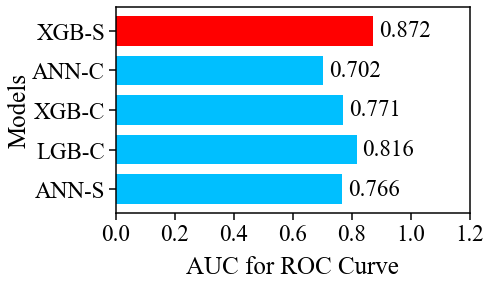

In [1284]:
#compare AUC for different models and datasets.
yaxis = ['ANN-S', 'LGB-C', 'XGB-C', 'ANN-C', 'XGB-S']
             
values = [roc_auc_score(y_test, Regular_ann_results[0]), roc_auc_score(y_test, Lgb_cost_results[0]),
          roc_auc_score(y_test, Xgb_cost_results[0]), roc_auc_score(y_test, Cost_ann_results[0]),
         0.872]
plot_barh(yaxis, values, "AUC for ROC Curve", "Models", 
          ['deepskyblue', 'deepskyblue', 'deepskyblue', 'deepskyblue', 'red'])

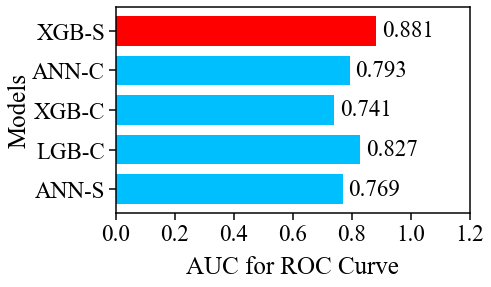

In [1285]:
#compare AUC for different models and datasets.
yaxis = ['ANN-S', 'LGB-C', 'XGB-C', 'ANN-C', 'XGB-S']
             
values = [roc_auc_score(y_test, Regular_ann_results[1]), roc_auc_score(y_test, Lgb_cost_results[1]),
          roc_auc_score(y_test, Xgb_cost_results[1]), roc_auc_score(y_test, Cost_ann_results[1]),
         0.881]
plot_barh(yaxis, values, "AUC for ROC Curve", "Models", 
          ['deepskyblue', 'deepskyblue', 'deepskyblue', 'deepskyblue', 'red'])

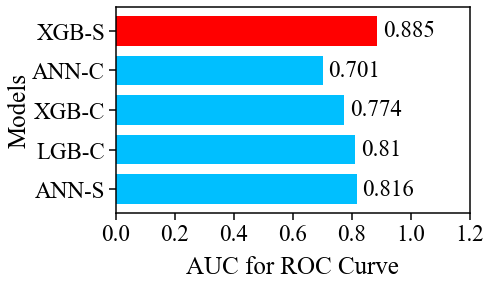

In [1286]:
#compare AUC for different models and datasets.
yaxis = ['ANN-S', 'LGB-C', 'XGB-C', 'ANN-C', 'XGB-S']
             
values = [roc_auc_score(y_test, Regular_ann_results[2]), roc_auc_score(y_test, Lgb_cost_results[2]),
          roc_auc_score(y_test, Xgb_cost_results[2]), roc_auc_score(y_test, Cost_ann_results[2]),
         0.885]
plot_barh(yaxis, values, "AUC for ROC Curve", "Models", 
          ['deepskyblue', 'deepskyblue', 'deepskyblue', 'deepskyblue', 'red'])

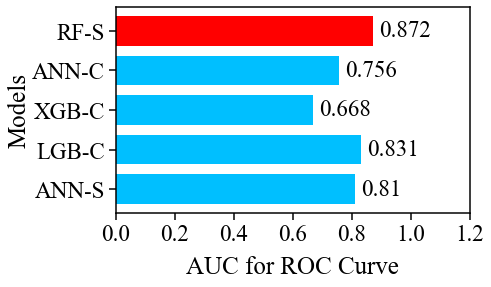

In [1287]:
#compare AUC for different models and datasets.
yaxis = ['ANN-S', 'LGB-C', 'XGB-C', 'ANN-C', 'RF-S']
             
values = [roc_auc_score(y_test, Regular_ann_results[3]), roc_auc_score(y_test, Lgb_cost_results[3]),
          roc_auc_score(y_test, Xgb_cost_results[3]), roc_auc_score(y_test, Cost_ann_results[3]),
         0.872]
plot_barh(yaxis, values, "AUC for ROC Curve", "Models", 
          ['deepskyblue', 'deepskyblue', 'deepskyblue', 'deepskyblue', 'red'])

In [1288]:
#define the function to show the distribution of the predicted results.
def custom_pred_distribution(y_test, y_predt, cutoff):
    positives = y_predt[y_test == 1]
    negatives = y_predt[y_test == 0]
    
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    
    ax[0].hist(negatives[negatives>cutoff], color='C1', label='False Positive', bins=30)
    ax[0].hist(negatives[negatives<=cutoff], label='True Negative', bins=30)
    ax[0].set(xlim=[0, 1], xticks=np.arange(0, 1, step=0.1), xlabel='Model Score', ylabel='Count')
    ax[0].legend()
    
    ax[1].hist(positives[positives>cutoff], label='True Positive', bins=30)
    ax[1].hist(positives[positives<=cutoff], label='False Negative', bins=30)
    ax[1].set(xlim=[0, 1], xticks=np.arange(0, 1, step=0.1), xlabel='Model Score', ylabel='Count')
    ax[1].legend()
    
    plt.tight_layout()
    
    return None

In [1406]:
#calculate the cost_saving
i = round(Asy_test_weight[0]/100000, 2)
p = (Asy_test_weight[0]/1000 - (Asy_test_weight[0]/1000).apply(lambda x: int(x))) * 1000

cost_one = np.sum((1-y_test) * (1-1/np.power(1.07, p)) * 0.99 / 7 * i)# all predicted as failed
cost_zero = np.sum(y_test * i * 0.314)#all predicted as successful
#result: the probability of 1
def calculate_cost_saving(y_test, result, test_weight, threshold):
    #get the minimum cost as the original cost
    original_cost = np.minimum(cost_one, cost_zero)

    cost_FP, cost_FN = calculate_cost(y_test, result, test_weight, threshold)
    ggg1 = round(cost_FP/100000, 2)
    ggg2 = (cost_FP/1000 - (cost_FP/1000).apply(lambda x: int(x))) * 1000
    C4 = (1-1/np.power(1.07, ggg2)) * 0.99 / 7 * ggg1
    
    cost = np.sum(round(cost_FN/100000, 2) * 0.314) + np.sum(C4)

    cost_saving = (original_cost - cost) / original_cost
    return cost_saving

In [1407]:
print(cost_zero, cost_one)

1911.1295999999998 11001.992117701582


# cost for smote regular models

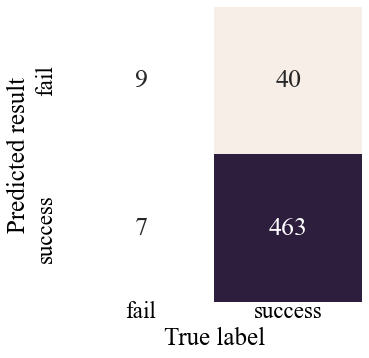

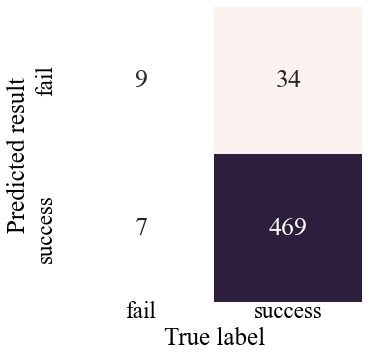

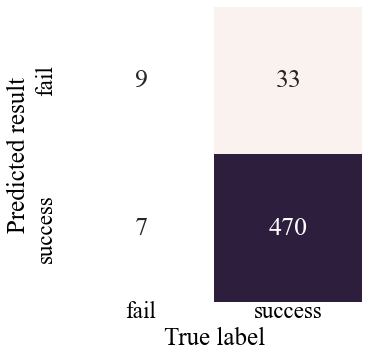

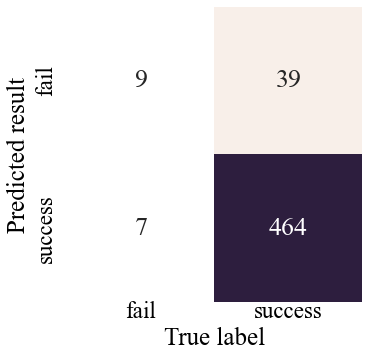

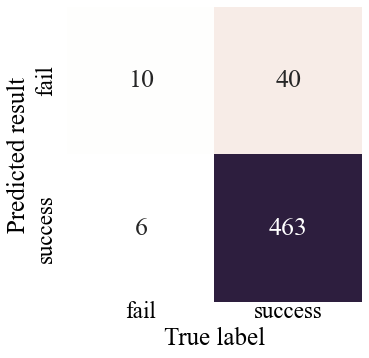

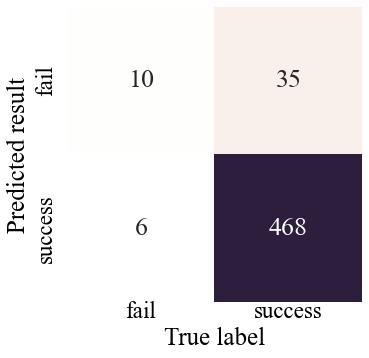

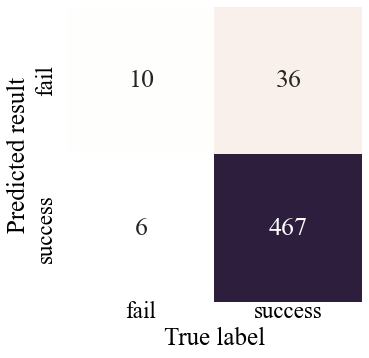

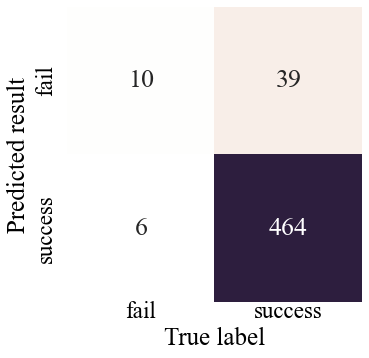

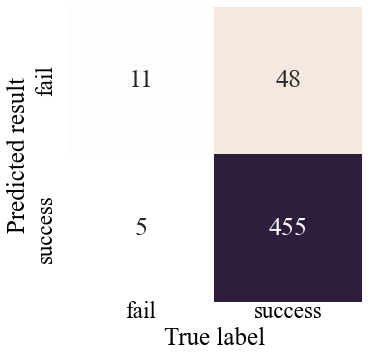

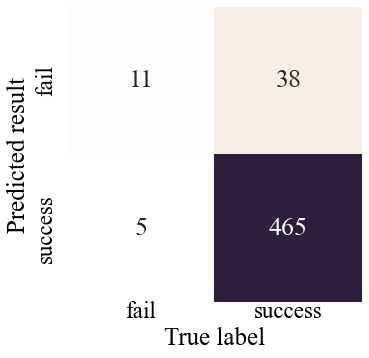

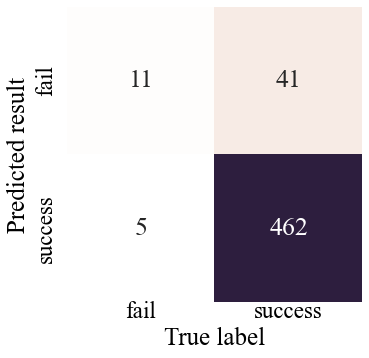

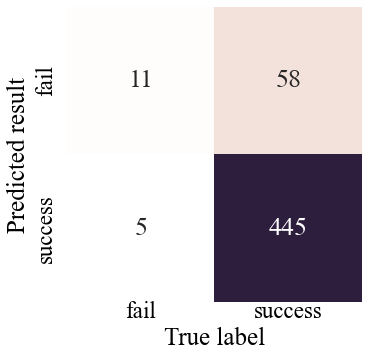

In [438]:
#9
plot_cm(y_test, RF_smote_results[0][:, 1], 0.273)
plot_cm(y_test, RF_smote_results[1][:, 1], 0.347)
plot_cm(y_test, RF_smote_results[2][:, 1], 0.367)
plot_cm(y_test, RF_smote_results[3][:, 1], 0.306)

#10
plot_cm(y_test, RF_smote_results[0][:, 1], 0.26)
plot_cm(y_test, RF_smote_results[1][:, 1], 0.334)
plot_cm(y_test, RF_smote_results[2][:, 1], 0.36)
plot_cm(y_test, RF_smote_results[3][:, 1], 0.303)

#11
plot_cm(y_test, RF_smote_results[0][:, 1], 0.243)
plot_cm(y_test, RF_smote_results[1][:, 1], 0.323)
plot_cm(y_test, RF_smote_results[2][:, 1], 0.338)
plot_cm(y_test, RF_smote_results[3][:, 1], 0.244)

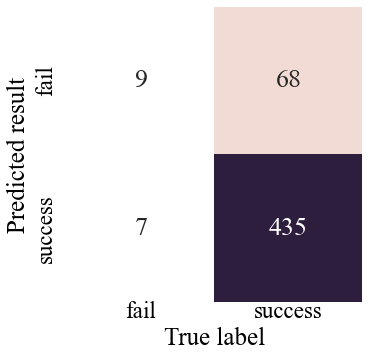

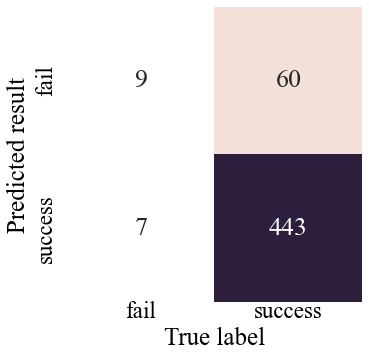

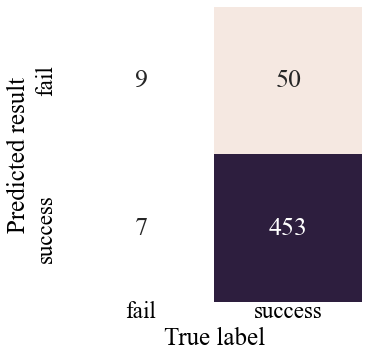

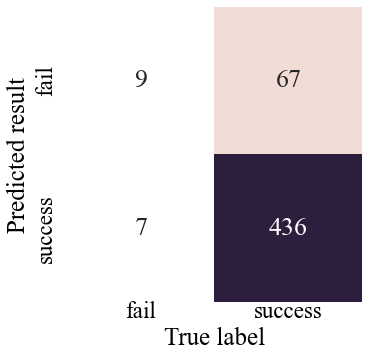

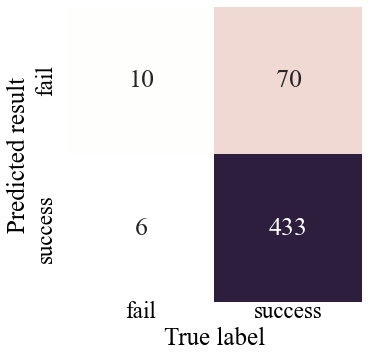

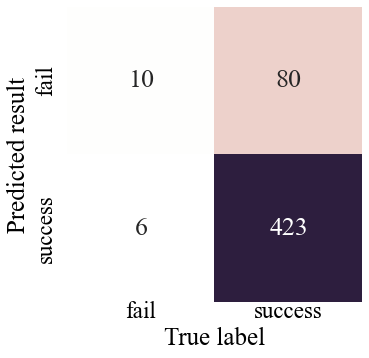

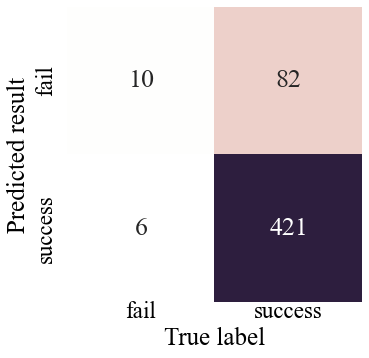

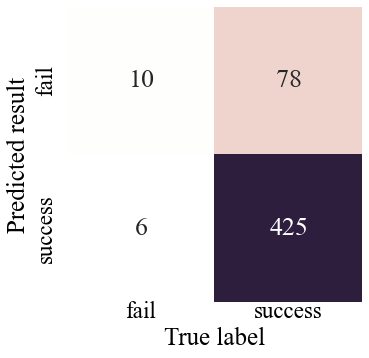

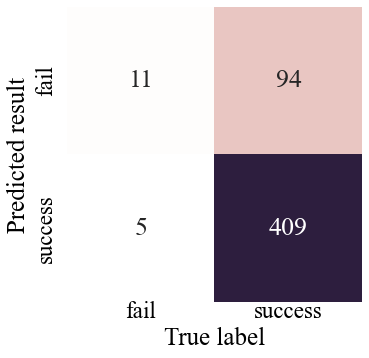

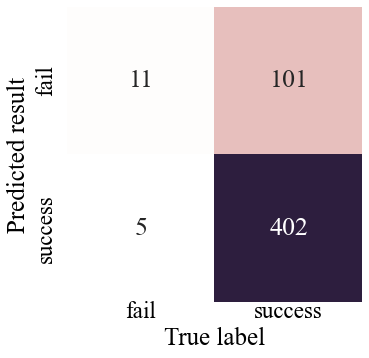

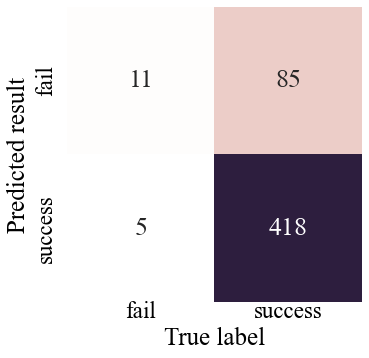

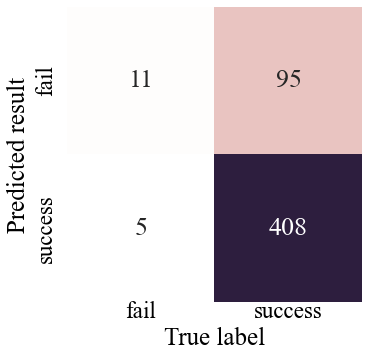

In [554]:
#9
plot_cm(y_test, LR_smote_results[0][:, 1], 0.653)
plot_cm(y_test, LR_smote_results[1][:, 1], 0.67)
plot_cm(y_test, LR_smote_results[2][:, 1], 0.67)
plot_cm(y_test, LR_smote_results[3][:, 1], 0.7)

#10
plot_cm(y_test, LR_smote_results[0][:, 1], 0.650)
plot_cm(y_test, LR_smote_results[1][:, 1], 0.614)
plot_cm(y_test, LR_smote_results[2][:, 1], 0.599)
plot_cm(y_test, LR_smote_results[3][:, 1], 0.609)

#11
plot_cm(y_test, LR_smote_results[0][:, 1], 0.536)
plot_cm(y_test, LR_smote_results[1][:, 1], 0.55)
plot_cm(y_test, LR_smote_results[2][:, 1], 0.598)
plot_cm(y_test, LR_smote_results[3][:, 1], 0.52)

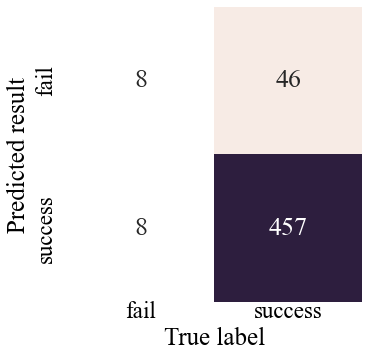

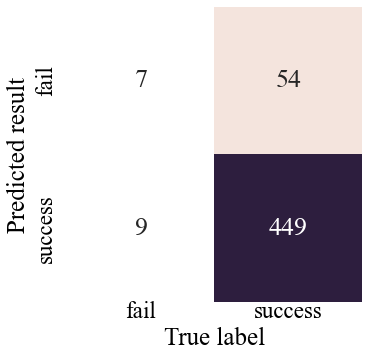

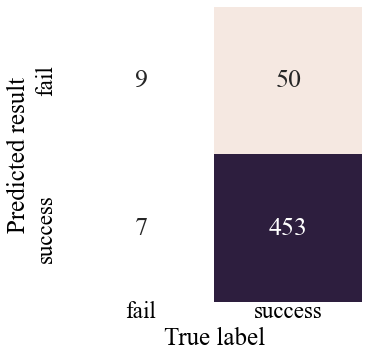

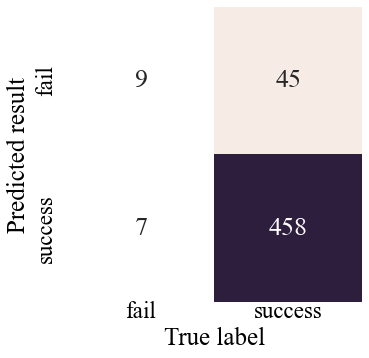

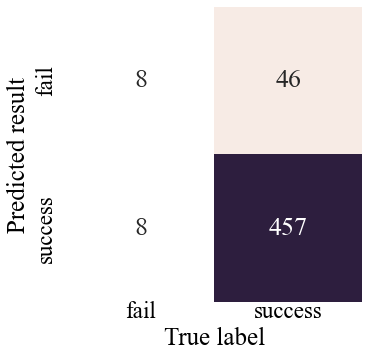

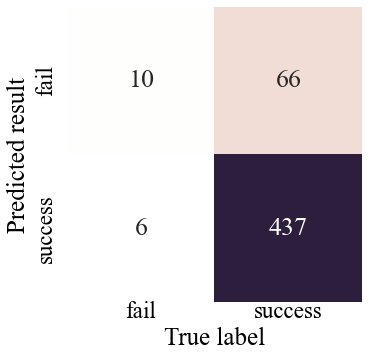

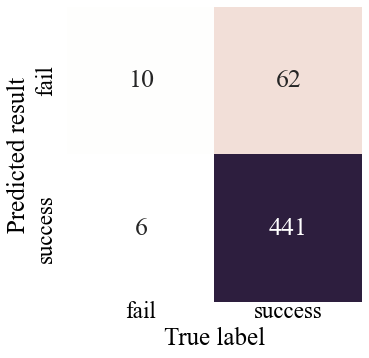

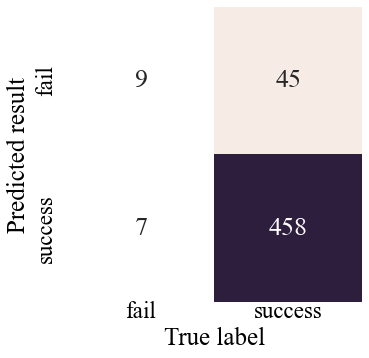

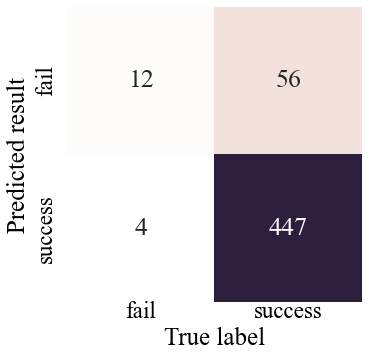

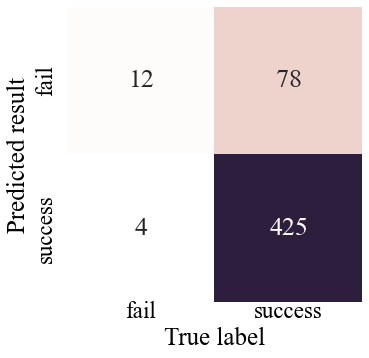

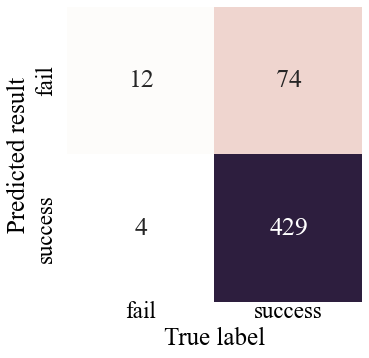

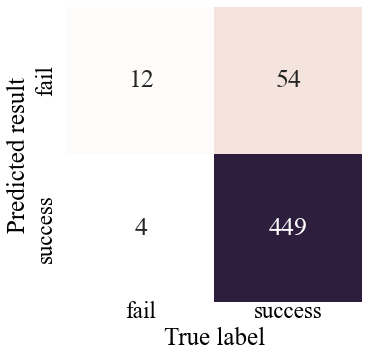

In [620]:
#9
plot_cm(y_test, KNN_smote_results[0][:, 1], 0.8)
plot_cm(y_test, KNN_smote_results[1][:, 1], 0.74)
plot_cm(y_test, KNN_smote_results[2][:, 1], 0.79)
plot_cm(y_test, KNN_smote_results[3][:, 1], 0.83)

#10
plot_cm(y_test, KNN_smote_results[0][:, 1], 0.78)
plot_cm(y_test, KNN_smote_results[1][:, 1], 0.73)
plot_cm(y_test, KNN_smote_results[2][:, 1], 0.74)
plot_cm(y_test, KNN_smote_results[3][:, 1], 0.83)

#11
plot_cm(y_test, KNN_smote_results[0][:, 1], 0.761)
plot_cm(y_test, KNN_smote_results[1][:, 1], 0.66)
plot_cm(y_test, KNN_smote_results[2][:, 1], 0.7)
plot_cm(y_test, KNN_smote_results[3][:, 1], 0.79)

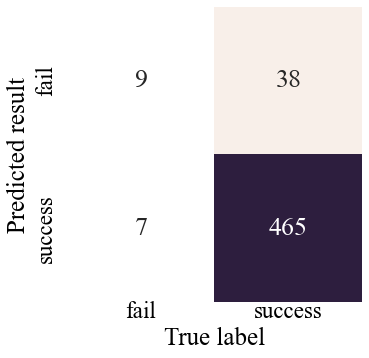

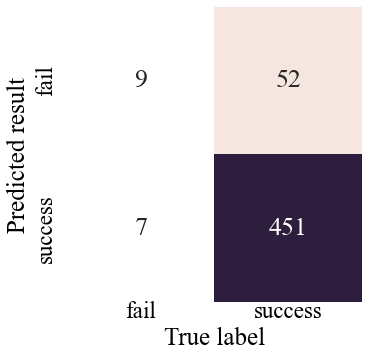

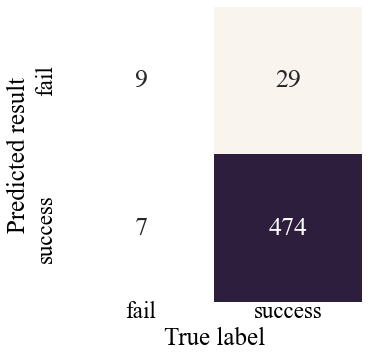

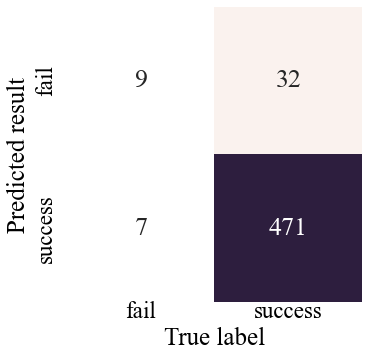

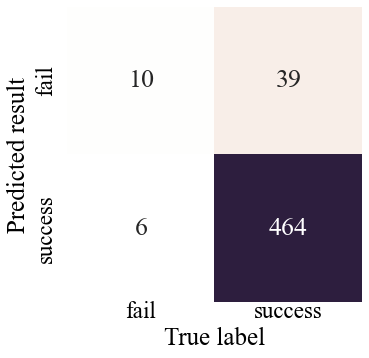

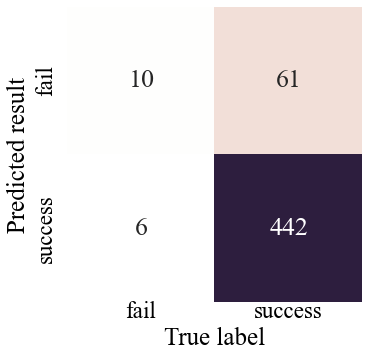

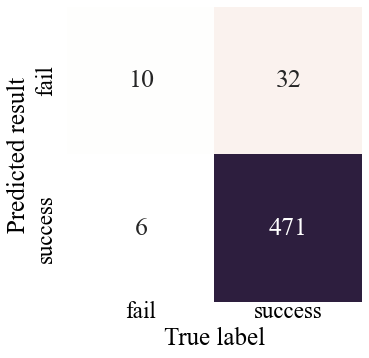

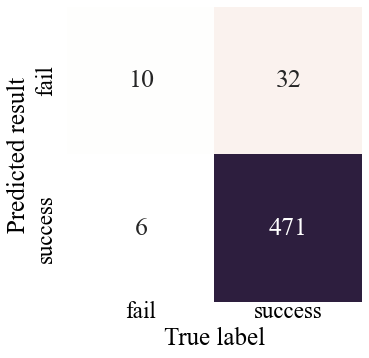

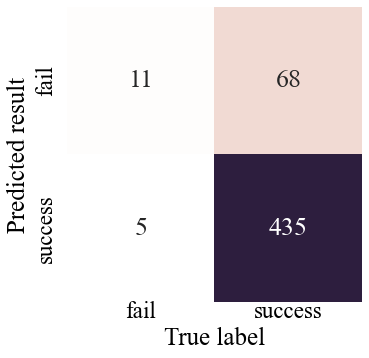

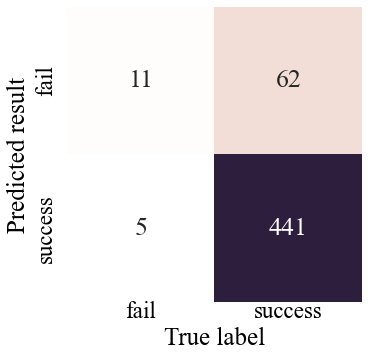

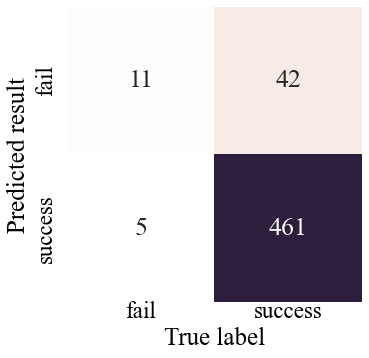

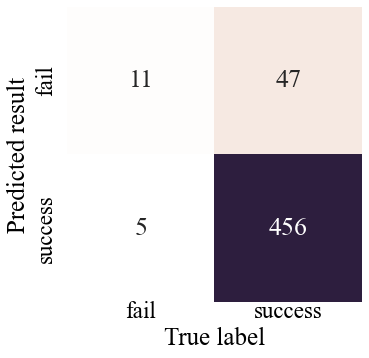

In [724]:
#9
plot_cm(y_test, LGB_smote_results[0][:, 1], 0.2)
plot_cm(y_test, LGB_smote_results[1][:, 1], 0.375)
plot_cm(y_test, LGB_smote_results[2][:, 1], 0.35)
plot_cm(y_test, LGB_smote_results[3][:, 1], 0.18)
#10
plot_cm(y_test, LGB_smote_results[0][:, 1], 0.184)
plot_cm(y_test, LGB_smote_results[1][:, 1], 0.321)
plot_cm(y_test, LGB_smote_results[2][:, 1], 0.26)
plot_cm(y_test, LGB_smote_results[3][:, 1], 0.17)
#11
plot_cm(y_test, LGB_smote_results[0][:, 1], 0.047)
plot_cm(y_test, LGB_smote_results[1][:, 1], 0.317)
plot_cm(y_test, LGB_smote_results[2][:, 1], 0.14)
plot_cm(y_test, LGB_smote_results[3][:, 1], 0.101)

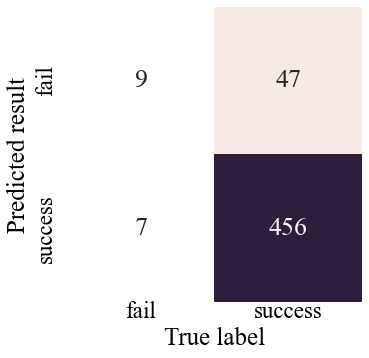

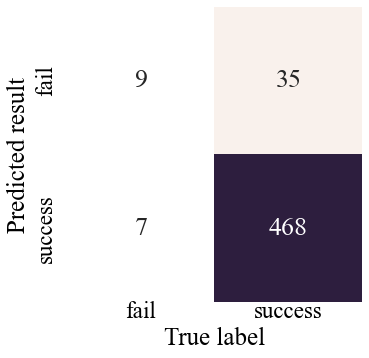

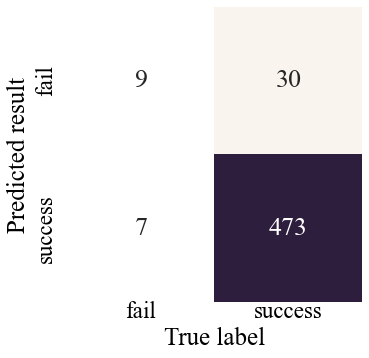

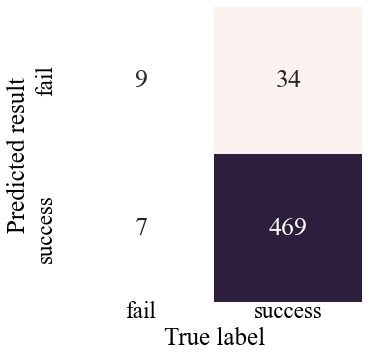

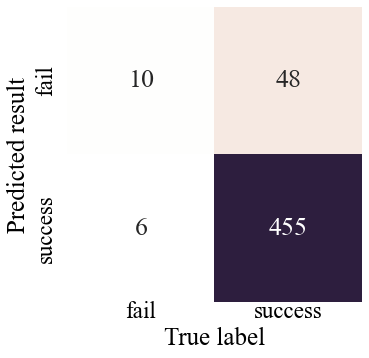

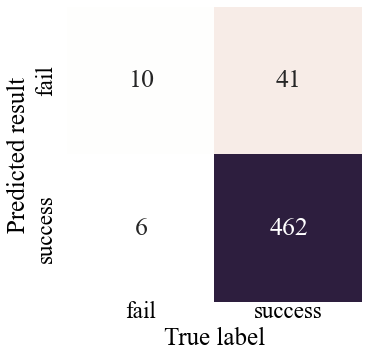

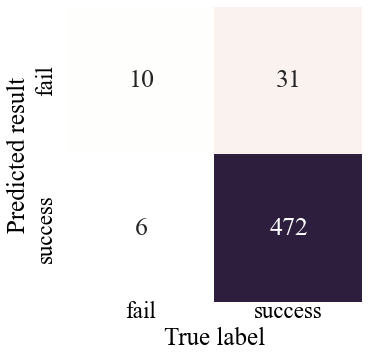

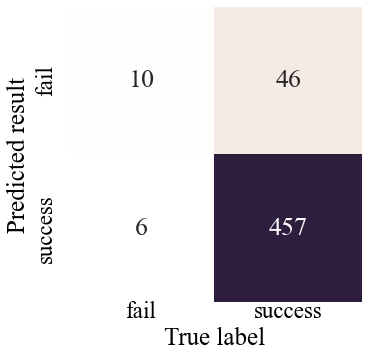

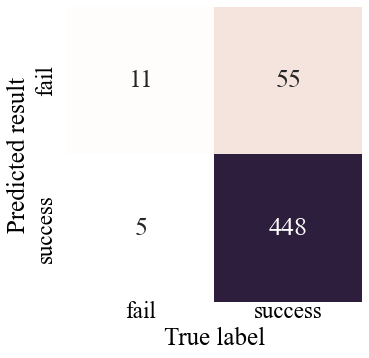

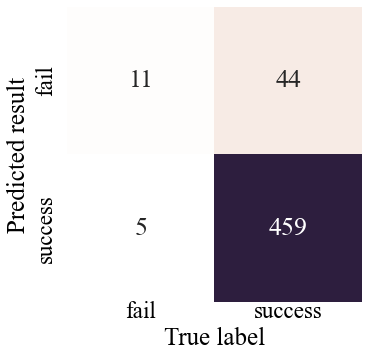

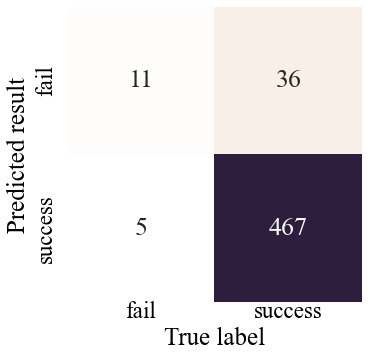

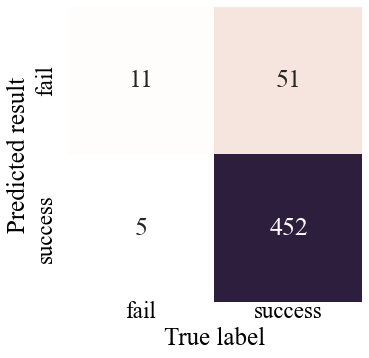

In [831]:
#9
plot_cm(y_test, XGB_smote_results[0][:, 1], 0.111)
plot_cm(y_test, XGB_smote_results[1][:, 1], 0.22)
plot_cm(y_test, XGB_smote_results[2][:, 1], 0.2)
plot_cm(y_test, XGB_smote_results[3][:, 1], 0.247)
#10
plot_cm(y_test, XGB_smote_results[0][:, 1], 0.091)
plot_cm(y_test, XGB_smote_results[1][:, 1], 0.173)
plot_cm(y_test, XGB_smote_results[2][:, 1], 0.165)
plot_cm(y_test, XGB_smote_results[3][:, 1], 0.15)
#11
plot_cm(y_test, XGB_smote_results[0][:, 1], 0.067)
plot_cm(y_test, XGB_smote_results[1][:, 1], 0.147)
plot_cm(y_test, XGB_smote_results[2][:, 1], 0.149)
plot_cm(y_test, XGB_smote_results[3][:, 1], 0.128)

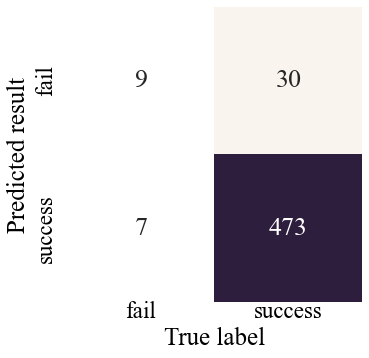

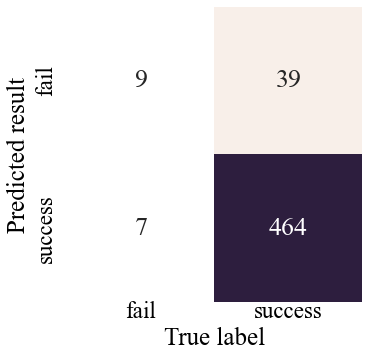

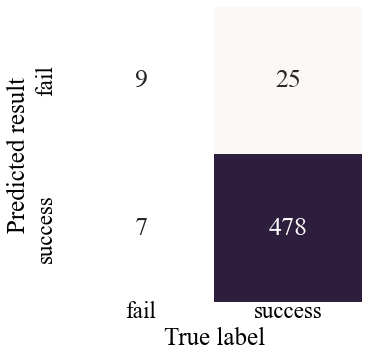

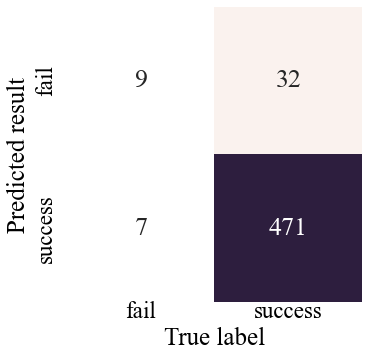

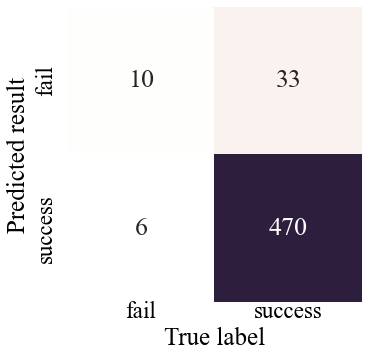

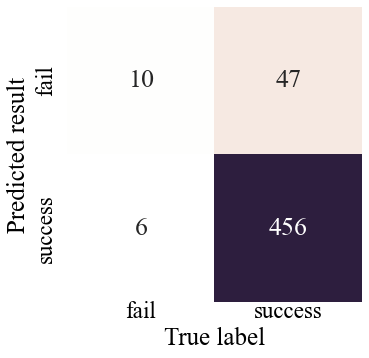

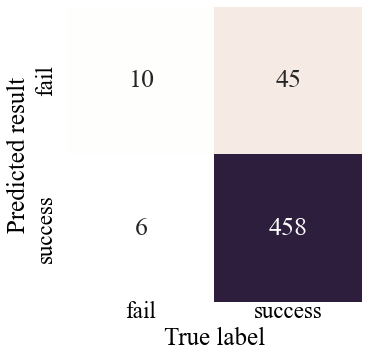

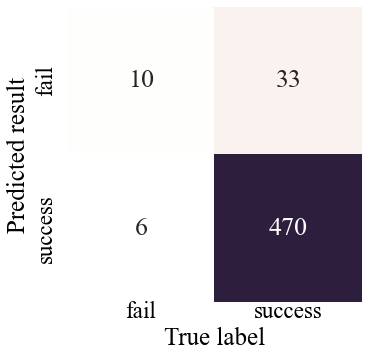

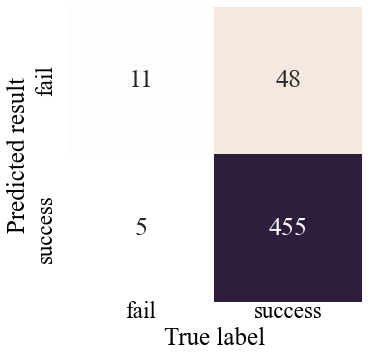

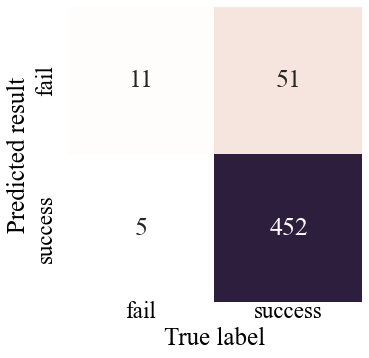

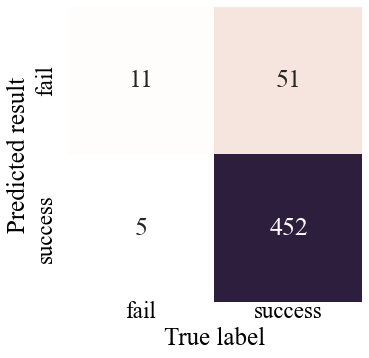

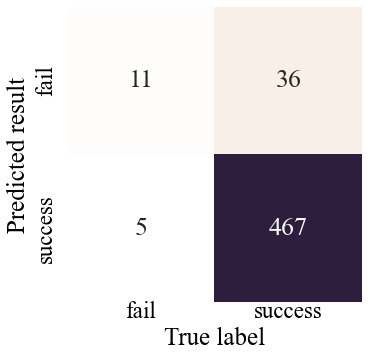

In [904]:
#9
plot_cm(y_test, smote_stacking_results[0][:, 1], 0.10)
plot_cm(y_test, smote_stacking_results[1][:, 1], 0.087)
plot_cm(y_test, smote_stacking_results[2][:, 1], 0.1)
plot_cm(y_test, smote_stacking_results[3][:, 1], 0.093)
#10
plot_cm(y_test, smote_stacking_results[0][:, 1], 0.091)
plot_cm(y_test, smote_stacking_results[1][:, 1], 0.076)
plot_cm(y_test, smote_stacking_results[2][:, 1], 0.082)
plot_cm(y_test, smote_stacking_results[3][:, 1], 0.091)
#11
plot_cm(y_test, smote_stacking_results[0][:, 1], 0.07)
plot_cm(y_test, smote_stacking_results[1][:, 1], 0.073)
plot_cm(y_test, smote_stacking_results[2][:, 1], 0.077)
plot_cm(y_test, smote_stacking_results[3][:, 1], 0.086)

# cost for undersampling models

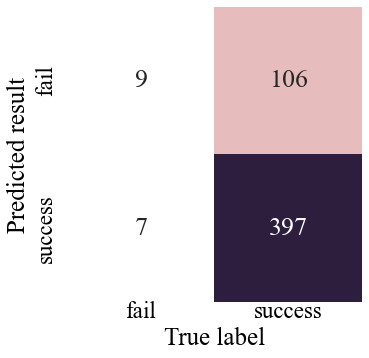

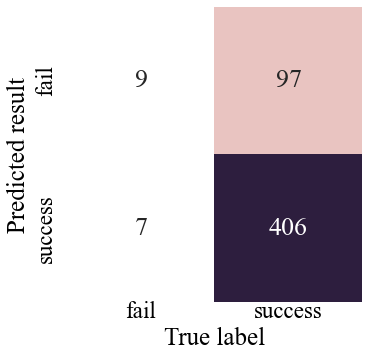

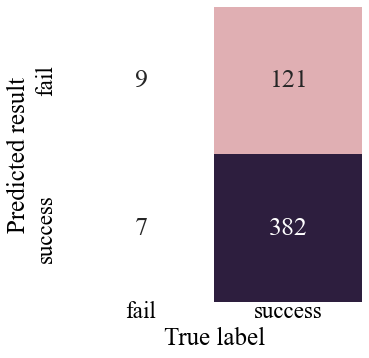

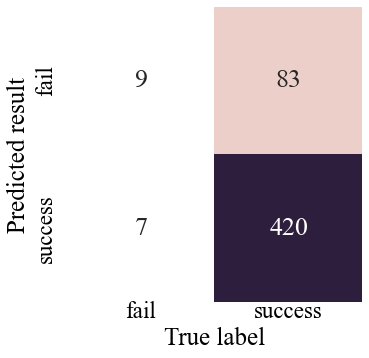

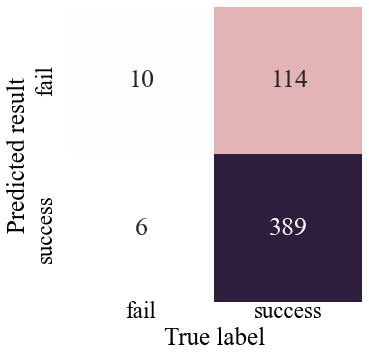

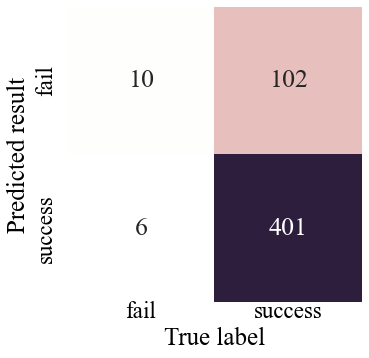

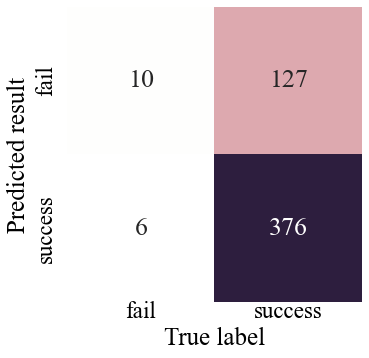

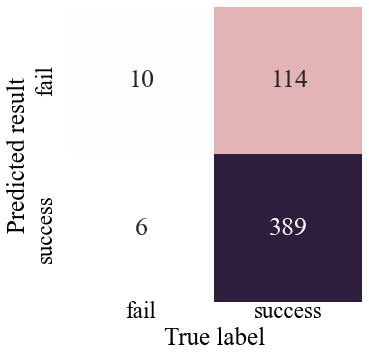

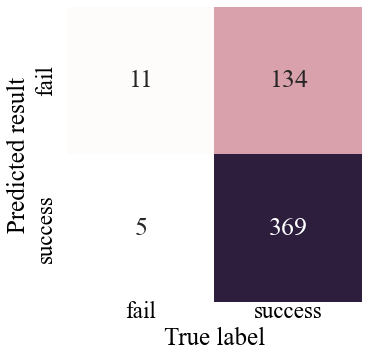

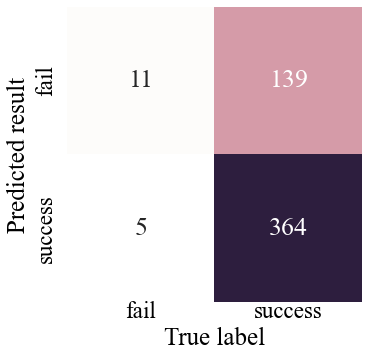

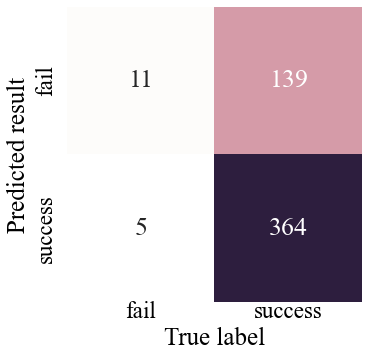

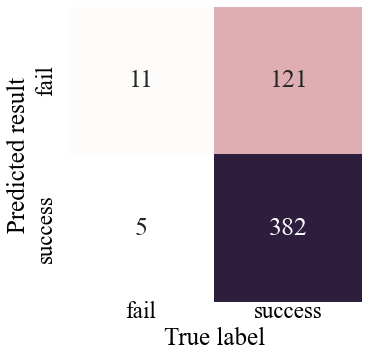

In [1010]:
#9
plot_cm(y_test, RF_under_results[0][:, 1], 0.581)
plot_cm(y_test, RF_under_results[1][:, 1], 0.587)
plot_cm(y_test, RF_under_results[2][:, 1], 0.555)
plot_cm(y_test, RF_under_results[3][:, 1], 0.589)

#10
plot_cm(y_test, RF_under_results[0][:, 1], 0.576)
plot_cm(y_test, RF_under_results[1][:, 1], 0.582)
plot_cm(y_test, RF_under_results[2][:, 1], 0.549)
plot_cm(y_test, RF_under_results[3][:, 1], 0.55)
#11
plot_cm(y_test, RF_under_results[0][:, 1], 0.541)
plot_cm(y_test, RF_under_results[1][:, 1], 0.532)
plot_cm(y_test, RF_under_results[2][:, 1], 0.532)
plot_cm(y_test, RF_under_results[3][:, 1], 0.546)

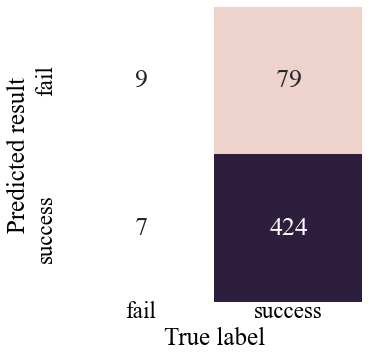

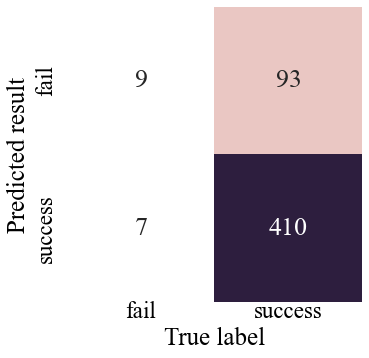

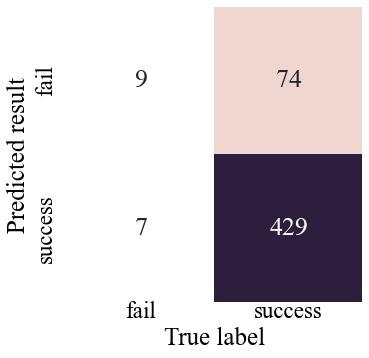

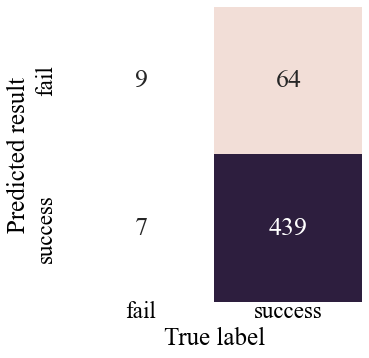

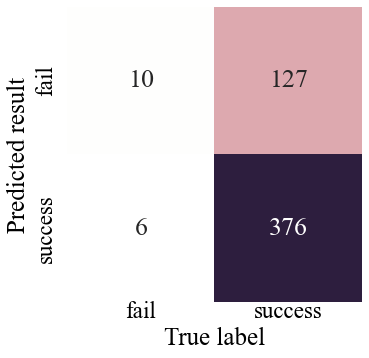

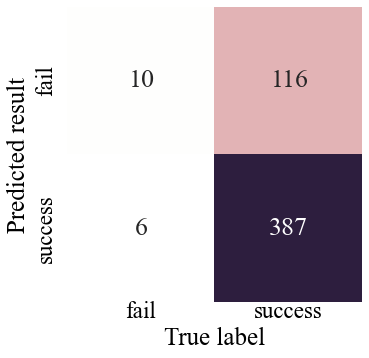

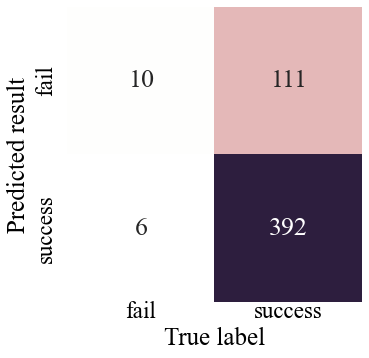

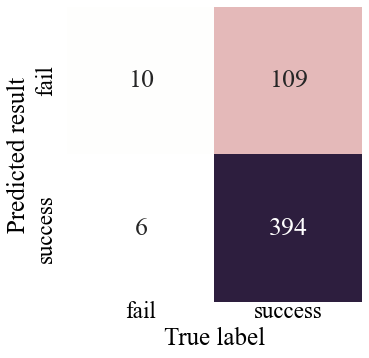

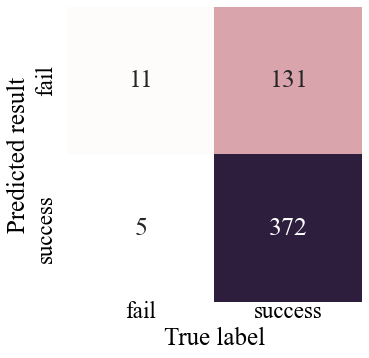

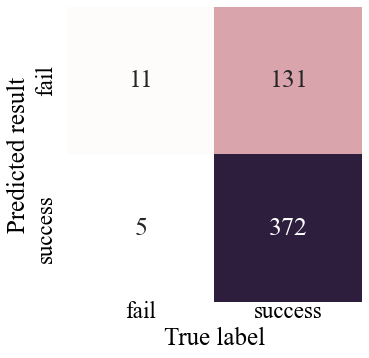

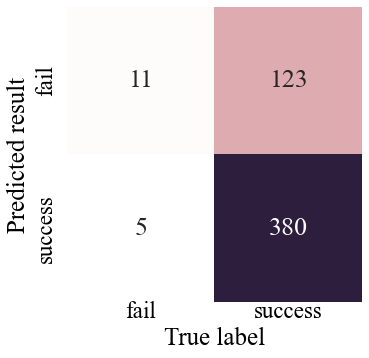

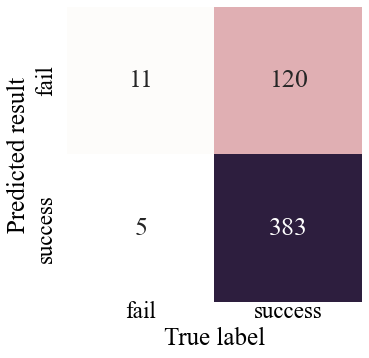

In [1112]:
#9
plot_cm(y_test, LR_under_results[0][:, 1], 0.8)
plot_cm(y_test, LR_under_results[1][:, 1], 0.775)
plot_cm(y_test, LR_under_results[2][:, 1], 0.624)
plot_cm(y_test, LR_under_results[3][:, 1], 0.83)
#10
plot_cm(y_test, LR_under_results[0][:, 1], 0.639)
plot_cm(y_test, LR_under_results[1][:, 1], 0.69)
plot_cm(y_test, LR_under_results[2][:, 1], 0.569)
plot_cm(y_test, LR_under_results[3][:, 1], 0.73)
#11
plot_cm(y_test, LR_under_results[0][:, 1], 0.63)
plot_cm(y_test, LR_under_results[1][:, 1], 0.62)
plot_cm(y_test, LR_under_results[2][:, 1], 0.554)
plot_cm(y_test, LR_under_results[3][:, 1], 0.69)

In [ ]:
#9
plot_cm(y_test, LGB_under_results[0][:, 1], 0.58)
plot_cm(y_test, LGB_under_results[1][:, 1], 0.67)
plot_cm(y_test, LGB_under_results[2][:, 1], 0.7)
#10
plot_cm(y_test, LGB_under_results[0][:, 1], 0.55)
plot_cm(y_test, LGB_under_results[1][:, 1], 0.614)
plot_cm(y_test, LGB_under_results[2][:, 1], 0.68)
plot_cm(y_test, LGB_under_results[3][:, 1], 0.74)
#11
plot_cm(y_test, LGB_under_results[0][:, 1], 0.52)
plot_cm(y_test, LGB_under_results[1][:, 1], 0.60)
plot_cm(y_test, LGB_under_results[2][:, 1], 0.573)
plot_cm(y_test, LGB_under_results[3][:, 1], 0.55)

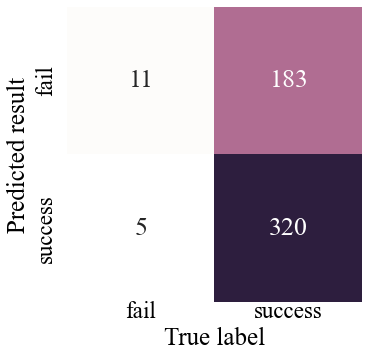

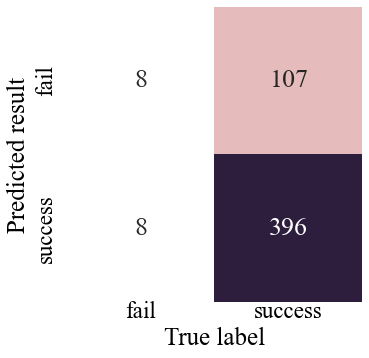

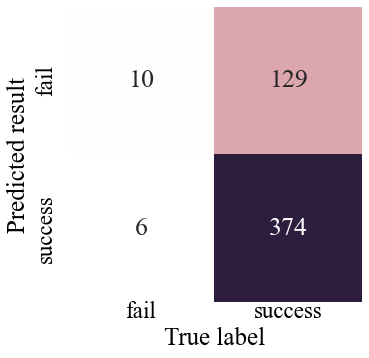

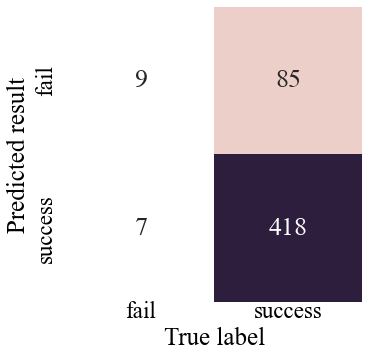

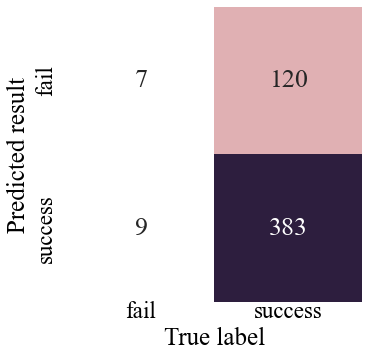

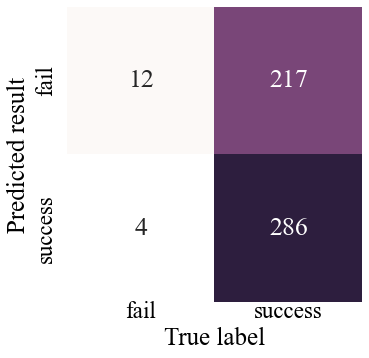

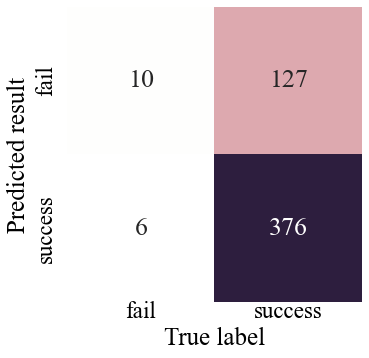

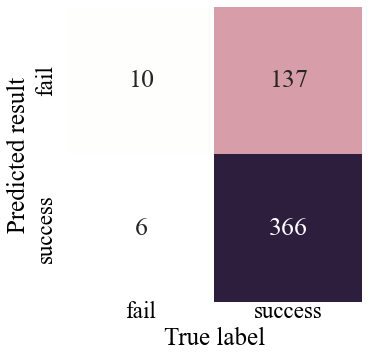

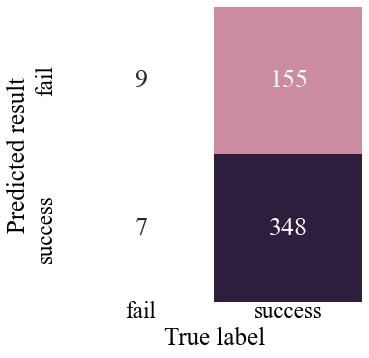

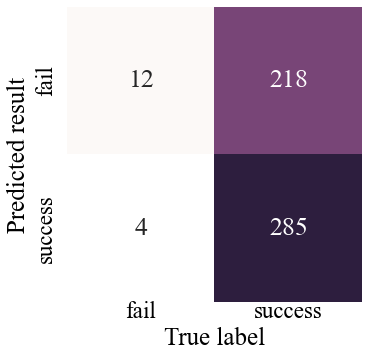

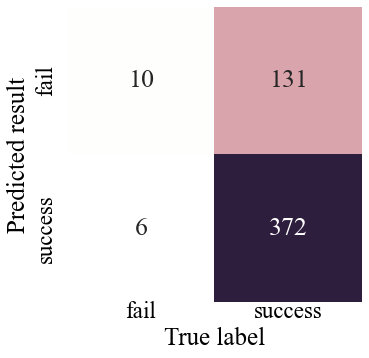

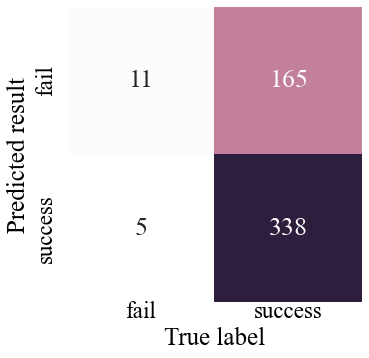

In [1210]:

plot_cm(y_test, LGB_under_results[1][:, 1], 0.44)
plot_cm(y_test, LGB_under_results[2][:, 1], 0.71)
plot_cm(y_test, LGB_under_results[3][:, 1], 0.598)
plot_cm(y_test, LGB_under_results[3][:, 1], 0.778)
#10
plot_cm(y_test, LGB_under_results[0][:, 1], 0.667)
plot_cm(y_test, LGB_under_results[1][:, 1], 0.36)
plot_cm(y_test, LGB_under_results[2][:, 1], 0.612)
plot_cm(y_test, LGB_under_results[3][:, 1], 0.582)
#11
plot_cm(y_test, LGB_under_results[0][:, 1], 0.556)
plot_cm(y_test, LGB_under_results[1][:, 1], 0.355)
plot_cm(y_test, LGB_under_results[2][:, 1], 0.59)
plot_cm(y_test, LGB_under_results[3][:, 1], 0.518)

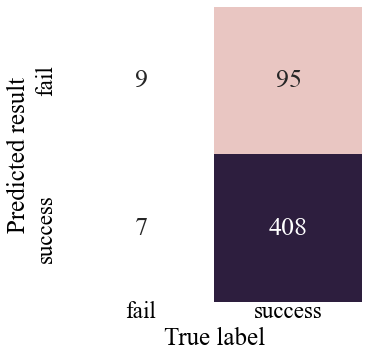

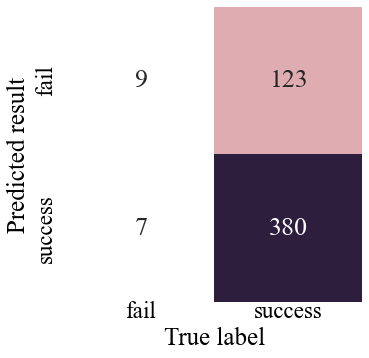

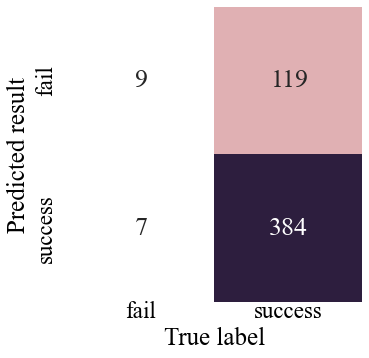

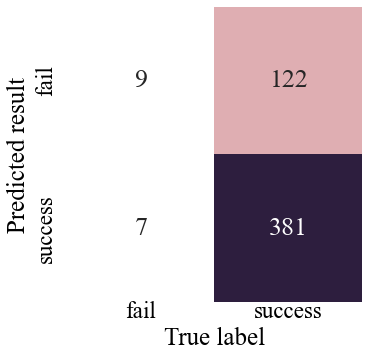

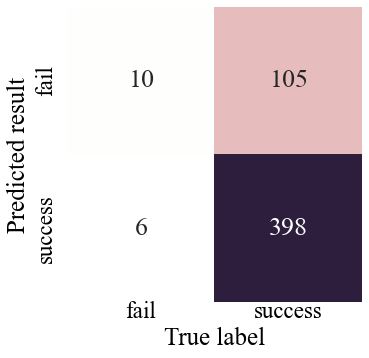

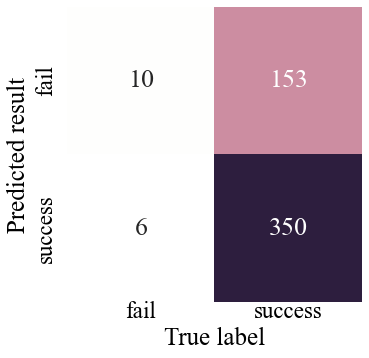

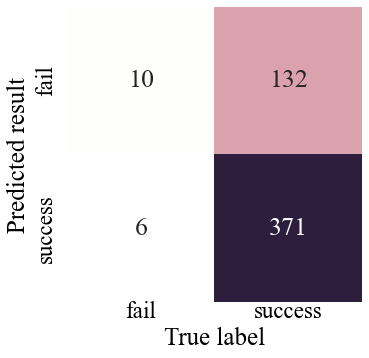

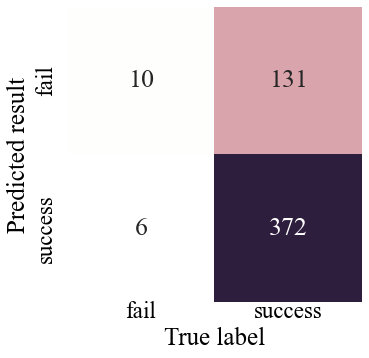

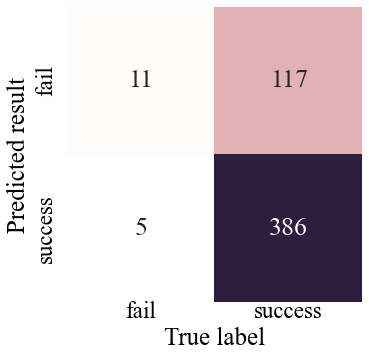

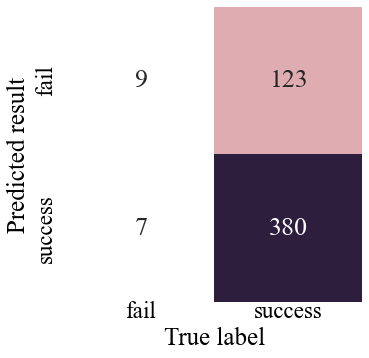

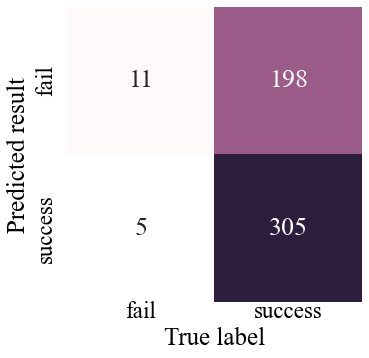

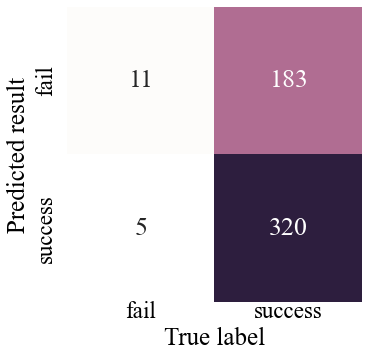

In [1195]:
#9
plot_cm(y_test, XGB_under_results[0][:, 1], 0.81)
plot_cm(y_test, XGB_under_results[1][:, 1], 0.616)
plot_cm(y_test, XGB_under_results[2][:, 1], 0.81)
plot_cm(y_test, XGB_under_results[3][:, 1], 0.746)
#10
plot_cm(y_test, XGB_under_results[0][:, 1], 0.78)
plot_cm(y_test, XGB_under_results[1][:, 1], 0.491)
plot_cm(y_test, XGB_under_results[2][:, 1], 0.69)
plot_cm(y_test, XGB_under_results[3][:, 1], 0.696)
#11
plot_cm(y_test, XGB_under_results[0][:, 1], 0.696)
plot_cm(y_test, XGB_under_results[1][:, 1], 0.61)
plot_cm(y_test, XGB_under_results[2][:, 1], 0.31)
plot_cm(y_test, XGB_under_results[3][:, 1], 0.47)

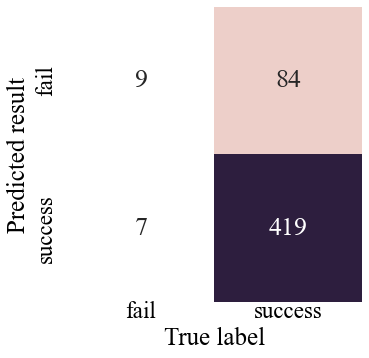

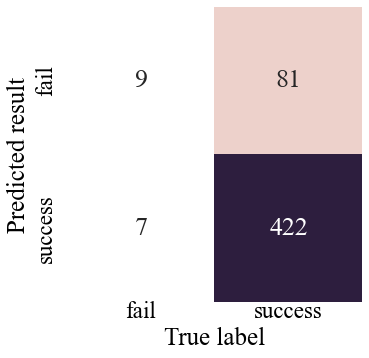

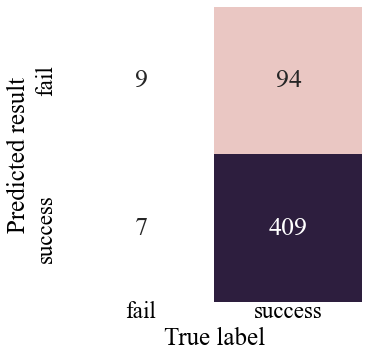

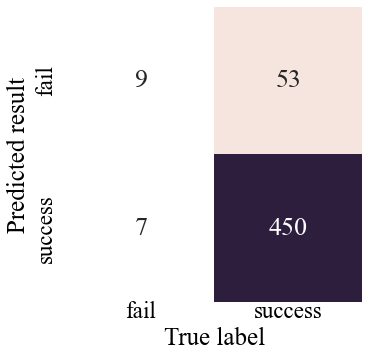

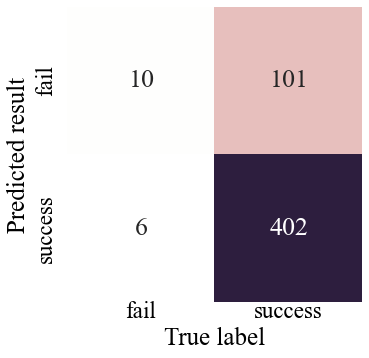

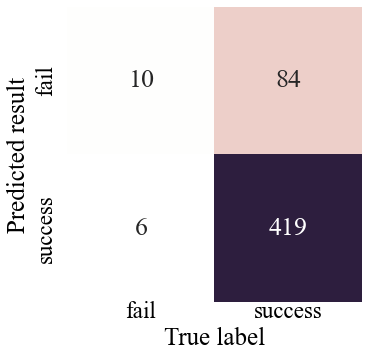

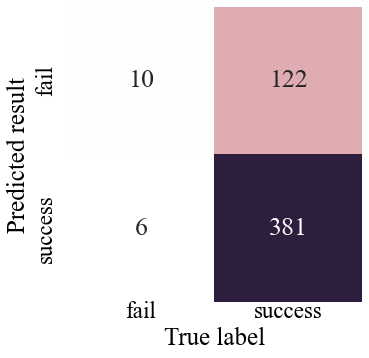

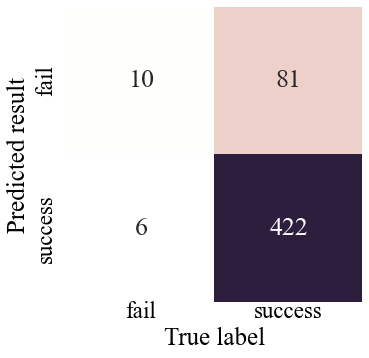

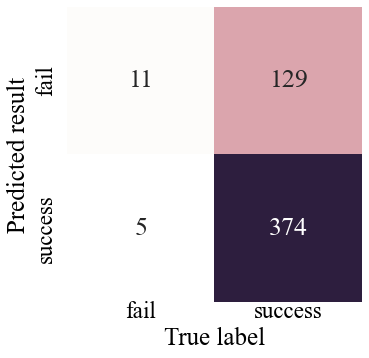

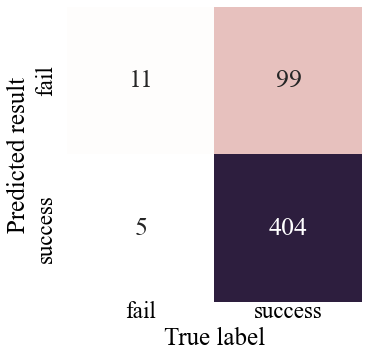

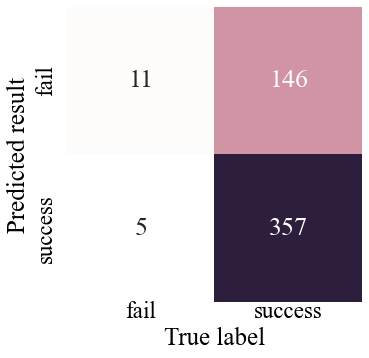

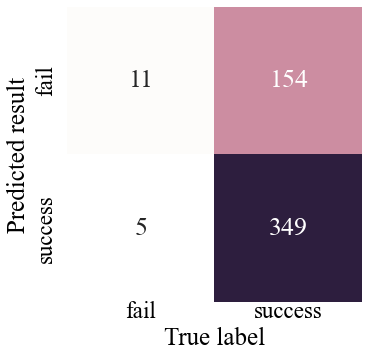

In [1315]:
#9
plot_cm(y_test, under_stacking_results[0][:, 1], 0.067)
plot_cm(y_test, under_stacking_results[1][:, 1], 0.072)
plot_cm(y_test, under_stacking_results[2][:, 1], 0.063)
plot_cm(y_test, under_stacking_results[3][:, 1], 0.076)
#10
plot_cm(y_test, under_stacking_results[0][:, 1], 0.058)
plot_cm(y_test, under_stacking_results[1][:, 1], 0.068)
plot_cm(y_test, under_stacking_results[2][:, 1], 0.048)
plot_cm(y_test, under_stacking_results[3][:, 1], 0.066)
#11
plot_cm(y_test, under_stacking_results[0][:, 1], 0.047)
plot_cm(y_test, under_stacking_results[1][:, 1], 0.059)
plot_cm(y_test, under_stacking_results[2][:, 1], 0.036)
plot_cm(y_test, under_stacking_results[3][:, 1], 0.034)

# cost for cost models

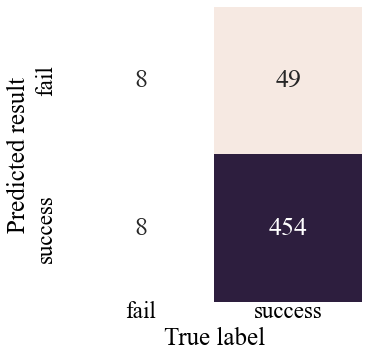

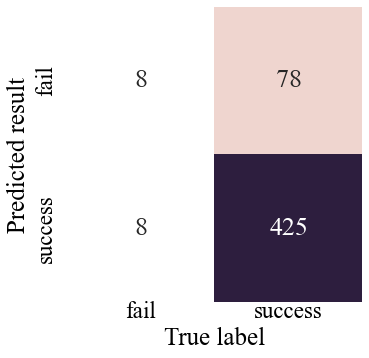

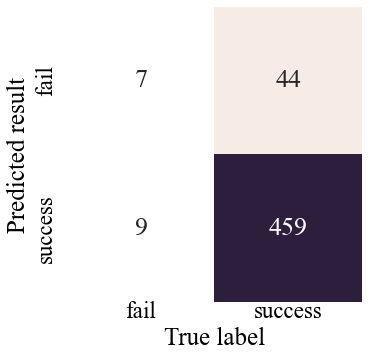

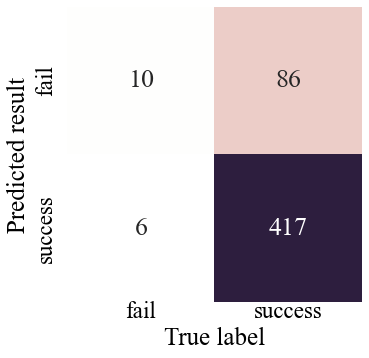

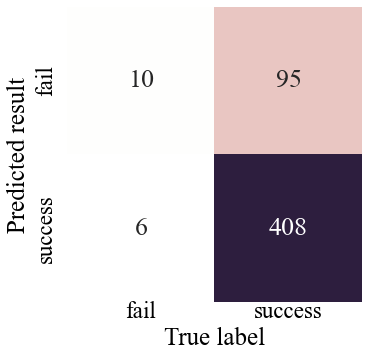

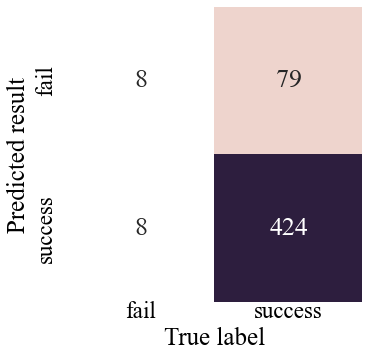

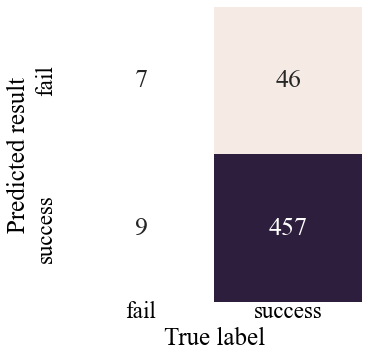

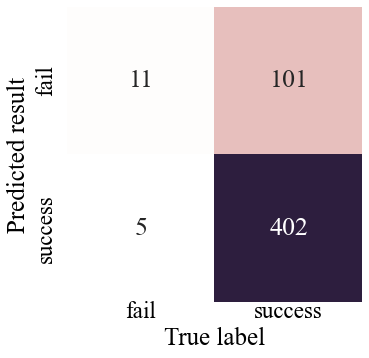

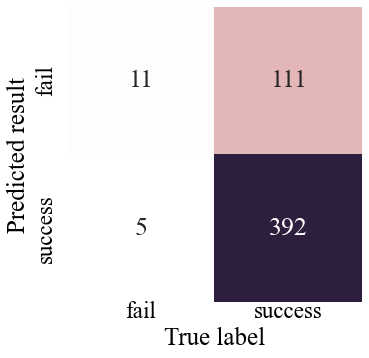

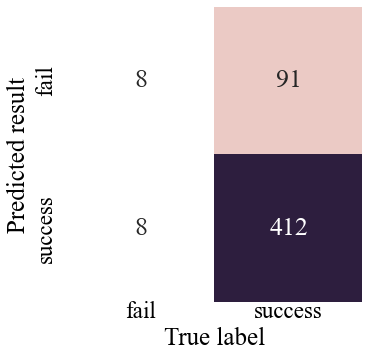

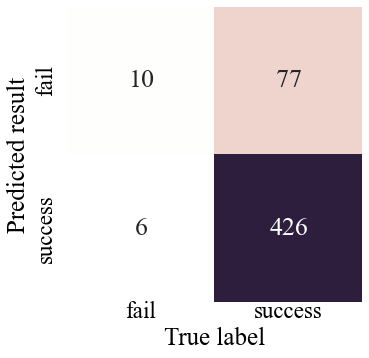

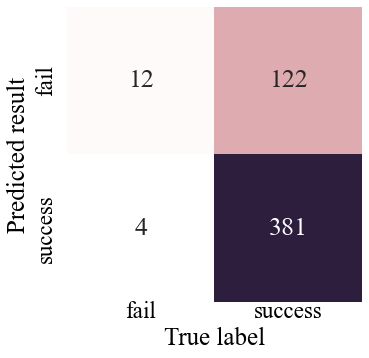

In [1316]:
#9
plot_cm(y_test, Lgb_cost_results[0], 0.0045)
plot_cm(y_test, Lgb_cost_results[1], 0.00266)
plot_cm(y_test, Lgb_cost_results[2], 0.0082)
plot_cm(y_test, Lgb_cost_results[3], 0.0016)

#10
plot_cm(y_test, Lgb_cost_results[0], 0.0017)
plot_cm(y_test, Lgb_cost_results[1], 0.0026)
plot_cm(y_test, Lgb_cost_results[2], 0.0076)
plot_cm(y_test, Lgb_cost_results[3], 0.0013)
#11
plot_cm(y_test, Lgb_cost_results[0], 0.00119)
plot_cm(y_test, Lgb_cost_results[1], 0.00172)
plot_cm(y_test, Lgb_cost_results[2], 0.00182)
plot_cm(y_test, Lgb_cost_results[3], 0.00086)

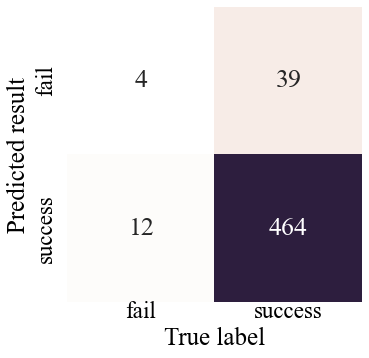

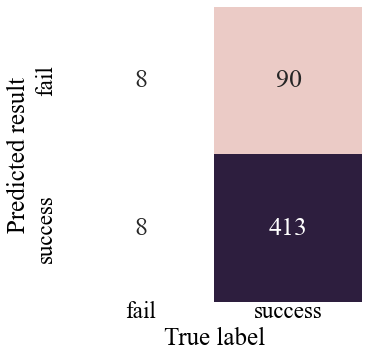

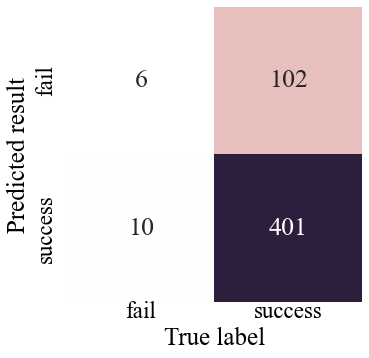

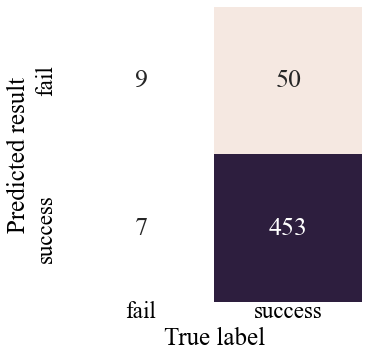

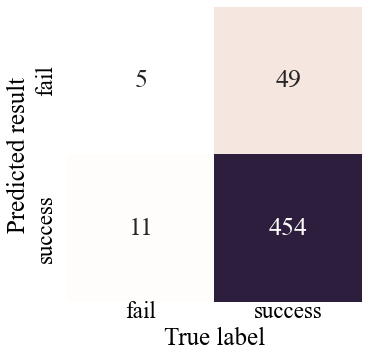

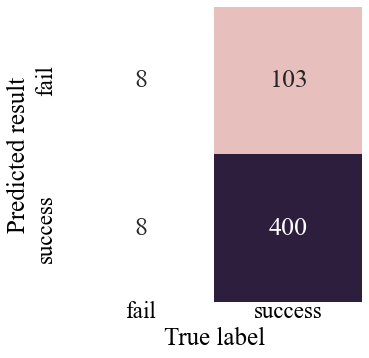

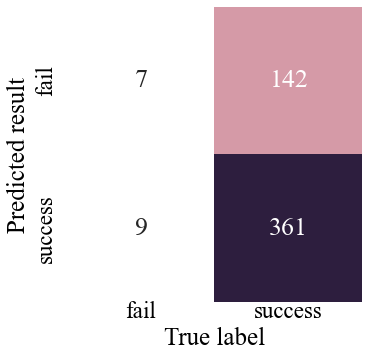

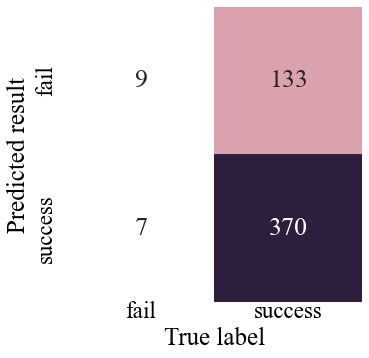

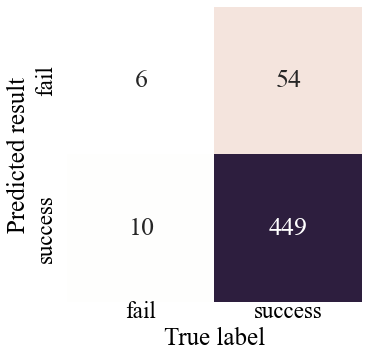

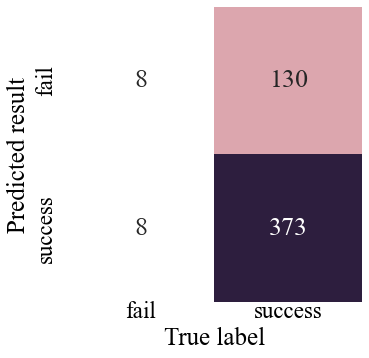

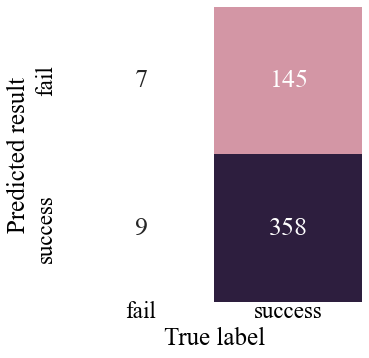

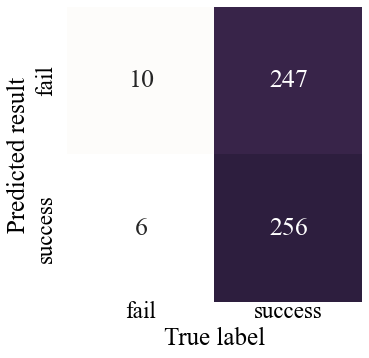

In [1317]:
#9
plot_cm(y_test, Xgb_cost_results[0], 0.112)
plot_cm(y_test, Xgb_cost_results[1], 0.072)
plot_cm(y_test, Xgb_cost_results[2], 0.075)
plot_cm(y_test, Xgb_cost_results[3], 0.085)
#10
plot_cm(y_test, Xgb_cost_results[0], 0.074)
plot_cm(y_test, Xgb_cost_results[1], 0.067)
plot_cm(y_test, Xgb_cost_results[2], 0.0567)
plot_cm(y_test, Xgb_cost_results[3], 0.048)
#11
plot_cm(y_test, Xgb_cost_results[0], 0.068)
plot_cm(y_test, Xgb_cost_results[1], 0.0543)
plot_cm(y_test, Xgb_cost_results[2], 0.0558)
plot_cm(y_test, Xgb_cost_results[3], 0.036)

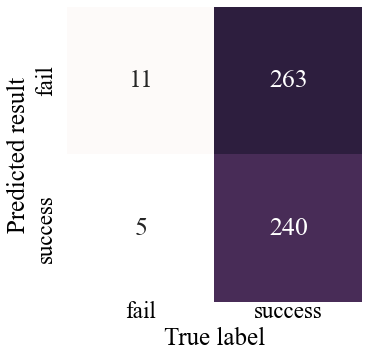

In [1566]:
#9
plot_cm(y_test, Regular_ann_results[0], 0.0002)
plot_cm(y_test, Regular_ann_results[1], 0.00011)
plot_cm(y_test, Regular_ann_results[2], 0.051)
plot_cm(y_test, Regular_ann_results[3], 0.0057)
#10
plot_cm(y_test, Regular_ann_results[0], 0.00002)
plot_cm(y_test, Regular_ann_results[1], 0.000015)
plot_cm(y_test, Regular_ann_results[2], 0.0091)
plot_cm(y_test, Regular_ann_results[3], 0.0002)
#11
plot_cm(y_test, Regular_ann_results[0], 0.000003)
plot_cm(y_test, Regular_ann_results[1], 0.0000002)
plot_cm(y_test, Regular_ann_results[2], 0.00003)
plot_cm(y_test, Regular_ann_results[3], 0.00014)

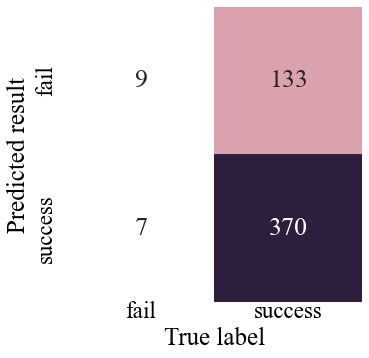

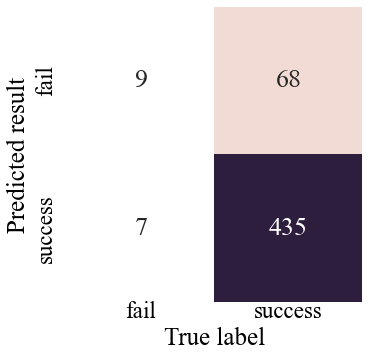

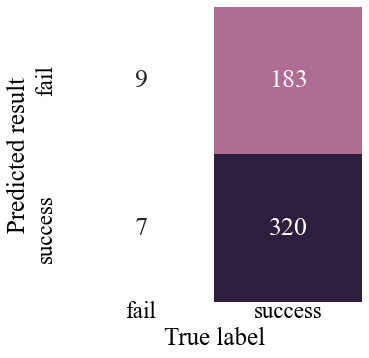

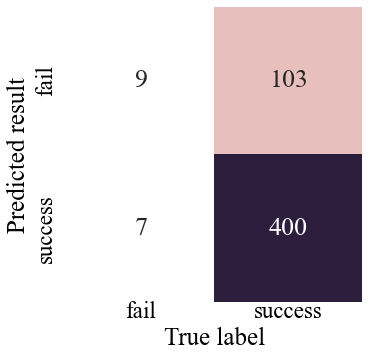

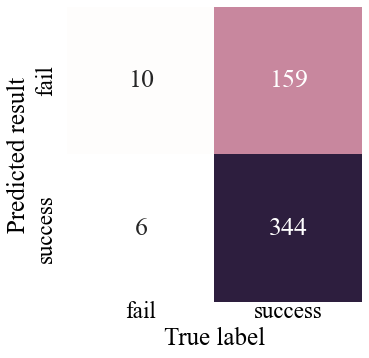

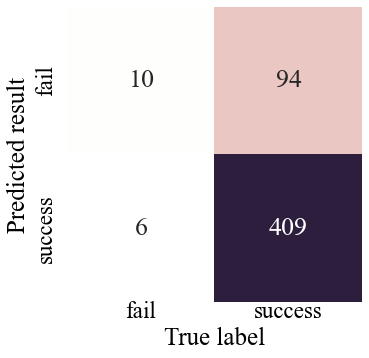

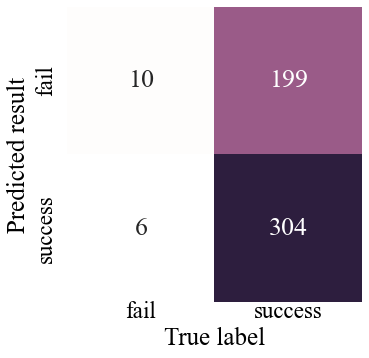

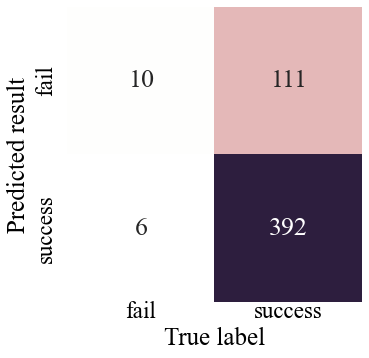

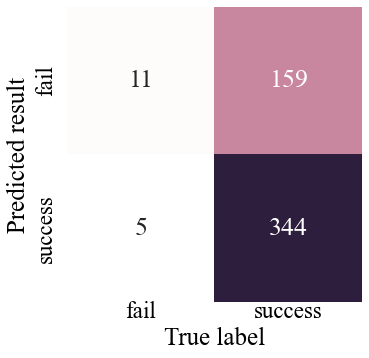

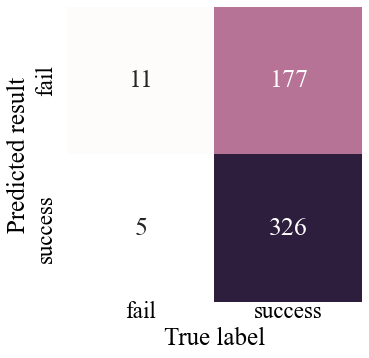

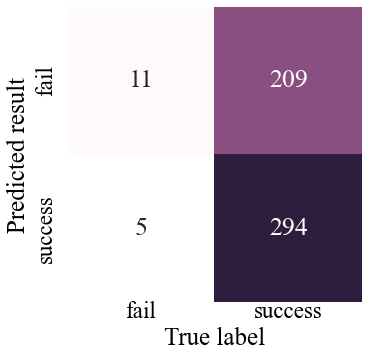

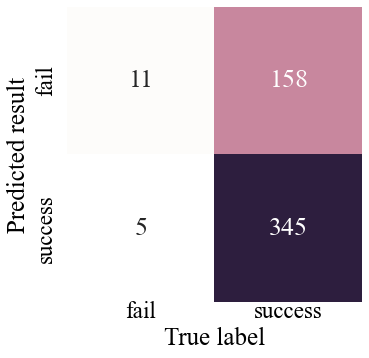

In [1804]:
#9
plot_cm(y_test, Cost_ann_results[0], 0.145)
plot_cm(y_test, Cost_ann_results[1], 0.12)
plot_cm(y_test, Cost_ann_results[2], 0.044)
plot_cm(y_test, Cost_ann_results[3], 0.25)
#10
plot_cm(y_test, Cost_ann_results[0], 0.045)
plot_cm(y_test, Cost_ann_results[1], 0.074)
plot_cm(y_test, Cost_ann_results[2], 0.031)
plot_cm(y_test, Cost_ann_results[3], 0.24)
#11
plot_cm(y_test, Cost_ann_results[0], 0.044)
plot_cm(y_test, Cost_ann_results[1], 0.039)
plot_cm(y_test, Cost_ann_results[2], 0.025)
plot_cm(y_test, Cost_ann_results[3], 0.16)

# Best regular models.

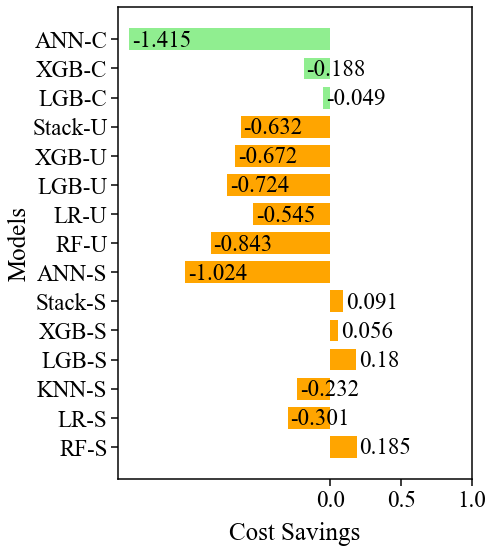

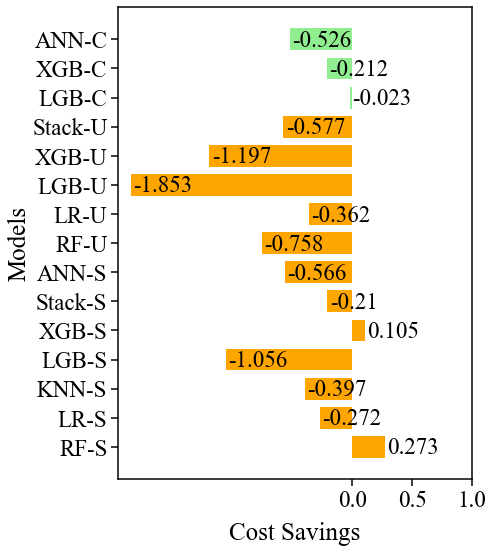

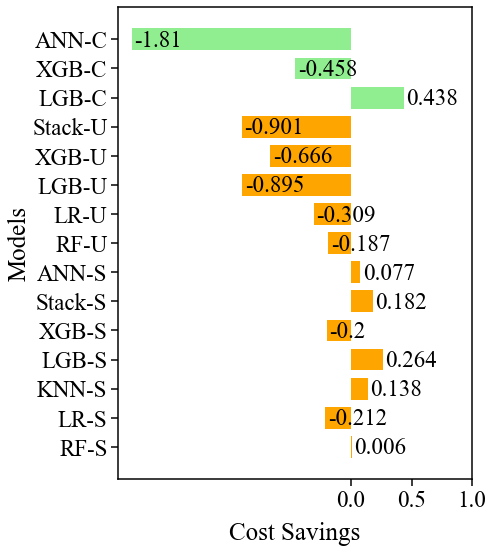

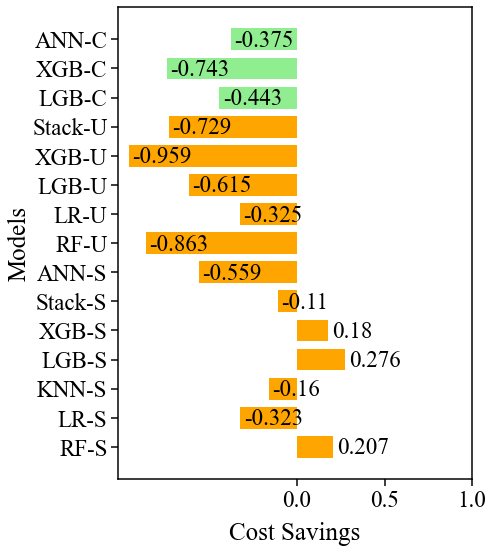

In [1812]:
weight_test = Asy_test_weight[0]
#begin to draw the cost savings.
yy = ['RF-S', 'LR-S', 'KNN-S', 'LGB-S', 'XGB-S', 'Stack-S', 
      'ANN-S', 'RF-U', 'LR-U', 'LGB-U', 'XGB-U', 'Stack-U',  
      'LGB-C', 'XGB-C', 'ANN-C']
colors = ['orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange',
          'orange', 'orange', 'orange', 'orange', 'lightgreen', 'lightgreen', 'lightgreen']

values = [calculate_cost_saving(y_test, RF_smote_results[0][:, 1], weight_test, 0.355),
          calculate_cost_saving(y_test, LR_smote_results[0][:, 1], weight_test, 0.586),
          calculate_cost_saving(y_test, KNN_smote_results[0][:, 1], weight_test, 0.79),
          calculate_cost_saving(y_test, LGB_smote_results[0][:, 1], weight_test, 0.46),
          calculate_cost_saving(y_test, XGB_smote_results[0][:, 1], weight_test, 0.028),
          calculate_cost_saving(y_test, smote_stacking_results[0][:, 1], weight_test, 0.095),
          calculate_cost_saving(y_test, Regular_ann_results[0].reshape(-1), weight_test, 0.00002),
          calculate_cost_saving(y_test, RF_under_results[0][:, 1], weight_test, 0.581),
          calculate_cost_saving(y_test, LR_under_results[0][:, 1], weight_test, 0.6567),
          calculate_cost_saving(y_test, LGB_under_results[0][:, 1], weight_test, 0.667),
          calculate_cost_saving(y_test, XGB_under_results[0][:, 1], weight_test, 0.78),
          calculate_cost_saving(y_test, under_stacking_results[0][:, 1], weight_test, 0.063),
          calculate_cost_saving(y_test, Lgb_cost_results[0], weight_test, 0.0017),
          calculate_cost_saving(y_test, Xgb_cost_results[0], weight_test, 0.074),
          calculate_cost_saving(y_test, Cost_ann_results[0].reshape(-1), weight_test, 0.045)]

plot_barh(yy, values, 'Cost Savings', 'Models', colors)

values = [calculate_cost_saving(y_test, RF_smote_results[1][:, 1], weight_test, 0.288),
          calculate_cost_saving(y_test, LR_smote_results[1][:, 1], weight_test, 0.583),
          calculate_cost_saving(y_test, KNN_smote_results[1][:, 1], weight_test, 0.73),
          calculate_cost_saving(y_test, LGB_smote_results[1][:, 1], weight_test, 0.37),
          calculate_cost_saving(y_test, XGB_smote_results[1][:, 1], weight_test, 0.064),
          calculate_cost_saving(y_test, smote_stacking_results[1][:, 1], weight_test, 0.069),
          calculate_cost_saving(y_test, Regular_ann_results[1].reshape(-1), weight_test, 0.000015),
          calculate_cost_saving(y_test, RF_under_results[1][:, 1], weight_test, 0.537),
          calculate_cost_saving(y_test, LR_under_results[1][:, 1], weight_test, 0.68),
          calculate_cost_saving(y_test, LGB_under_results[1][:, 1], weight_test, 0.36),
          calculate_cost_saving(y_test, XGB_under_results[1][:, 1], weight_test, 0.491),
          calculate_cost_saving(y_test, under_stacking_results[1][:, 1], weight_test, 0.05),
          calculate_cost_saving(y_test, Lgb_cost_results[1], weight_test, 0.0026),
          calculate_cost_saving(y_test, Xgb_cost_results[1], weight_test, 0.067),
          calculate_cost_saving(y_test, Cost_ann_results[1].reshape(-1), weight_test, 0.074)]

plot_barh(yy, values, 'Cost Savings', 'Models', colors)

values = [calculate_cost_saving(y_test, RF_smote_results[2][:, 1], weight_test, 0.344),
          calculate_cost_saving(y_test, LR_smote_results[2][:, 1], weight_test, 0.537),
          calculate_cost_saving(y_test, KNN_smote_results[2][:, 1], weight_test, 0.85),
          calculate_cost_saving(y_test, LGB_smote_results[2][:, 1], weight_test, 0.445),
          calculate_cost_saving(y_test, XGB_smote_results[2][:, 1], weight_test, 0.025),
          calculate_cost_saving(y_test, smote_stacking_results[2][:, 1], weight_test, 0.0761),
          calculate_cost_saving(y_test, Regular_ann_results[2].reshape(-1), weight_test, 0.0091),
          calculate_cost_saving(y_test, RF_under_results[2][:, 1], weight_test, 0.594),
          calculate_cost_saving(y_test, LR_under_results[2][:, 1], weight_test, 0.561),
          calculate_cost_saving(y_test, LGB_under_results[2][:, 1], weight_test, 0.612),
          calculate_cost_saving(y_test, XGB_under_results[2][:, 1], weight_test, 0.69),
          calculate_cost_saving(y_test, under_stacking_results[2][:, 1], weight_test, 0.036),
          calculate_cost_saving(y_test, Lgb_cost_results[2], weight_test, 0.0076),
          calculate_cost_saving(y_test, Xgb_cost_results[2], weight_test, 0.0567),
          calculate_cost_saving(y_test, Cost_ann_results[2].reshape(-1), weight_test, 0.031)]

plot_barh(yy, values, 'Cost Savings', 'Models', colors)

values = [calculate_cost_saving(y_test, RF_smote_results[3][:, 1], weight_test, 0.267),
          calculate_cost_saving(y_test, LR_smote_results[3][:, 1], weight_test, 0.538),
          calculate_cost_saving(y_test, KNN_smote_results[3][:, 1], weight_test, 0.8),
          calculate_cost_saving(y_test, LGB_smote_results[3][:, 1], weight_test, 0.45),
          calculate_cost_saving(y_test, XGB_smote_results[3][:, 1], weight_test, 0.082),
          calculate_cost_saving(y_test, smote_stacking_results[3][:, 1], weight_test, 0.084),
          calculate_cost_saving(y_test, Regular_ann_results[3].reshape(-1), weight_test, 0.0002),
          calculate_cost_saving(y_test, RF_under_results[3][:, 1], weight_test, 0.557),
          calculate_cost_saving(y_test, LR_under_results[3][:, 1], weight_test, 0.582),
          calculate_cost_saving(y_test, LGB_under_results[3][:, 1], weight_test, 0.582),
          calculate_cost_saving(y_test, XGB_under_results[3][:, 1], weight_test, 0.696),
          calculate_cost_saving(y_test, under_stacking_results[3][:, 1], weight_test, 0.044),
          calculate_cost_saving(y_test, Lgb_cost_results[3], weight_test, 0.0013),
          calculate_cost_saving(y_test, Xgb_cost_results[3], weight_test, 0.048),
          calculate_cost_saving(y_test, Cost_ann_results[3].reshape(-1), weight_test, 0.24)]

plot_barh(yy, values, 'Cost Savings', 'Models', colors)

In [ ]:
ax.plot([calculate_cost_saving(y_test, LGB_smote_results[0][:, 1], weight_test, 0.054),
         calculate_cost_saving(y_test, Cost_ann_results[0].reshape(-1), weight_test, 0.0015),
         calculate_cost_saving(y_test, RF_under_results[0][:, 1], weight_test, 0.575)], color='black', linewidth=4)

ax.text(-0.1, calculate_cost_saving(y_test, LGB_smote_results[0][:, 1], weight_test, 0.054) + 0.01, 
        'LGB-S' + '(' + str(round(calculate_cost_saving(y_test, LGB_smote_results[0][:, 1], weight_test, 0.054), 3)) + ')', 
        color='black', fontfamily='times new roman', fontsize=14, weight='bold')

ax.text(0.75, calculate_cost_saving(y_test, Cost_ann_results[0].reshape(-1), weight_test, 0.0015) + 0.01, 
        'ANN-C' + '(' + str(round(calculate_cost_saving(y_test, Cost_ann_results[0].reshape(-1), weight_test, 0.0015), 3)) + ')', 
        color='black', fontfamily='times new roman', fontsize=14, weight='bold')

ax.text(1.58, calculate_cost_saving(y_test, RF_under_results[0][:, 1], weight_test, 0.575) + 0.01, 
        'RF-U' + '(' + str(round(calculate_cost_saving(y_test, RF_under_results[0][:, 1], weight_test, 0.575), 3)) + ')', 
        color='black', fontfamily='times new roman', fontsize=14, weight='bold')

In [1875]:
#data 1, 7-8-9
RF_S = [0.409, 0.355, 0.345]
LR_S = [0.596, 0.586,  0.571]
KNN_S = [0.8, 0.79,  0.749]
LGB_S = [0.47, 0.46, 0.44]
XGB_S = [0.033, 0.028, 0.027]
Stack_S = [0.103, 0.095, 0.089]
ANN_S = [0.0002, 0.00002, 0.000003]
RF_U = [0.61, 0.581,  0.563]
LR_U = [0.79, 0.6567, 0.656]
LGB_U = [0.681, 0.667, 0.556]
XGB_U = [0.81, 0.78, 0.696]
Stack_U = [0.083, 0.063, 0.053]
LGB_C = [0.0045, 0.0017, 0.00119]
XGB_C = [0.112, 0.074, 0.068]
ANN_C = [0.145, 0.045, 0.044]

smote_points = [RF_S, LR_S, KNN_S, LGB_S, XGB_S, Stack_S, ANN_S]
under_points = [RF_U, LR_U, LGB_U, XGB_U, Stack_U]
cost_points = [LGB_C, XGB_C, ANN_C]

smote_results = [RF_smote_results[0][:, 1], LR_smote_results[0][:, 1], KNN_smote_results[0][:, 1], 
                 LGB_smote_results[0][:, 1], XGB_smote_results[0][:, 1], smote_stacking_results[0][:, 1],
                 Regular_ann_results[0].reshape(-1)]

under_results = [RF_under_results[0][:, 1], LR_under_results[0][:, 1], LGB_under_results[0][:, 1], 
                 XGB_under_results[0][:, 1], under_stacking_results[0][:, 1]]

cost_results = [Lgb_cost_results[0], Xgb_cost_results[0], Cost_ann_results[0].reshape(-1)]

smote_labels = ['RF-S', 'LR-S', 'KNN-S', 'LGB-S', 'XGB-S', 'Stack-S', 'ANN-S']
under_labels = ['RF-U', 'LR-U', 'LGB-U', 'XGB-U', 'Stack-U']
cost_labels = ['LGB-C', 'XGB-C', 'ANN-C']

Text(1.58, 0.2784404738405041, 'LGB-S(0.26)')

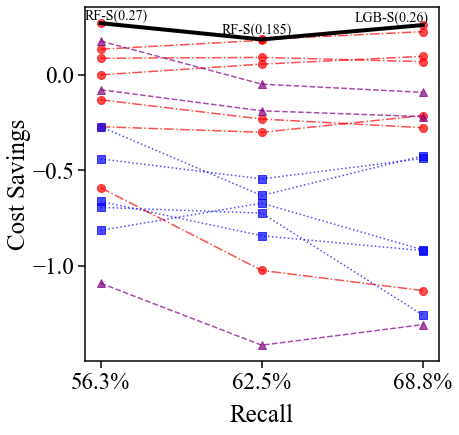

In [1876]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

ax.set_xlabel('Recall', fontsize=25, fontname='times new roman', labelpad=10)
ax.set_ylabel('Cost Savings', fontsize=25, fontname='times new roman', labelpad=1)
ax.tick_params(axis='both', length=7, labelsize=23, width=1.5, color='black')

ax.spines["top"].set_linewidth(1.5)
ax.spines["bottom"].set_linewidth(1.5)
ax.spines["left"].set_linewidth(1.5)
ax.spines["right"].set_linewidth(1.5)

labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
plt.subplots_adjust(left=0.14, right=0.96, top=0.96, bottom=0.14)

ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['56.3%', '62.5%', '68.8%'])


for i in range(len(smote_labels)):
    point = smote_points[i]
    model = smote_results[i]
    label = smote_labels[i]
    points = []
    for i in point:
        points.append(calculate_cost_saving(y_test, model, weight_test, i))
    ax.plot(points, label=label, color='red', linestyle='-.', alpha=0.7, marker='o', markersize=8)
    
for i in range(len(under_labels)):
    point = under_points[i]
    model = under_results[i]
    label = under_labels[i]
    points = []
    for i in point:
        points.append(calculate_cost_saving(y_test, model, weight_test, i))
    ax.plot(points, label=label, color='blue', linestyle=':', alpha=0.7, marker='s', markersize=8)

for i in range(len(cost_labels)):
    point = cost_points[i]
    model = cost_results[i]
    label = cost_labels[i]
    points = []
    for i in point:
        points.append(calculate_cost_saving(y_test, model, weight_test, i))
    ax.plot(points, label=label, color='purple', linestyle='--', alpha=0.7, marker='^', markersize=8)

ax.plot([calculate_cost_saving(y_test, RF_smote_results[0][:, 1], weight_test, 0.409),
         calculate_cost_saving(y_test, RF_smote_results[0][:, 1], weight_test, 0.355),
         calculate_cost_saving(y_test, LGB_smote_results[0][:, 1], weight_test, 0.44)], color='black', linewidth=4)

ax.text(-0.1, calculate_cost_saving(y_test, RF_smote_results[0][:, 1], weight_test, 0.409) + 0.018, 
        'RF-S' + '(' + str(round(calculate_cost_saving(y_test, RF_smote_results[0][:, 1], weight_test, 0.409), 3)) + ')', 
        color='black', fontfamily='times new roman', fontsize=14, weight='bold')

ax.text(0.75, calculate_cost_saving(y_test, RF_smote_results[0][:, 1], weight_test, 0.355) + 0.03, 
        'RF-S' + '(' + str(round(calculate_cost_saving(y_test, RF_smote_results[0][:, 1], weight_test, 0.355), 3)) + ')', 
        color='black', fontfamily='times new roman', fontsize=14, weight='bold')

ax.text(1.58, calculate_cost_saving(y_test, LGB_smote_results[0][:, 1], weight_test, 0.44) + 0.018, 
        'LGB-S' + '(' + str(round(calculate_cost_saving(y_test, LGB_smote_results[0][:, 1], weight_test, 0.44), 3)) + ')', 
        color='black', fontfamily='times new roman', fontsize=14, weight='bold')

In [1877]:
# data 2
RF_S = [0.3, 0.288, 0.266]
LR_S = [0.606, 0.583, 0.546]
KNN_S = [0.78, 0.73, 0.7]
LGB_S = [0.556, 0.37, 0.367]
XGB_S = [0.13, 0.064, 0.055]
Stack_S = [0.088, 0.069, 0.068]
ANN_S = [0.00011, 0.000015, 0.0000002]
RF_U = [0.551, 0.537, 0.51]
LR_U = [0.7, 0.68, 0.61]
LGB_U = [0.44, 0.36, 0.355]
XGB_U = [0.616, 0.491, 0.61]
Stack_U = [0.054, 0.05, 0.035]
LGB_C = [0.00266, 0.0026, 0.00172]
XGB_C = [0.072, 0.067, 0.0543]
ANN_C = [0.12, 0.074, 0.039]

smote_results = [RF_smote_results[1][:, 1], LR_smote_results[1][:, 1], KNN_smote_results[1][:, 1], 
                 LGB_smote_results[1][:, 1], XGB_smote_results[1][:, 1], smote_stacking_results[1][:, 1],
                 Regular_ann_results[1].reshape(-1)]

under_results = [RF_under_results[1][:, 1], LR_under_results[1][:, 1], LGB_under_results[1][:, 1], 
                 XGB_under_results[1][:, 1], under_stacking_results[1][:, 1]]

cost_results = [Lgb_cost_results[1], Xgb_cost_results[1], Cost_ann_results[1].reshape(-1)]

smote_labels = ['RF-S', 'LR-S', 'KNN-S', 'LGB-S', 'XGB-S', 'Stack-S', 'ANN-S']
under_labels = ['RF-U', 'LR-U', 'LGB-U', 'XGB-U', 'Stack-U']
cost_labels = ['LGB-C', 'XGB-C', 'ANN-C']

smote_points = [RF_S, LR_S, KNN_S, LGB_S, XGB_S, Stack_S, ANN_S]
under_points = [RF_U, LR_U, LGB_U, XGB_U, Stack_U]
cost_points = [LGB_C, XGB_C, ANN_C]

Text(1.58, 0.26552208254500764, 'RF-S(0.239)')

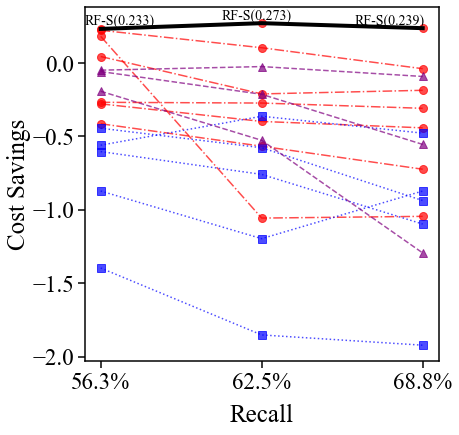

In [1878]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

ax.set_xlabel('Recall', fontsize=25, fontname='times new roman', labelpad=10)
ax.set_ylabel('Cost Savings', fontsize=25, fontname='times new roman', labelpad=1)
ax.tick_params(axis='both', length=7, labelsize=23, width=1.5, color='black')

ax.spines["top"].set_linewidth(1.5)
ax.spines["bottom"].set_linewidth(1.5)
ax.spines["left"].set_linewidth(1.5)
ax.spines["right"].set_linewidth(1.5)

labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
plt.subplots_adjust(left=0.14, right=0.96, top=0.96, bottom=0.14)

ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['56.3%', '62.5%', '68.8%'])


for i in range(len(smote_labels)):
    point = smote_points[i]
    model = smote_results[i]
    label = smote_labels[i]
    points = []
    for i in point:
        points.append(calculate_cost_saving(y_test, model, weight_test, i))
    ax.plot(points, label=label, color='red', linestyle='-.', alpha=0.7, marker='o', markersize=8)
    
for i in range(len(under_labels)):
    point = under_points[i]
    model = under_results[i]
    label = under_labels[i]
    points = []
    for i in point:
        points.append(calculate_cost_saving(y_test, model, weight_test, i))
    ax.plot(points, label=label, color='blue', linestyle=':', alpha=0.7, marker='s', markersize=8)

for i in range(len(cost_labels)):
    point = cost_points[i]
    model = cost_results[i]
    label = cost_labels[i]
    points = []
    for i in point:
        points.append(calculate_cost_saving(y_test, model, weight_test, i))
    ax.plot(points, label=label, color='purple', linestyle='--', alpha=0.7, marker='^', markersize=8)

ax.plot([calculate_cost_saving(y_test, RF_smote_results[1][:, 1], weight_test, 0.3),
         calculate_cost_saving(y_test, RF_smote_results[1][:, 1], weight_test, 0.288),
         calculate_cost_saving(y_test, RF_smote_results[1][:, 1], weight_test, 0.266)], color='black', linewidth=4)

ax.text(-0.1, calculate_cost_saving(y_test, RF_smote_results[1][:, 1], weight_test, 0.3) + 0.027, 
        'RF-S' + '(' + str(round(calculate_cost_saving(y_test, RF_smote_results[1][:, 1], weight_test, 0.3), 3)) + ')', 
        color='black', fontfamily='times new roman', fontsize=14, weight='bold')

ax.text(0.75, calculate_cost_saving(y_test, RF_smote_results[1][:, 1], weight_test, 0.288) + 0.026, 
        'RF-S' + '(' + str(round(calculate_cost_saving(y_test, RF_smote_results[1][:, 1], weight_test, 0.288), 3)) + ')', 
        color='black', fontfamily='times new roman', fontsize=14, weight='bold')

ax.text(1.58, calculate_cost_saving(y_test, RF_smote_results[1][:, 1], weight_test, 0.266) + 0.027, 
        'RF-S' + '(' + str(round(calculate_cost_saving(y_test, RF_smote_results[1][:, 1], weight_test, 0.266), 3)) + ')', 
        color='black', fontfamily='times new roman', fontsize=14, weight='bold')

In [1879]:
# data 3
RF_S = [0.383, 0.344, 0.339]
LR_S = [0.584, 0.537, 0.533]
KNN_S = [0.858, 0.85, 0.74]
LGB_S = [0.4459, 0.445, 0.377]
XGB_S = [0.027, 0.025, 0.0179]
Stack_S = [0.079, 0.0761, 0.076]
ANN_S = [0.051, 0.0091, 0.00003]
RF_U = [0.601, 0.594, 0.591]
LR_U = [0.587, 0.561, 0.531]
LGB_U = [0.71, 0.612, 0.59]
XGB_U = [0.81, 0.69, 0.31]
Stack_U = [0.064, 0.036, 0.032]
LGB_C = [0.0082, 0.0076, 0.00182]
XGB_C = [0.075, 0.0567, 0.0558]
ANN_C = [0.044, 0.031, 0.025]

smote_results = [RF_smote_results[2][:, 1], LR_smote_results[2][:, 1], KNN_smote_results[2][:, 1], 
                 LGB_smote_results[2][:, 1], XGB_smote_results[2][:, 1], smote_stacking_results[2][:, 1],
                 Regular_ann_results[2].reshape(-1)]

under_results = [RF_under_results[2][:, 1], LR_under_results[2][:, 1], LGB_under_results[2][:, 1], 
                 XGB_under_results[2][:, 1], under_stacking_results[2][:, 1]]

cost_results = [Lgb_cost_results[2], Xgb_cost_results[2], Cost_ann_results[2].reshape(-1)]

smote_labels = ['RF-S', 'LR-S', 'KNN-S', 'LGB-S', 'XGB-S', 'Stack-S', 'ANN-S']
under_labels = ['RF-U', 'LR-U', 'LGB-U', 'XGB-U', 'Stack-U']
cost_labels = ['LGB-C', 'XGB-C', 'ANN-C']

smote_points = [RF_S, LR_S, KNN_S, LGB_S, XGB_S, Stack_S, ANN_S]
under_points = [RF_U, LR_U, LGB_U, XGB_U, Stack_U]
cost_points = [LGB_C, XGB_C, ANN_C]

Text(1.58, 0.3440652331291314, 'Stack-S(0.244)')

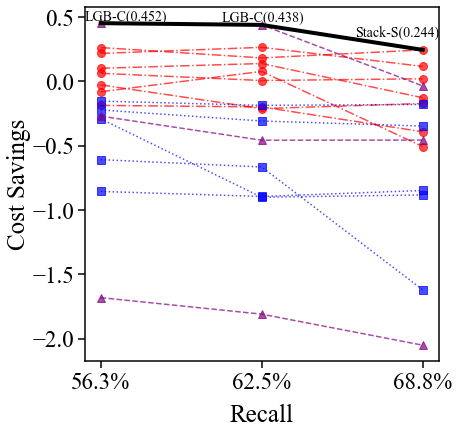

In [1880]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

ax.set_xlabel('Recall', fontsize=25, fontname='times new roman', labelpad=10)
ax.set_ylabel('Cost Savings', fontsize=25, fontname='times new roman', labelpad=1)
ax.tick_params(axis='both', length=7, labelsize=23, width=1.5, color='black')

ax.spines["top"].set_linewidth(1.5)
ax.spines["bottom"].set_linewidth(1.5)
ax.spines["left"].set_linewidth(1.5)
ax.spines["right"].set_linewidth(1.5)

labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
plt.subplots_adjust(left=0.14, right=0.96, top=0.96, bottom=0.14)

ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['56.3%', '62.5%', '68.8%'])


for i in range(len(smote_labels)):
    point = smote_points[i]
    model = smote_results[i]
    label = smote_labels[i]
    points = []
    for i in point:
        points.append(calculate_cost_saving(y_test, model, weight_test, i))
    ax.plot(points, label=label, color='red', linestyle='-.', alpha=0.7, marker='o', markersize=8)
    
for i in range(len(under_labels)):
    point = under_points[i]
    model = under_results[i]
    label = under_labels[i]
    points = []
    for i in point:
        points.append(calculate_cost_saving(y_test, model, weight_test, i))
    ax.plot(points, label=label, color='blue', linestyle=':', alpha=0.7, marker='s', markersize=8)

for i in range(len(cost_labels)):
    point = cost_points[i]
    model = cost_results[i]
    label = cost_labels[i]
    points = []
    for i in point:
        points.append(calculate_cost_saving(y_test, model, weight_test, i))
    ax.plot(points, label=label, color='purple', linestyle='--', alpha=0.7, marker='^', markersize=8)

ax.plot([calculate_cost_saving(y_test, Lgb_cost_results[2], weight_test, 0.0082),
         calculate_cost_saving(y_test, Lgb_cost_results[2], weight_test, 0.0076),
         calculate_cost_saving(y_test, smote_stacking_results[2][:, 1], weight_test, 0.076)], color='black', linewidth=4)

ax.text(-0.1, calculate_cost_saving(y_test, Lgb_cost_results[2], weight_test, 0.0082) + 0.019, 
        'LGB-C' + '(' + str(round(calculate_cost_saving(y_test, Lgb_cost_results[2], weight_test, 0.0082), 3)) + ')', 
        color='black', fontfamily='times new roman', fontsize=14, weight='bold')

ax.text(0.75, calculate_cost_saving(y_test, Lgb_cost_results[2], weight_test, 0.0076) + 0.029, 
        'LGB-C' + '(' + str(round(calculate_cost_saving(y_test, Lgb_cost_results[2], weight_test, 0.0076), 3)) + ')', 
        color='black', fontfamily='times new roman', fontsize=14, weight='bold')

ax.text(1.58, calculate_cost_saving(y_test, smote_stacking_results[2][:, 1], weight_test, 0.076) + 0.1, 
        'Stack-S' + '(' + str(round(calculate_cost_saving(y_test, smote_stacking_results[2][:, 1], weight_test, 0.076), 3)) + ')', 
        color='black', fontfamily='times new roman', fontsize=14, weight='bold')

In [1881]:
# data 4
RF_S = [0.27, 0.267, 0.259]
LR_S = [0.541, 0.538, 0.512]
KNN_S = [0.83, 0.8, 0.79]
LGB_S = [0.472, 0.45, 0.37]
XGB_S = [0.088, 0.082, 0.068]
Stack_S = [0.085, 0.084, 0.062]
ANN_S = [0.0057, 0.0002, 0.00014]
RF_U = [0.587, 0.557, 0.554]
LR_U = [0.61, 0.582, 0.508]
LGB_U = [0.598, 0.582, 0.518]
XGB_U = [0.746, 0.696, 0.47]
Stack_U = [0.052, 0.044, 0.041]
LGB_C = [0.0016, 0.0013, 0.00086]
XGB_C = [0.085, 0.048, 0.036]
ANN_C = [0.25, 0.24, 0.16]

smote_results = [RF_smote_results[3][:, 1], LR_smote_results[3][:, 1], KNN_smote_results[3][:, 1], 
                 LGB_smote_results[3][:, 1], XGB_smote_results[3][:, 1], smote_stacking_results[3][:, 1],
                 Regular_ann_results[3].reshape(-1)]

under_results = [RF_under_results[3][:, 1], LR_under_results[3][:, 1], LGB_under_results[3][:, 1], 
                 XGB_under_results[3][:, 1], under_stacking_results[3][:, 1]]

cost_results = [Lgb_cost_results[3], Xgb_cost_results[3], Cost_ann_results[3].reshape(-1)]

smote_labels = ['RF-S', 'LR-S', 'KNN-S', 'LGB-S', 'XGB-S', 'Stack-S', 'ANN-S']
under_labels = ['RF-U', 'LR-U', 'LGB-U', 'XGB-U', 'Stack-U']
cost_labels = ['LGB-C', 'XGB-C', 'ANN-C']

smote_points = [RF_S, LR_S, KNN_S, LGB_S, XGB_S, Stack_S, ANN_S]
under_points = [RF_U, LR_U, LGB_U, XGB_U, Stack_U]
cost_points = [LGB_C, XGB_C, ANN_C]

Text(1.7, 0.26995767639342916, 'RF-S(0.22)')

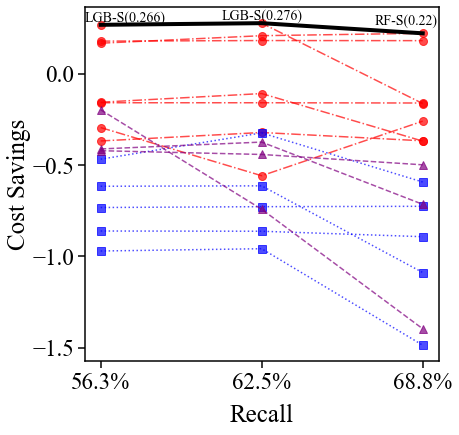

In [1882]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

ax.set_xlabel('Recall', fontsize=25, fontname='times new roman', labelpad=10)
ax.set_ylabel('Cost Savings', fontsize=25, fontname='times new roman', labelpad=1)
ax.tick_params(axis='both', length=7, labelsize=23, width=1.5, color='black')

ax.spines["top"].set_linewidth(1.5)
ax.spines["bottom"].set_linewidth(1.5)
ax.spines["left"].set_linewidth(1.5)
ax.spines["right"].set_linewidth(1.5)

labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
plt.subplots_adjust(left=0.14, right=0.96, top=0.96, bottom=0.14)

ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['56.3%', '62.5%', '68.8%'])


for i in range(len(smote_labels)):
    point = smote_points[i]
    model = smote_results[i]
    label = smote_labels[i]
    points = []
    for i in point:
        points.append(calculate_cost_saving(y_test, model, weight_test, i))
    ax.plot(points, label=label, color='red', linestyle='-.', alpha=0.7, marker='o', markersize=8)
    
for i in range(len(under_labels)):
    point = under_points[i]
    model = under_results[i]
    label = under_labels[i]
    points = []
    for i in point:
        points.append(calculate_cost_saving(y_test, model, weight_test, i))
    ax.plot(points, label=label, color='blue', linestyle=':', alpha=0.7, marker='s', markersize=8)

for i in range(len(cost_labels)):
    point = cost_points[i]
    model = cost_results[i]
    label = cost_labels[i]
    points = []
    for i in point:
        points.append(calculate_cost_saving(y_test, model, weight_test, i))
    ax.plot(points, label=label, color='purple', linestyle='--', alpha=0.7, marker='^', markersize=8)
    
ax.plot([calculate_cost_saving(y_test, LGB_smote_results[3][:, 1], weight_test, 0.472),
         calculate_cost_saving(y_test, LGB_smote_results[3][:, 1], weight_test, 0.45),
         calculate_cost_saving(y_test, RF_smote_results[3][:, 1], weight_test, 0.259)], color='black', linewidth=4)

ax.text(-0.1, calculate_cost_saving(y_test, LGB_smote_results[3][:, 1], weight_test, 0.472) + 0.02, 
        'LGB-S' + '(' + str(round(calculate_cost_saving(y_test, LGB_smote_results[3][:, 1], weight_test, 0.472), 3)) + ')', 
        color='black', fontfamily='times new roman', fontsize=14, weight='bold')

ax.text(0.75, calculate_cost_saving(y_test, LGB_smote_results[3][:, 1], weight_test, 0.45) + 0.02, 
        'LGB-S' + '(' + str(round(calculate_cost_saving(y_test, LGB_smote_results[3][:, 1], weight_test, 0.45), 3)) + ')', 
        color='black', fontfamily='times new roman', fontsize=14, weight='bold')

ax.text(1.7, calculate_cost_saving(y_test, RF_smote_results[3][:, 1], weight_test, 0.259) + 0.05, 
        'RF-S' + '(' + str(round(calculate_cost_saving(y_test, RF_smote_results[3][:, 1], weight_test, 0.259), 3)) + ')', 
        color='black', fontfamily='times new roman', fontsize=14, weight='bold')

No handles with labels found to put in legend.


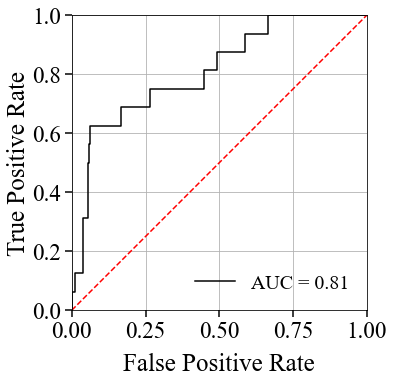

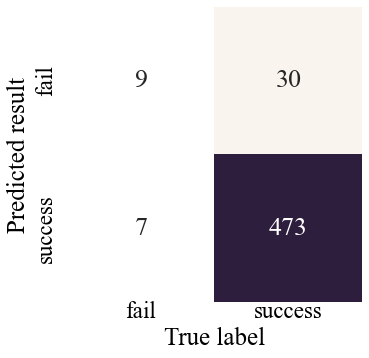

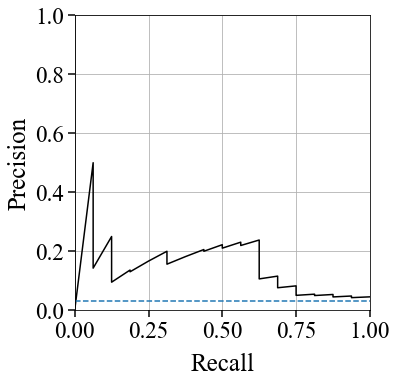

In [1868]:
plot_roc(y_test, Lgb_cost_results[2])
plot_cm(y_test, Lgb_cost_results[2], 0.0082)
plot_recall_precision(y_test, Lgb_cost_results[2])

In [1869]:
true_value = y_test.copy()
tt = pd.DataFrame(data = {'real': true_value, 'predict': (Lgb_cost_results[2] > 0.0082)})
FP = tt[(tt['real'] == 0) & (tt['predict'] == True)].index.values
FN = tt[(tt['real'] == 1) & (tt['predict'] == False)].index.values
TP = tt[(tt['real'] == 1) & (tt['predict'] == True)].index.values
TN = tt[(tt['real'] == 0) & (tt['predict'] == False)].index.values

In [1870]:
FP

array([2570,  545,   77,  152, 2191, 2580, 1383, 2544, 2550, 2575,   86,
        129,  450,  150,  357,  522,  532,  451,  469, 2572, 2589,   42,
       2577,  391,  144,  542,  269,   52, 1324,  225], dtype=int64)

In [1871]:
FN

array([2503, 2461, 2494, 2502, 2459, 2498, 2533], dtype=int64)

In [1872]:
TP

array([2492, 2484, 2454, 2469, 2507, 2475, 2486, 2479, 2517], dtype=int64)

No handles with labels found to put in legend.


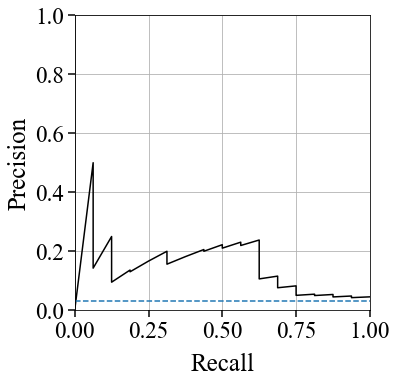

In [1887]:
plot_recall_precision(y_test, Lgb_cost_results[2])

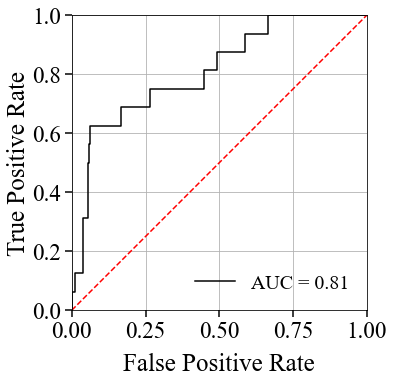

In [1885]:
plot_roc(y_test, Lgb_cost_results[2])